<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.316 Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 12



<a name='section_12_0'></a>
<hr style="height: 1px;">


## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.0 Overview of Learning Objectives</h2>


In this lecture we will explore the following objectives:

- Fitting For the Higgs Boson
- Combining p-values
- Convolutions
- Building Interpolated distributions
- Dealing with non-analytic forms
<br>
<!--end-block-->

<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [1]:
#>>>RUN: L11.0-runcell01

import numpy as np
import lmfit
import matplotlib.pyplot as plt
import csv
from scipy import stats

<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.


In [2]:
#>>>RUN: L11.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title


<a name='section_11_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L11.3 The f-test(Chow-test)</h2>  



In the interest of generalizing the t-test, the statistician Ronald Fisher developed the [f-test](https://en.wikipedia.org/wiki/F-test). This is really a generalization of t-test. This has become very useful in physics due to the work of Gregory Chow at MIT in the late 1950s. At that time, he developed the Chow test aimed at trying to come up with a way for how well a fit is behaving. To undersand the chow-test lets delve into the the f-test. 

The f-test is used when you want to compare a few distributions with each other. Imagine for example you have $N$ groups of data, each with $m$ points. If these samples are all from a Gaussian distribution of mean $\mu$ and variance $\sigma^{2}$, ie $\mathcal{N}(x,\mu,\sigma)$. Then we can define a new statistic defined conceptually as 
\begin{equation}
 f = \frac{\rm variance~across~samples}{\rm variance~within~each~sample}  
\end{equation}
which should be close to 1 if the samples are all from the same underlying distribution, but it should not be 1 if the samples are from different distributions. 

Lets say we have two distributions $a$ and $b$ each with number of degrees of freedom given by $n_{a}$ and $n_{b}$, we can then write the f-distribution as the ratio of their variances: 
\begin{equation}
 f = \frac{\frac{S^{2}_{a}}{n_{a}} }{ \frac{S^{2}_{b}}{n_{b}} }\\
\end{equation}

More generally, we can write the f-statistic as the variance of distinct samples over the average variance over the individual samples. For a total amount of $N$ samples with $K$ groups, each with $n_{i}$ events within and mean $\bar{x}_{i}$, we can write the f-statistic as 
\begin{equation}
 \sigma^{2}_{\rm group} = \frac{1}{K-1}\sum_{i=1}^{K} n_{i} \left(\bar{x}_{i}-\bar{x}\right)^2 \\
 \sigma^2 = \frac{1}{N-K}\sum_{i=1}^{K}\sum_{j=1}^{n_{i}}\left(x_{ij}-\bar{x}_{i}\right)^{2}\\ 
 f = \frac{  \sigma^{2}_{\rm group} }{\sigma^{2}}
\end{equation}
The idea is that the numerator and denominator are both $\chi^{2}$ distributed variables with $K-1$ degrees of freedom on top, and $N-K$ degrees of freedom on the bottom. This statistic is most powerful for checking if the variances are consistent with being from the same distribution or a different distribution. 

From the above formulas, it has been derived that the f-statistic follows [$f$-distribution](https://en.wikipedia.org/wiki/F-distribution), which has a very complex form that we will write here once for posterity. 
\begin{equation}
f(x,d_{1}=K-1,d_{2}=N-K) = \frac{1}{\beta\left(\frac{d_{1}}{2},\frac{d_{2}}{2}\right)}\left(\frac{d_{1}}{d_{2}}\right)^{\frac{d_{1}}{2}}x^{\frac{d_{1}}{2}-1}\left(1+\frac{d_{1}}{d_{2}}x\right)^{-\frac{d_{1}+d_{2}}{2}}\\
\end{equation}
where $\beta(x,y)$ is the [$\beta$-function](https://en.wikipedia.org/wiki/Beta_function).

So why do we care about the f-test? 

Recall, that to get a good fit you want the fit residuals to look like a gaussian distribution. Unfortunately, its often that case that the fit residuals are not gaussian. Lets say you fit a line to a distribution, and the fit is not good. 

Well then you can try fitting a more complicated function, how about a quadratic. The residuals seem better. 

What about a 3rd order polynomial? 

When do we know where to stop. That is where the f-statistic can help us. The idea is that we can compare the fit residuals from each function. If the fit residual ratio has a high likeilhood given an f-distribution, then we know that the additional polynomial is not needed. 

More generally, the f-distribution tells you how do you tell that fit is better? One ways is to see if the $\chi^{2}$ is better, but what if the $\chi^{2}$ is approximately the same? Moreover what if your $\chi^{2}$ was originally good, but not gaussian. Comparing the residuals of the two fits, can tell us if our new fit function is actually better. The f-test helps us quantify this. 


Well lets say we want to compare the variance of two fits. 
If they variances are from the same underlying distribution they will follow the f-statistic. This comes up when we are trying to figure out if our fit is actually working. 

To do that, lets try to fit some Higgs boson data, lets load 2011, Higgs boson to two photons. First lets look at the data. 



In the interest of generalizing the t-test, the statistician Ronald Fisher developed the [f-test](https://en.wikipedia.org/wiki/F-test). This is really a generalization of t-test. This has become very useful in physics due to the work of Gregory Chow at MIT in the late 1950s. At that time, he developed the Chow test aimed at trying to come up with a way for how well a fit is behaving. To undersand the chow-test lets delve into the the f-test. 

The f-test is used when you want to compare a few distributions with each other. Imagine for example you have $N$ groups of data, each with $m$ points. If these samples are all from a Gaussian distribution of mean $\mu$ and variance $\sigma^{2}$, ie $\mathcal{N}(x,\mu,\sigma)$. Then we can define a new statistic defined conceptually as 
\begin{equation}
 f = \frac{\rm variance~across~samples}{\rm variance~within~each~sample}  
\end{equation}
which should be close to 1 if the samples are all from the same underlying distribution, but it should not be 1 if the samples are from different distributions. 

Lets say we have two distributions $a$ and $b$ each with number of degrees of freedom given by $n_{a}$ and $n_{b}$, we can then write the f-distribution as the ratio of their variances: 
\begin{equation}
 f = \frac{\frac{S^{2}_{a}}{n_{a}} }{ \frac{S^{2}_{b}}{n_{b}} }\\
\end{equation}

More generally, we can write the f-statistic as the variance of distinct samples over the average variance over the individual samples. For a total amount of $N$ samples with $K$ groups, each with $n_{i}$ events within and mean $\bar{x}_{i}$, we can write the f-statistic as 
\begin{equation}
 \sigma^{2}_{\rm group} = \frac{1}{K-1}\sum_{i=1}^{K} n_{i} \left(\bar{x}_{i}-\bar{x}\right)^2 \\
 \sigma^2 = \frac{1}{N-K}\sum_{i=1}^{K}\sum_{j=1}^{n_{i}}\left(x_{ij}-\bar{x}_{i}\right)^{2}\\ 
 f = \frac{  \sigma^{2}_{\rm group} }{\sigma^{2}}
\end{equation}
The idea is that the numerator and denominator are both $\chi^{2}$ distributed variables with $K-1$ degrees of freedom on top, and $N-K$ degrees of freedom on the bottom. This statistic is most powerful for checking if the variances are consistent with being from the same distribution or a different distribution. 

From the above formulas, it has been derived that the f-statistic follows [$f$-distribution](https://en.wikipedia.org/wiki/F-distribution), which has a very complex form that we will write here once for posterity. 
\begin{equation}
f(x,d_{1}=K-1,d_{2}=N-K) = \frac{1}{\beta\left(\frac{d_{1}}{2},\frac{d_{2}}{2}\right)}\left(\frac{d_{1}}{d_{2}}\right)^{\frac{d_{1}}{2}}x^{\frac{d_{1}}{2}-1}\left(1+\frac{d_{1}}{d_{2}}x\right)^{-\frac{d_{1}+d_{2}}{2}}\\
\end{equation}
where $\beta(x,y)$ is the [$\beta$-function](https://en.wikipedia.org/wiki/Beta_function).

So why do we care about the f-test? 

Recall, that to get a good fit you want the fit residuals to look like a gaussian distribution. Unfortunately, its often that case that the fit residuals are not gaussian. Lets say you fit a line to a distribution, and the fit is not good. 

Well then you can try fitting a more complicated function, how about a quadratic. The residuals seem better. 

What about a 3rd order polynomial? 

When do we know where to stop. That is where the f-statistic can help us. The idea is that we can compare the fit residuals from each function. If the fit residual ratio has a high likeilhood given an f-distribution, then we know that the additional polynomial is not needed. 

More generally, the f-distribution tells you how do you tell that fit is better? One ways is to see if the $\chi^{2}$ is better, but what if the $\chi^{2}$ is approximately the same? Moreover what if your $\chi^{2}$ was originally good, but not gaussian. Comparing the residuals of the two fits, can tell us if our new fit function is actually better. The f-test helps us quantify this. 


Well lets say we want to compare the variance of two fits. 
If they variances are from the same underlying distribution they will follow the f-statistic. This comes up when we are trying to figure out if our fit is actually working. 

To do that, lets try to fit some Higgs boson data, lets load 2011, Higgs boson to two photons. First lets look at the data. 


Ok, this is a falling distribution, its not obvious what to fit this with. Lets just fit it with a bunch of polynomial functions, and see how it works. 

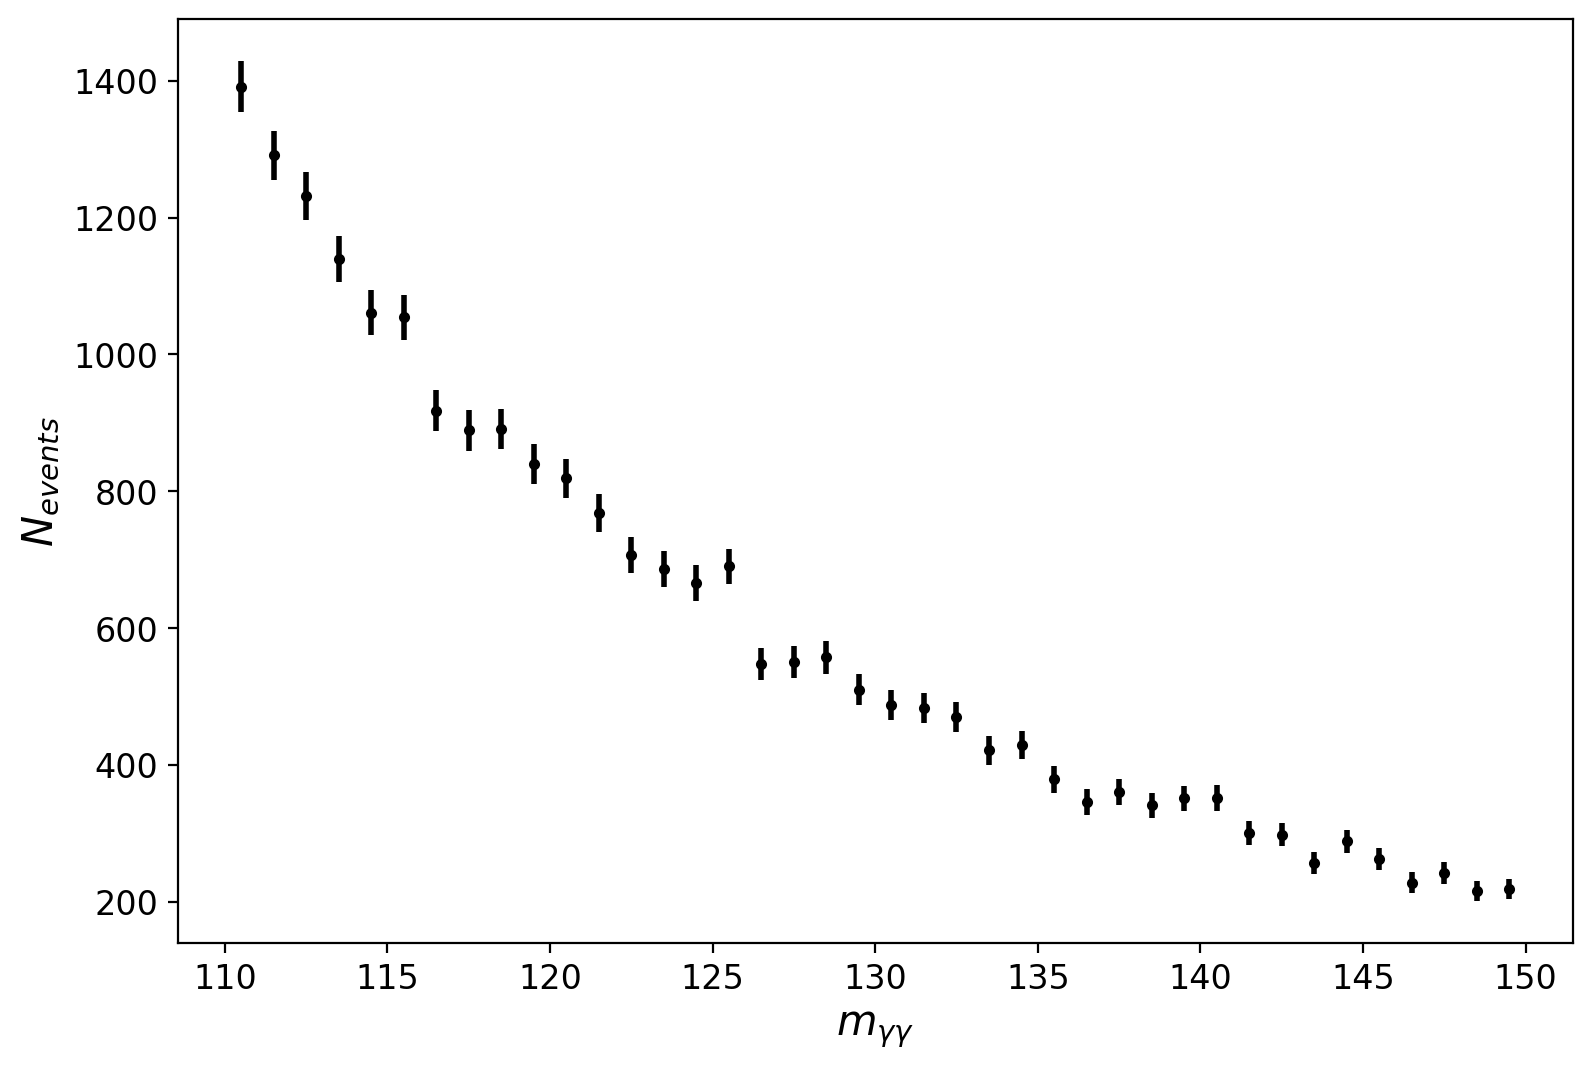

In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt

#Lets fit a bunch of polynomails with lmfit
x = []
y = []
y_err = []
label='data/out5.txt'
with open(label,'r') as csvfile:
    plots = csv.reader(csvfile, delimiter=' ')
    for row in plots:
        if float(row[1]) > 150 or float(row[1]) < 110:
            continue
        x.append(float(row[1]))
        y.append(float(row[2]))
        #add poisson uncertainties                                                                                                 
        y_err.append(np.sqrt(float(row[2])))

weights = np.linspace(0.,len(y),num=len(y))
for i0 in range(len(y)):
    weights[i0] = float(1./y_err[i0])

#Now we plot it. 
plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0)
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.show()

Ok, this is a falling distribution, its not obvious what to fit this with. Lets just fit it with a bunch of polynomial functions, and see how it works. 

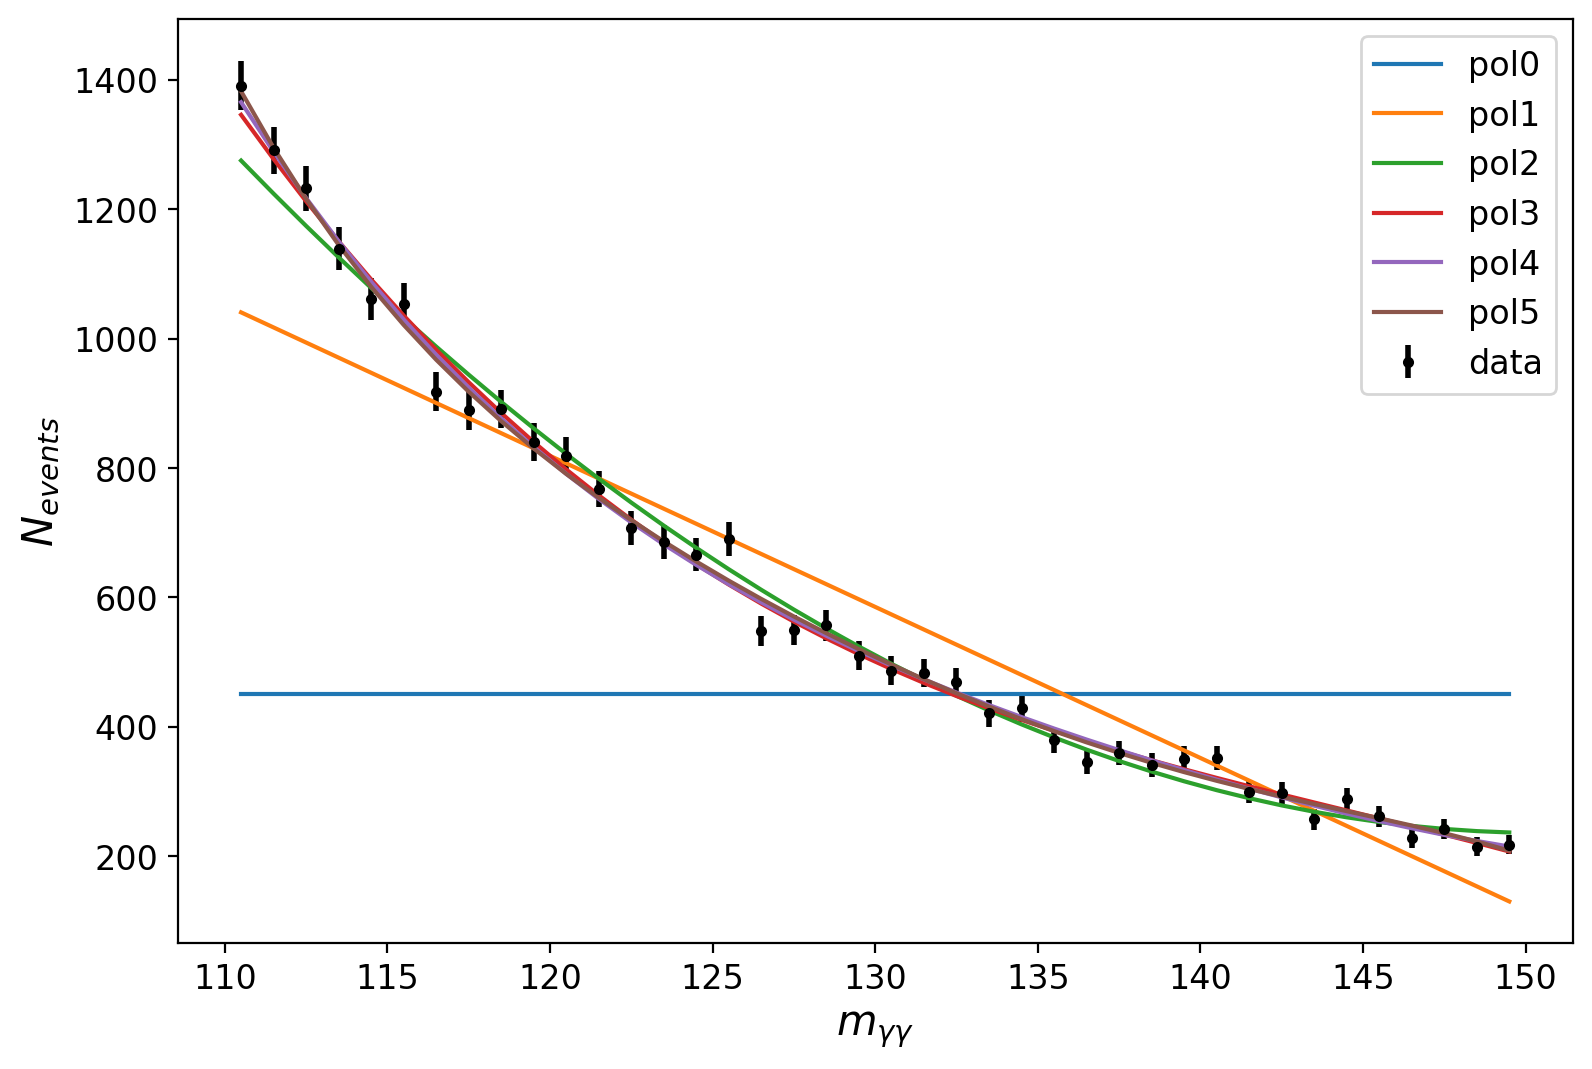

In [4]:
import lmfit 

def pol0(x,p0):
    pols=[p0]
    y = np.polyval(pols,x)
    return y

def pol1(x,p0,p1):
    pols=[p0,p1]
    y = np.polyval(pols,x)
    return y

def pol2(x, p0, p1,p2):
    pols=[p0,p1,p2]
    y = np.polyval(pols,x)
    return y

def pol3(x, p0, p1,p2,p3):
    pols=[p0,p1,p2,p3]
    y = np.polyval(pols,x)
    return y

def pol4(x, p0, p1,p2,p3,p4):
    pols=[p0,p1,p2,p3,p4]
    y = np.polyval(pols,x)
    return y

def pol5(x, p0, p1,p2,p3,p4,p5):
    pols=[p0,p1,p2,p3,p4,p5]
    y = np.polyval(pols,x)
    return y

def fitModel(iX,iY,iWeights,iFunc):
    model  = lmfit.Model(iFunc)
    p = model.make_params(p0=0,p1=0,p2=0,p3=0,p4=0,p5=0)
    result = model.fit(data=iY,params=p,x=iX,weights=iWeights)
    #result = lmfit.minimize(binnedLikelihood, params, args=(iX,iY,(iY**0.5),iFunc))
    output = model.eval(params=result.params,x=iX)
    return output

result0 = fitModel(x,y,weights,pol0)
result1 = fitModel(x,y,weights,pol1)
result2 = fitModel(x,y,weights,pol2)
result3 = fitModel(x,y,weights,pol3)
result4 = fitModel(x,y,weights,pol4)
result5 = fitModel(x,y,weights,pol5)

plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label="data")
plt.plot(x,result0,label="pol0")
plt.plot(x,result1,label="pol1")
plt.plot(x,result2,label="pol2")
plt.plot(x,result3,label="pol3")
plt.plot(x,result4,label="pol4")
plt.plot(x,result5,label="pol5")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

#res0.plot()
#result1.plot()
#result2.plot()
#result3.plot()
#result4.plot()
#result5.plot()

Let's look at one of the higher order polynomials. 

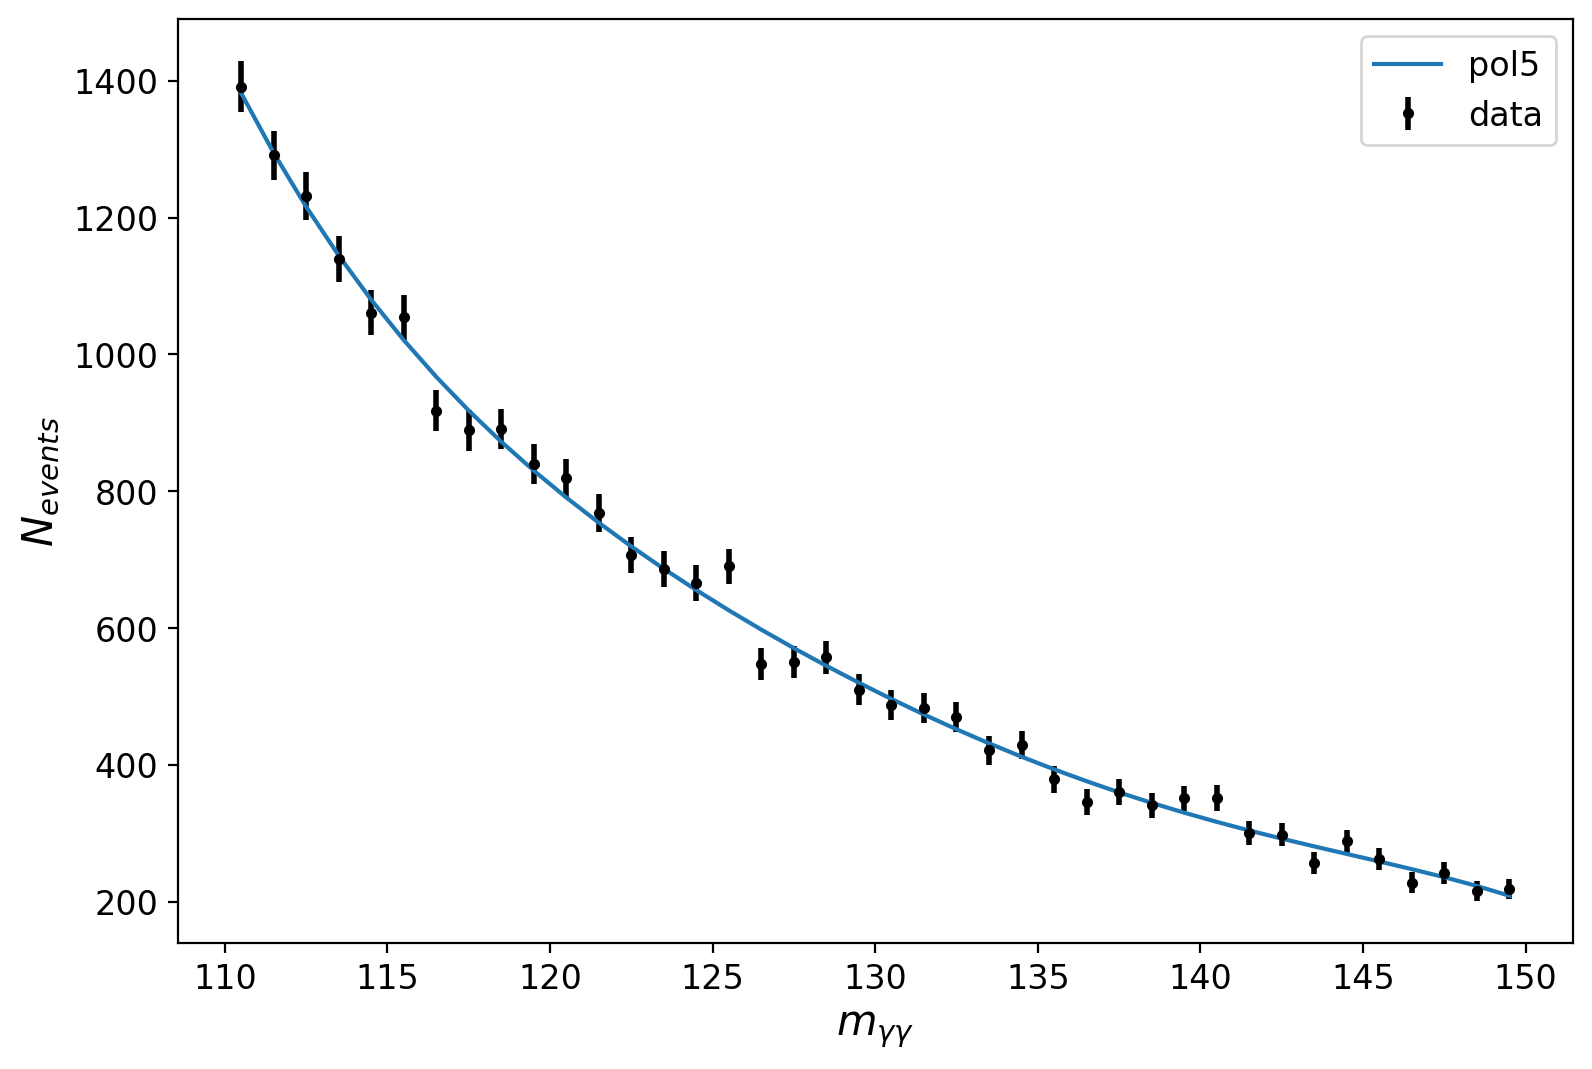

In [5]:
plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label="data")
plt.plot(x,result5,label="pol5")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

You can see its starting to pick up the fluctuations, if add even higher order polynomials, it will pick up even more fluctations. The f-test can tell us when we are adding too many polynomials. To see this, lets look at the residuals. 


Mean: 3.0953151007712 	STD: 11.77356739324426
Mean: 0.16270250218844964 	STD: 3.591162076611733
Mean: 0.020073638302971375 	STD: 0.937024291806045


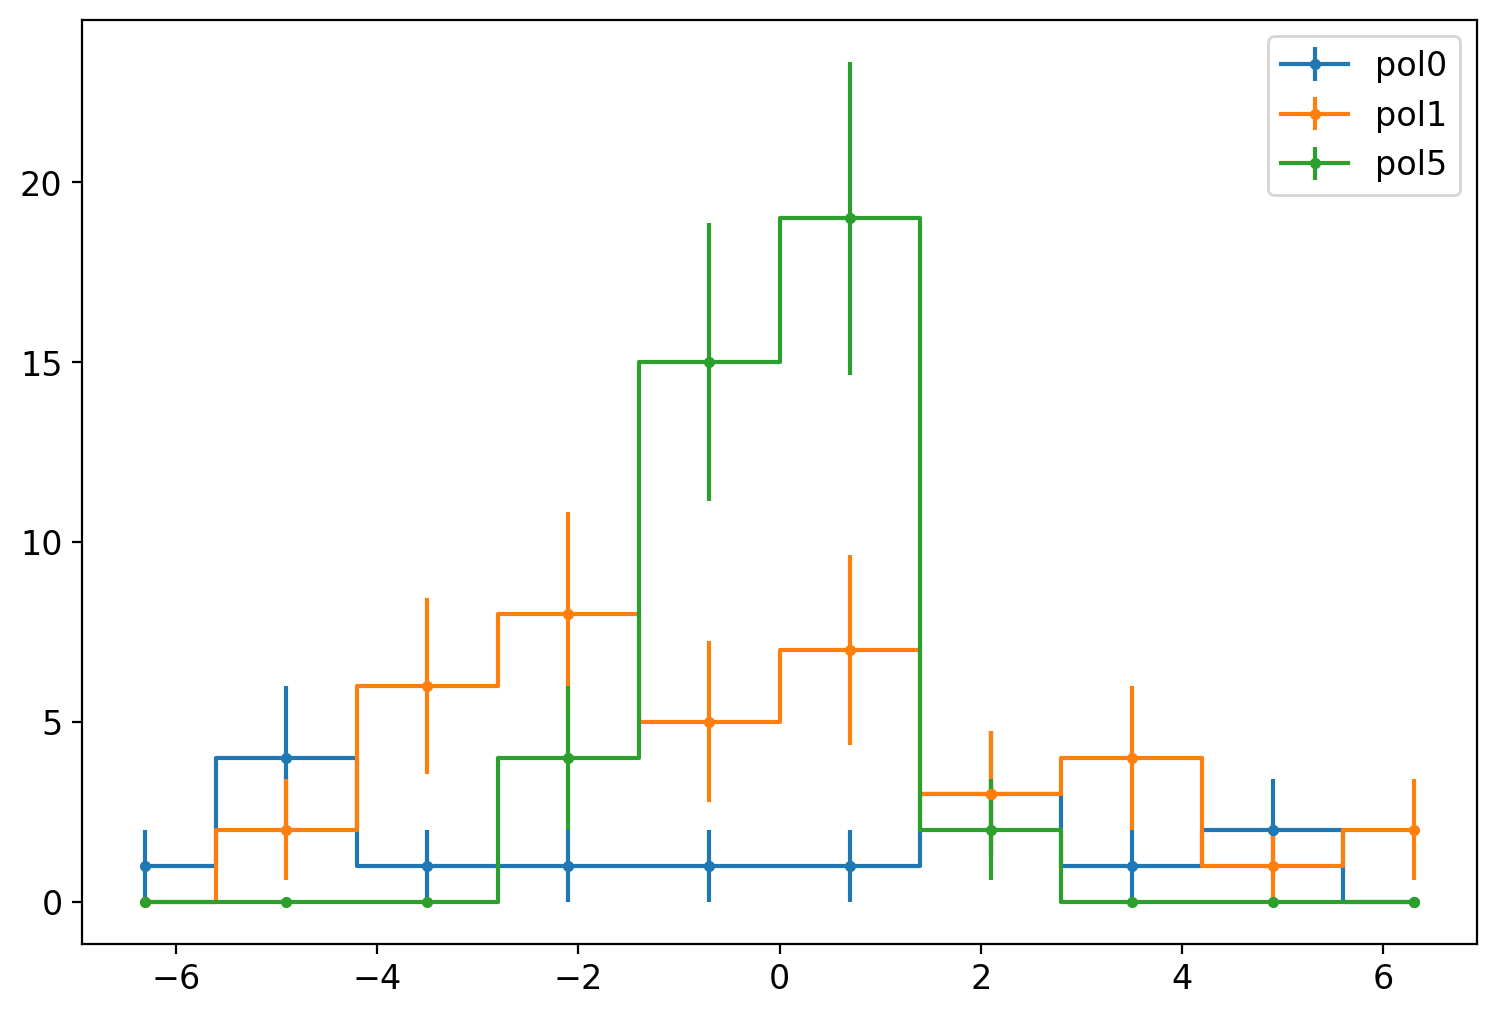

In [10]:
def residual(iY,iFunc,iYErr):
    resid = (iY-iFunc)/iYErr
    tmp_vals, tmp_bin_edges = np.histogram(resid, bins=10,range=[-7,7])
    tmp_bin_centers = 0.5*(tmp_bin_edges[1:] + tmp_bin_edges[:-1])
    print("Mean:",resid.mean(),"\tSTD:",resid.std())
    return tmp_bin_centers,tmp_vals

delta_p0,delta_y0 = residual(y,result0,y_err)
delta_p1,delta_y1 = residual(y,result1,y_err)
delta_p5,delta_y5 = residual(y,result5,y_err)
plt.errorbar(delta_p0,delta_y0,yerr=delta_y0**0.5,label="pol0",marker='.',drawstyle = 'steps-mid')
plt.errorbar(delta_p1,delta_y1,yerr=delta_y1**0.5,label="pol1",marker='.',drawstyle = 'steps-mid')
plt.errorbar(delta_p5,delta_y5,yerr=delta_y5**0.5,label="pol5",marker='.',drawstyle = 'steps-mid')
plt.legend()
plt.show()



So as we go to a higher order polynomial,we get to progressively smaller standard deviation. The issue is when do we stop. Lets now compute the f-statistic and compare it to our samples.  The f-statistic is defined at the ratio of the RMS distributions, we can write this as: 

\begin{equation}
 f = \frac{  \sigma^{2}_{\rm group} }{\sigma^{2}} \\
 \sigma^{2}_{\rm group} = \frac{ -\sum_{i=1}^{N} \left(y_{i}-f_{2}(x_{i})\right)^{2} + \sum_{i=1}^{N} \left(y_{i}- f_{1}(x_{i})\right)^{2}}{\Delta^{2\rightarrow 1}_{\rm dof}} \\
 \sigma^{2} = \frac{1}{N - n_{\rm f_{2}~dof} }\sum_{i=1}^{N} \left(y_{i}- f_{1}(x_{i})\right)^{2}
\end{equation}

or in other words the variation from a higher order polynomial to a lower order polynomial, should be smaller than the average variation of the residuals. This is the f-statistic. Let's compute the f-statistic for a few instances.

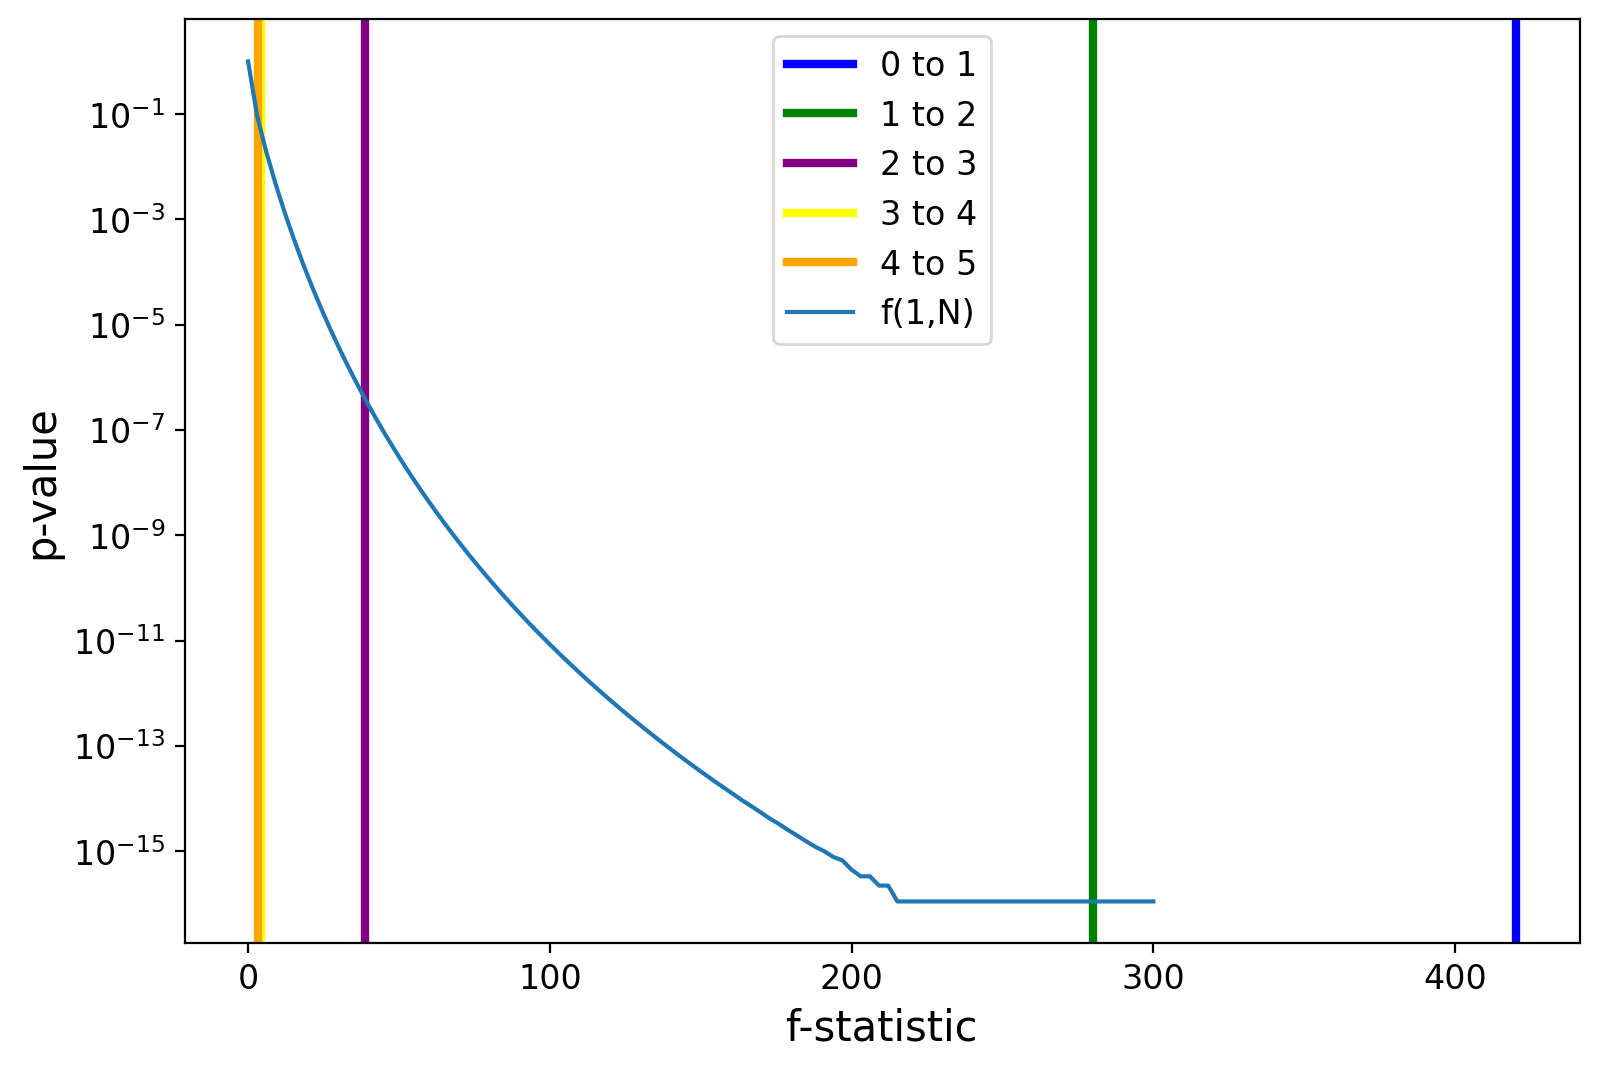

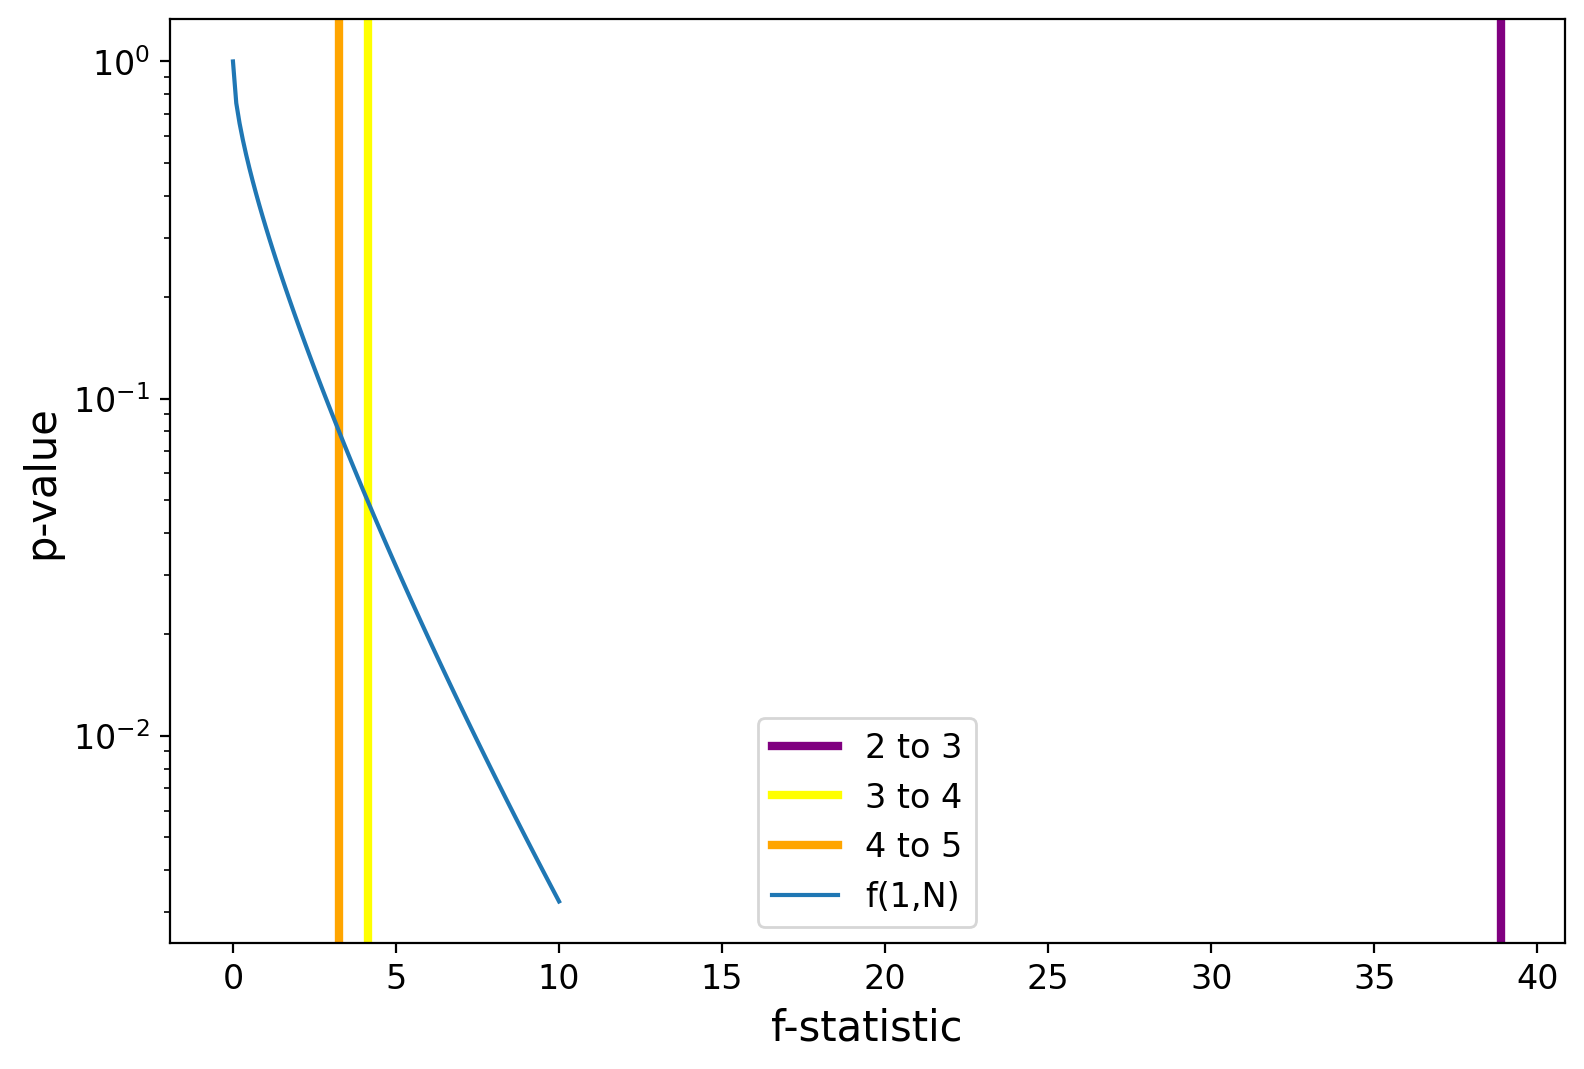

In [12]:
import scipy.stats as stats 

def residual2(iY,iFunc,iYErr):
    residval = (iY-iFunc)
    return np.sum(residval**2)
    
def ftest(iY,iYerr,f1,f2,ndof1,ndof2):
    r1=residual2(iY,f1,iYerr)
    r2=residual2(iY,f2,iYerr)
    sigma2group=(r1-r2)/(ndof2-ndof1)
    sigma2=r2/(len(y)-ndof2)
    return sigma2group/sigma2

f10=ftest(y,y_err,result0,result1,1,2)
f21=ftest(y,y_err,result1,result2,2,3)
f32=ftest(y,y_err,result2,result3,3,4)
f43=ftest(y,y_err,result3,result4,4,5)
f54=ftest(y,y_err,result4,result5,5,6)

xrange=np.linspace(0,300,100)
farr=1-stats.f.cdf(xrange,1,len(y)-5) #number of bins - 5 floating parameters
fig, ax = plt.subplots(figsize=(9,6))

ax.axvline(x=f10,linewidth=3,c='b',label='0 to 1')
ax.axvline(x=f21,linewidth=3,c='g',label='1 to 2')
ax.axvline(x=f32,linewidth=3,c='purple',label='2 to 3')
ax.axvline(x=f43,linewidth=3,c='yellow',label='3 to 4')
ax.axvline(x=f54,linewidth=3,c='orange',label='4 to 5')

ax.set_yscale('log')
plt.plot(xrange,farr,label='f(1,N)')
plt.legend()
plt.xlabel('f-statistic')
plt.ylabel('p-value')
plt.show()

xrange=np.linspace(0,10,100)
farr=1-stats.f.cdf(xrange,1,len(y)-5) 
fig, ax = plt.subplots(figsize=(9,6))
ax.axvline(x=f32,linewidth=3,c='purple',label='2 to 3')
ax.axvline(x=f43,linewidth=3,c='yellow',label='3 to 4')
ax.axvline(x=f54,linewidth=3,c='orange',label='4 to 5')
ax.set_yscale('log')
plt.xlabel('f-statistic')
plt.plot(xrange,farr,label='f(1,N)')
plt.ylabel('p-value')
plt.legend()
plt.show()

So, we see that large probabilities are present already in the 2 to 3 transition, which means that we likely only need a 2nd order polynomial. Let's check the $\chi^{2}$ value as well. 

Mean: 0.028406011251648666 	STD: 1.311884071233582 chi2 prob: 0.0011302772391219573
Normalized chi2: 1.861455911169326


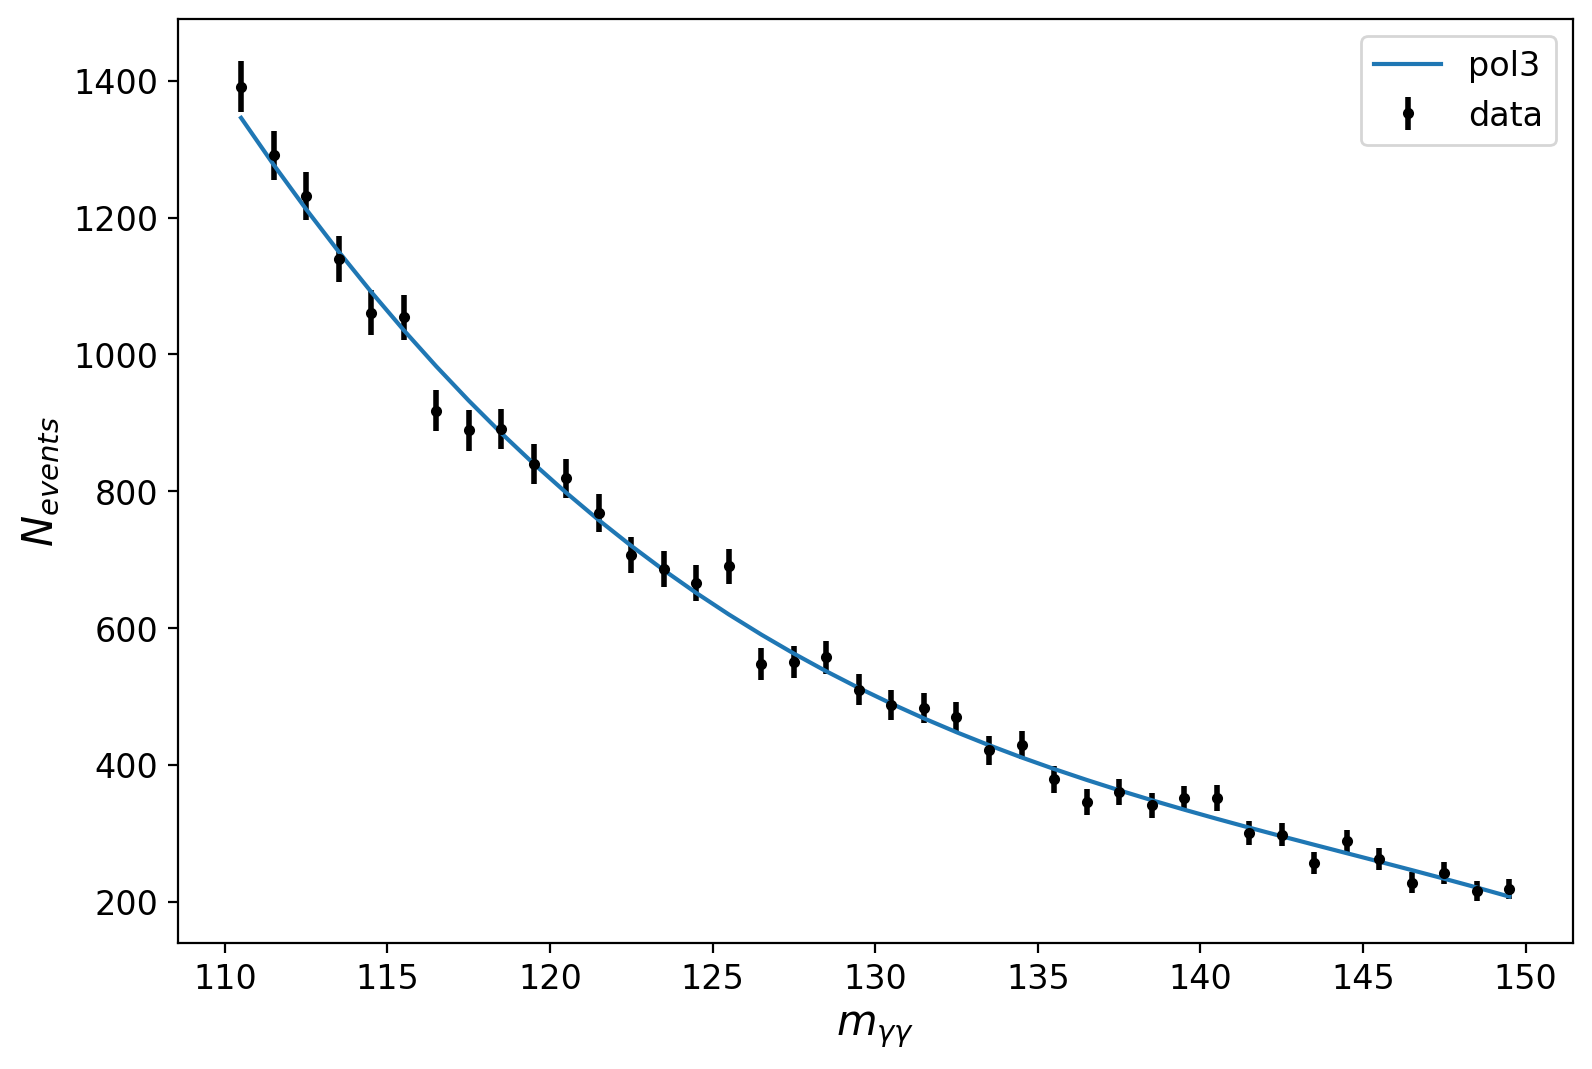

In [16]:
def chi2(iY,iFunc,iYErr,iNDOF):
    resid = (iY-iFunc)/iYErr
    chi2value = np.sum(resid**2)
    chi2prob=1-stats.chi2.cdf(chi2value,len(iY)-iNDOF)
    print("Mean:",resid.mean(),"\tSTD:",resid.std(),"chi2 prob:",chi2prob)
    return chi2value/(len(iY)-iNDOF)

chi2value=chi2(y,result2,y_err,3)
print("Normalized chi2:",chi2value)
plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label="data")
plt.plot(x,result3,label="pol3")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

Overall, this show the signs of a good fit.



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.3.1 </span>

Compare the $\chi^{2}$ probabilities of the fit? Could we have just done this with a $\chi^{2}$ test? 



In [17]:
chi2(y,result1,y_err,2)
chi2(y,result2,y_err,3)
chi2(y,result3,y_err,4)

Mean: 0.16270250218844964 	STD: 3.591162076611733 chi2 prob: 0.0
Mean: 0.028406011251648666 	STD: 1.311884071233582 chi2 prob: 0.0011302772391219573
Mean: 0.020867804142021183 	STD: 0.9834617013749073 chi2 prob: 0.3485047645975501


1.0751470925788194

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
chi2 is 0.22
</pre>
        
**EXPLANATION:**
    
Yes, in this instance, we see a pretty dramatic jump in the chi2 distribution of the data. However, we ahve to be careful, the f-test is testing something differnt, it is not testing when the chi2 agrees, its testing when adding more polynomials doesn't gain you any more info.    
</div>



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.3.2 </span>

Fit a gaussian distribution to a polynomial when does the f-test tell you to stop?


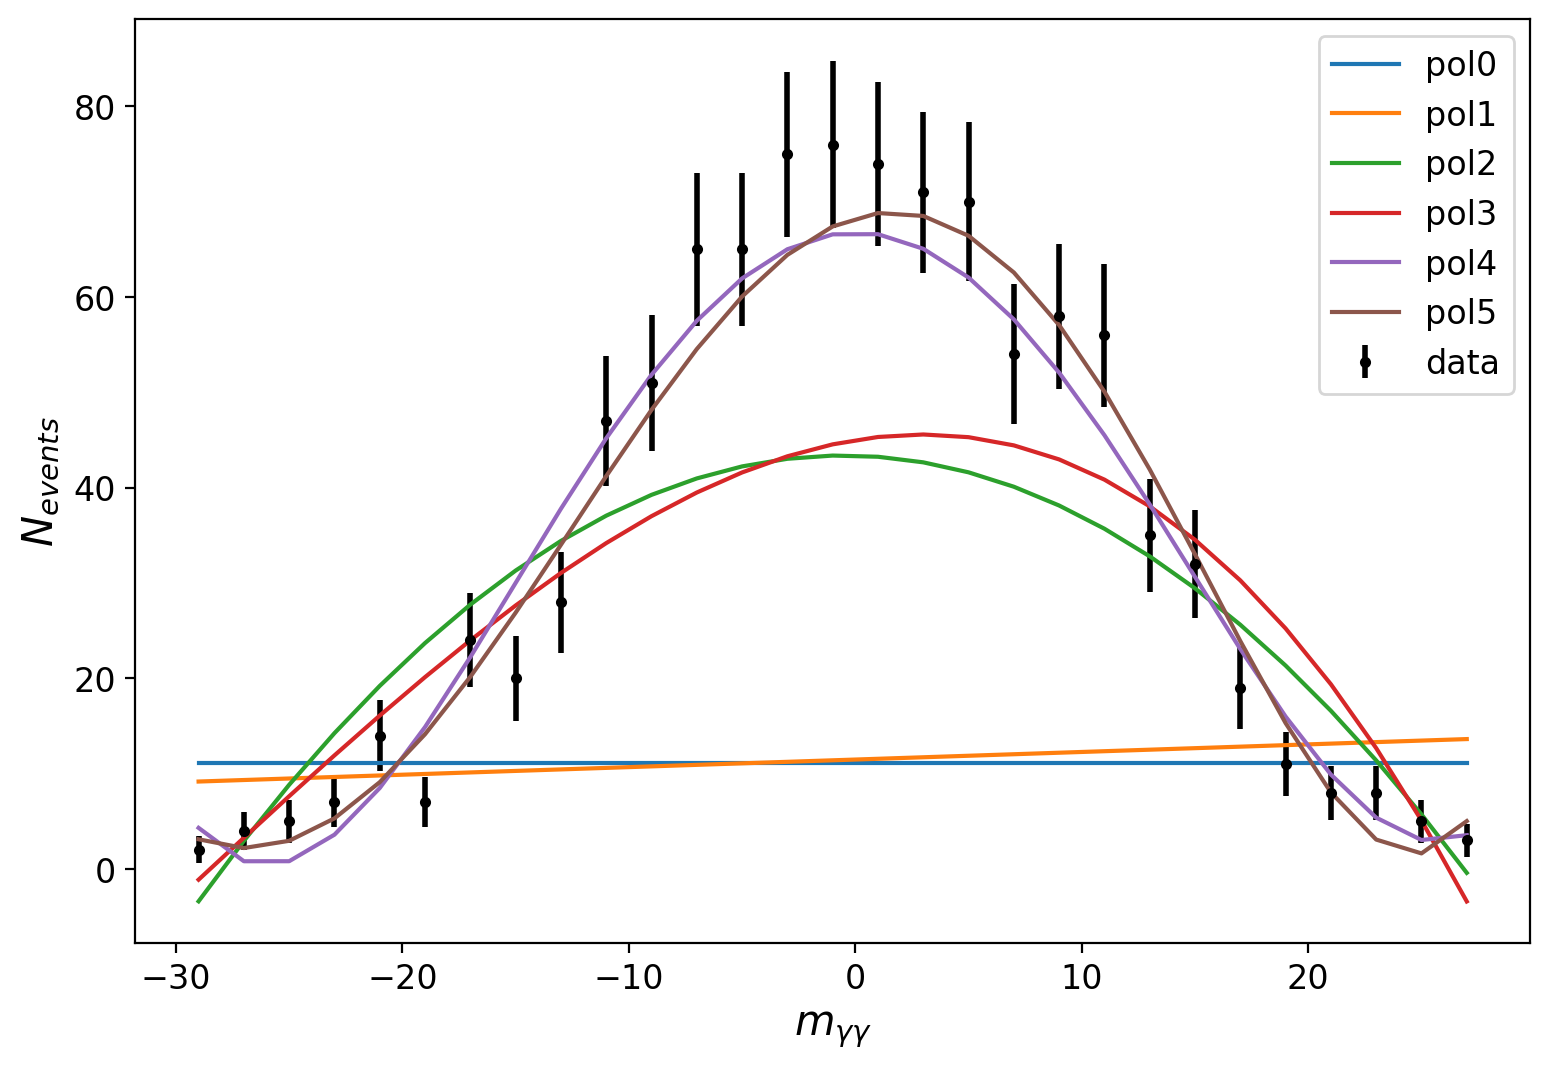

In [18]:
gausrandom = np.random.normal(0,10,1000)
y_test,bin_edges = np.histogram(gausrandom,bins=30,range=(-30,30))
x_test = 0.5*(bin_edges[1:] + bin_edges[:-1])

x_test = x_test[y_test > 0]
y_test = y_test[y_test > 0]
y_test_err = np.sqrt(y_test)
weights_test = 1./np.sqrt(y_test)

result0 = fitModel(x_test,y_test,weights_test,pol0)
result1 = fitModel(x_test,y_test,weights_test,pol1)
result2 = fitModel(x_test,y_test,weights_test,pol2)
result3 = fitModel(x_test,y_test,weights_test,pol3)
result4 = fitModel(x_test,y_test,weights_test,pol4)
result5 = fitModel(x_test,y_test,weights_test,pol5)

plt.errorbar(x_test,y_test,y_test_err, lw=2,fmt=".k", capsize=0,label="data")
plt.plot(x_test,result0,label="pol0")
plt.plot(x_test,result1,label="pol1")
plt.plot(x_test,result2,label="pol2")
plt.plot(x_test,result3,label="pol3")
plt.plot(x_test,result4,label="pol4")
plt.plot(x_test,result5,label="pol5")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

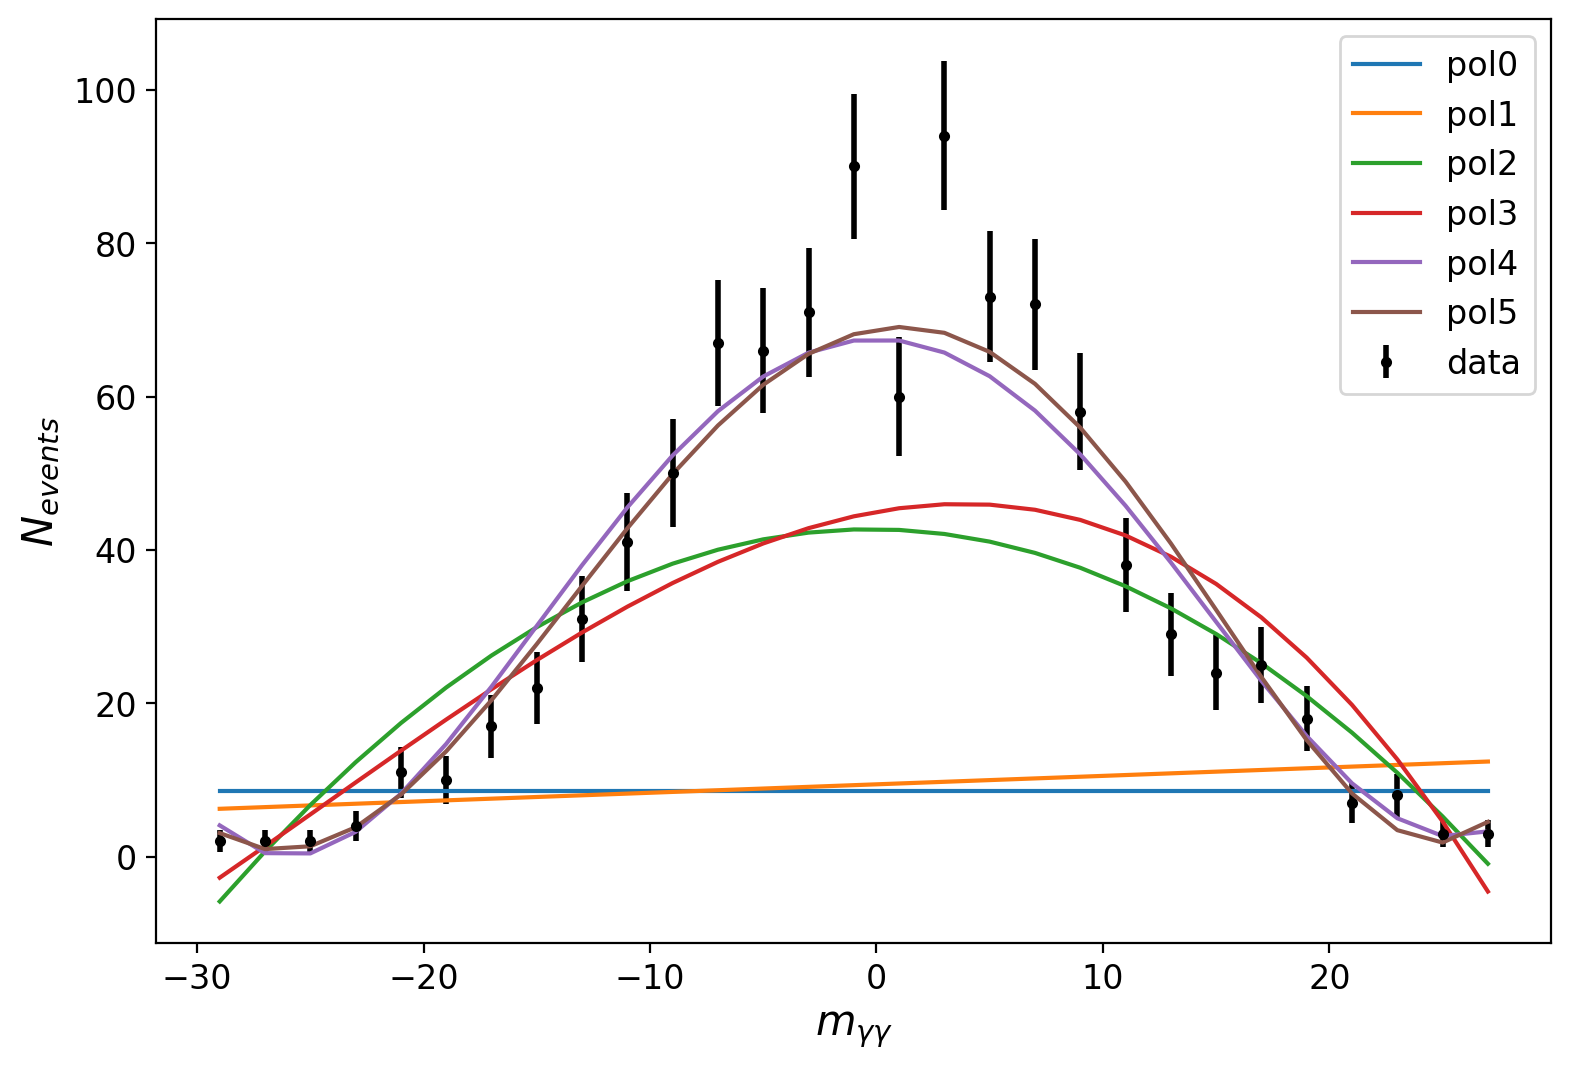

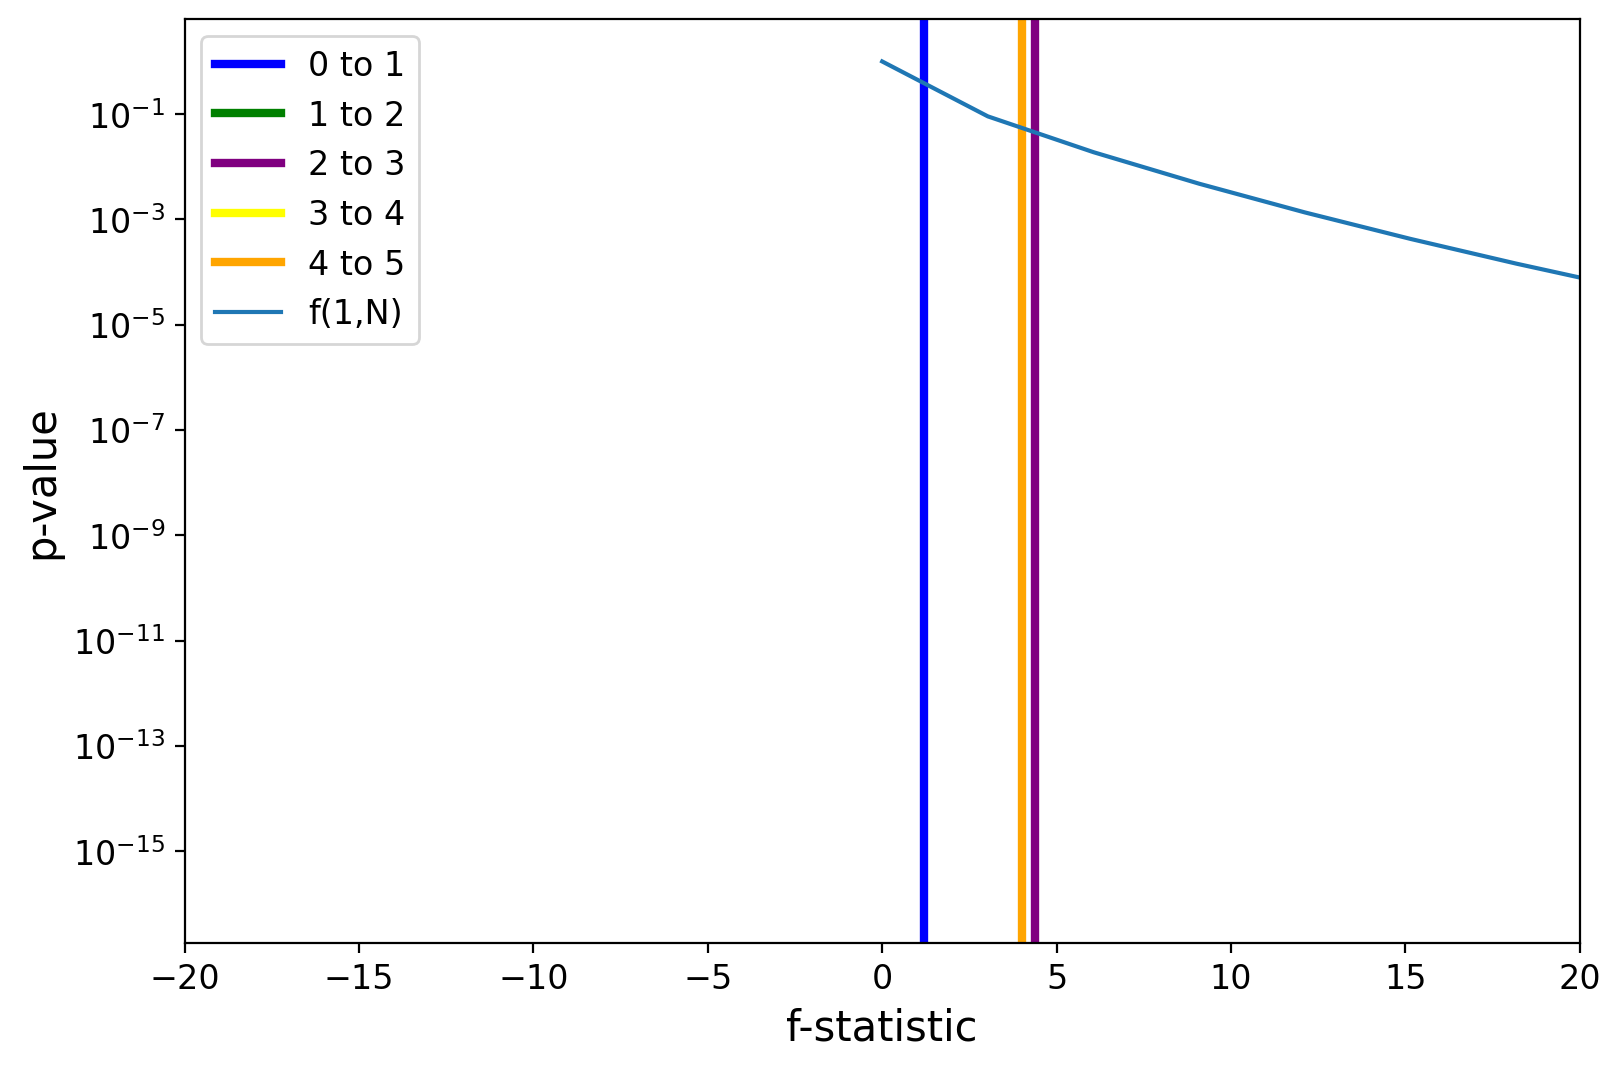

In [19]:
gausrandom = np.random.normal(0,10,1000)
y_test,bin_edges = np.histogram(gausrandom,bins=30,range=(-30,30))
x_test = 0.5*(bin_edges[1:] + bin_edges[:-1])

x_test = x_test[y_test > 0]
y_test = y_test[y_test > 0]
y_test_err = np.sqrt(y_test)
weights_test = 1./np.sqrt(y_test)

result0 = fitModel(x_test,y_test,weights_test,pol0)
result1 = fitModel(x_test,y_test,weights_test,pol1)
result2 = fitModel(x_test,y_test,weights_test,pol2)
result3 = fitModel(x_test,y_test,weights_test,pol3)
result4 = fitModel(x_test,y_test,weights_test,pol4)
result5 = fitModel(x_test,y_test,weights_test,pol5)

plt.errorbar(x_test,y_test,y_test_err, lw=2,fmt=".k", capsize=0,label="data")
plt.plot(x_test,result0,label="pol0")
plt.plot(x_test,result1,label="pol1")
plt.plot(x_test,result2,label="pol2")
plt.plot(x_test,result3,label="pol3")
plt.plot(x_test,result4,label="pol4")
plt.plot(x_test,result5,label="pol5")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()


f10=ftest(y_test,y_err,result0,result1,1,2)
f21=ftest(y_test,y_test_err,result1,result2,2,3)
f32=ftest(y_test,y_test_err,result2,result3,3,4)
f43=ftest(y_test,y_test_err,result3,result4,4,5)
f54=ftest(y_test,y_test_err,result4,result5,5,6)

xrange=np.linspace(0,300,100)
farr=1-stats.f.cdf(xrange,1,len(y)-5) 
fig, ax = plt.subplots(figsize=(9,6))

ax.axvline(x=f10,linewidth=3,c='b',label='0 to 1')
ax.axvline(x=f21,linewidth=3,c='g',label='1 to 2')
ax.axvline(x=f32,linewidth=3,c='purple',label='2 to 3')
ax.axvline(x=f43,linewidth=3,c='yellow',label='3 to 4')
ax.axvline(x=f54,linewidth=3,c='orange',label='4 to 5')
plt.xlim(-20,20)
ax.set_yscale('log')
plt.plot(xrange,farr,label='f(1,N)')
plt.legend()
plt.xlabel('f-statistic')
plt.ylabel('p-value')
plt.show()


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
2 to 3
</pre>
        
**EXPLANATION:**
The lowest one where the f-distribution is basically the same is the 2 to 3, you can see this in the fits. This very much seems fishy, do the next question. 
    
</div>



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.3.3 </span>

Now compute the $\chi^{2}$ of all of your fits, what do you conclude? 


In [20]:
chi2(y_test,result2,y_test_err,3)
chi2(y_test,result3,y_test_err,4)
chi2(y_test,result4,y_test_err,5)
chi2(y_test,result5,y_test_err,6)

Mean: 0.6376409430501941 	STD: 2.791204311105356 chi2 prob: 0.0
Mean: 0.5387765060656698 	STD: 2.626818349857473 chi2 prob: 0.0
Mean: 0.06949665386003985 	STD: 1.242947056628588 chi2 prob: 0.0059166361083163865
Mean: 0.07029820820523866 	STD: 1.1734887060610504 chi2 prob: 0.015060587462651376


1.7425439068939759

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
None of them are good
</pre>
        
**EXPLANATION:**
This is an improtant issue with the f-test. A lot of people like to automate this. However, this is not a replacement for the best fit likelihood or chi$^{2}$ distribution in the data. You need to stay alive for that. 
    
</div>



<a name='section_12_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.1 Fitting for the Higgs boson signal Background </h2>  



With all of these pieces together, I would like to compute the significance of the Higgs boson discovery in one of its main channels. To do this, we are going to use all of the tools that we have been going over. Let's first look at the data. For the Higgs boson data, there are 2 years of data each with 5 categories. Here is what all of them look like. 

In [21]:
import lmfit 

def pol0(x,p0):
    pols=[p0]
    y = np.polyval(pols,x)
    return y

def pol1(x,p0,p1):
    pols=[p0,p1]
    y = np.polyval(pols,x)
    return y

def pol2(x, p0, p1,p2):
    pols=[p0,p1,p2]
    y = np.polyval(pols,x)
    return y

def pol3(x, p0, p1,p2,p3):
    pols=[p0,p1,p2,p3]
    y = np.polyval(pols,x)
    return y

def pol4(x, p0, p1,p2,p3,p4):
    pols=[p0,p1,p2,p3,p4]
    y = np.polyval(pols,x)
    return y

def pol5(x, p0, p1,p2,p3,p4,p5):
    pols=[p0,p1,p2,p3,p4,p5]
    y = np.polyval(pols,x)
    return y

def fitModel(iX,iY,iWeights,iFunc):
    model  = lmfit.Model(iFunc)
    p = model.make_params(p0=0,p1=0,p2=0,p3=0,p4=0,p5=0)
    result = model.fit(data=iY,params=p,x=iX,weights=iWeights)
    #result = lmfit.minimize(binnedLikelihood, params, args=(iX,iY,(iY**0.5),iFunc))
    output = model.eval(params=result.params,x=iX)
    return output

import scipy.stats as stats 

def residual2(iY,iFunc,iYErr):
    residval = (iY-iFunc)
    return np.sum(residval**2)
    
def ftest(iY,iYerr,f1,f2,ndof1,ndof2):
    r1=residual2(iY,f1,iYerr)
    r2=residual2(iY,f2,iYerr)
    sigma2group=(r1-r2)/(ndof2-ndof1)
    sigma2=r2/(len(iY)-ndof2)
    return sigma2group/sigma2

def chi2(iY,iFunc,iYErr,iNDOF):
    resid = (iY-iFunc)/iYErr
    chi2value = np.sum(resid**2)
    chi2prob=1-stats.chi2.cdf(chi2value,len(iY)-iNDOF)
    print("Mean:",resid.mean(),"\tSTD:",resid.std(),"chi2 prob:",chi2prob)
    return chi2value/(len(iY)-iNDOF)


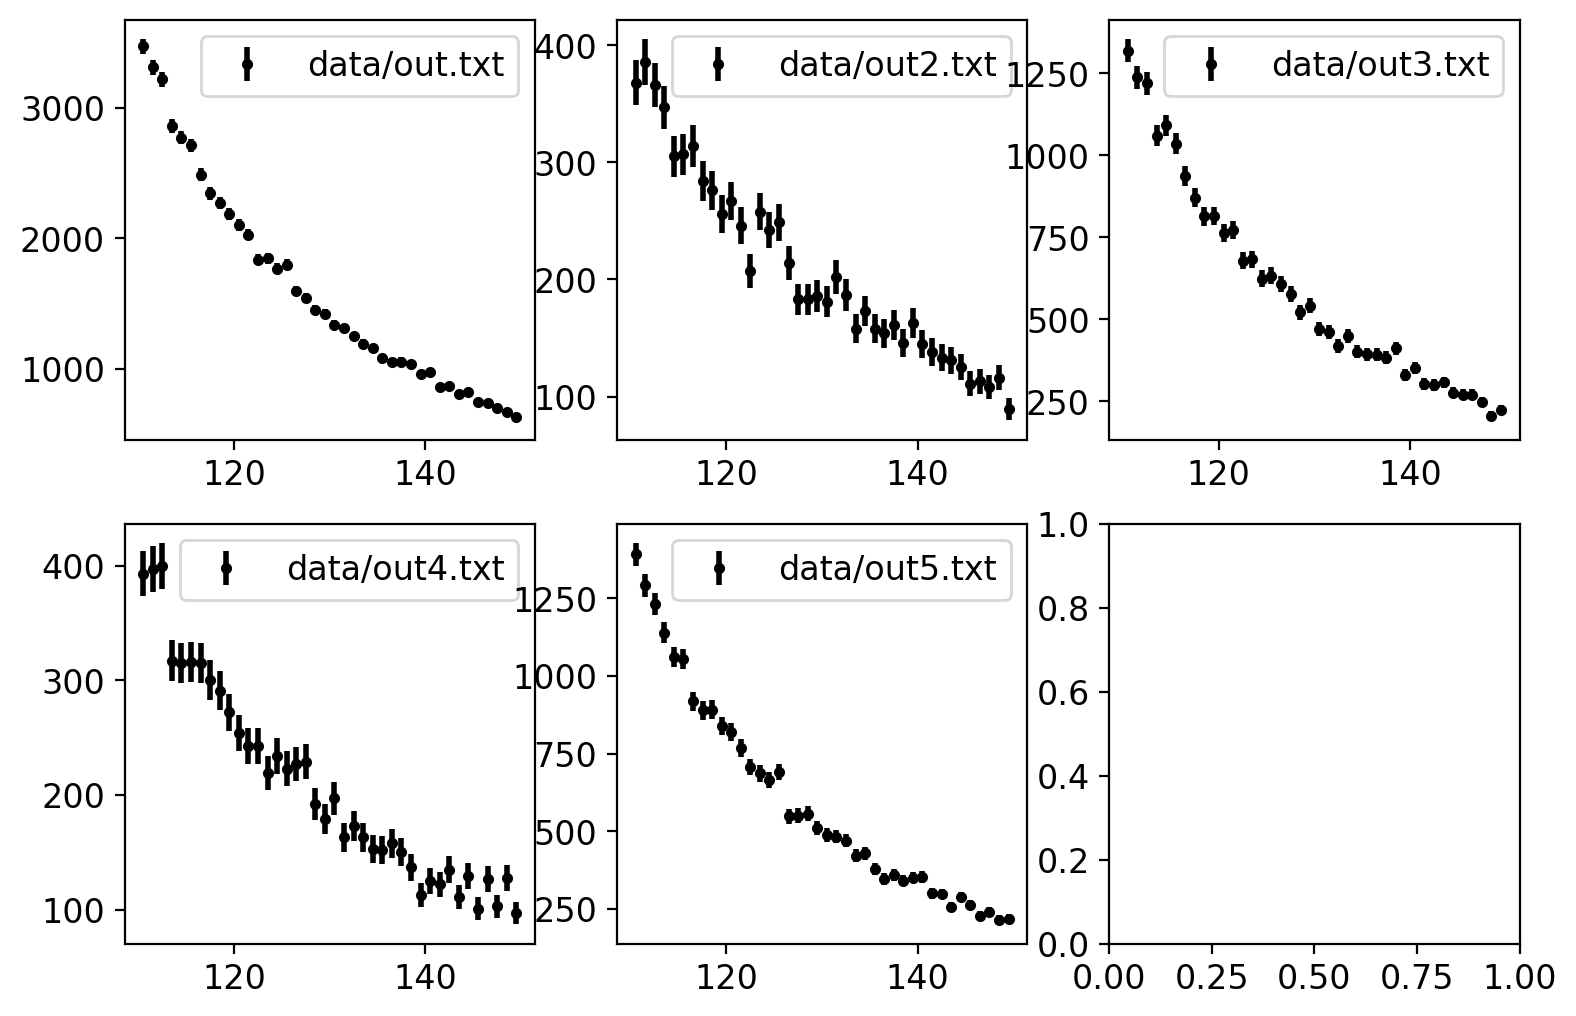

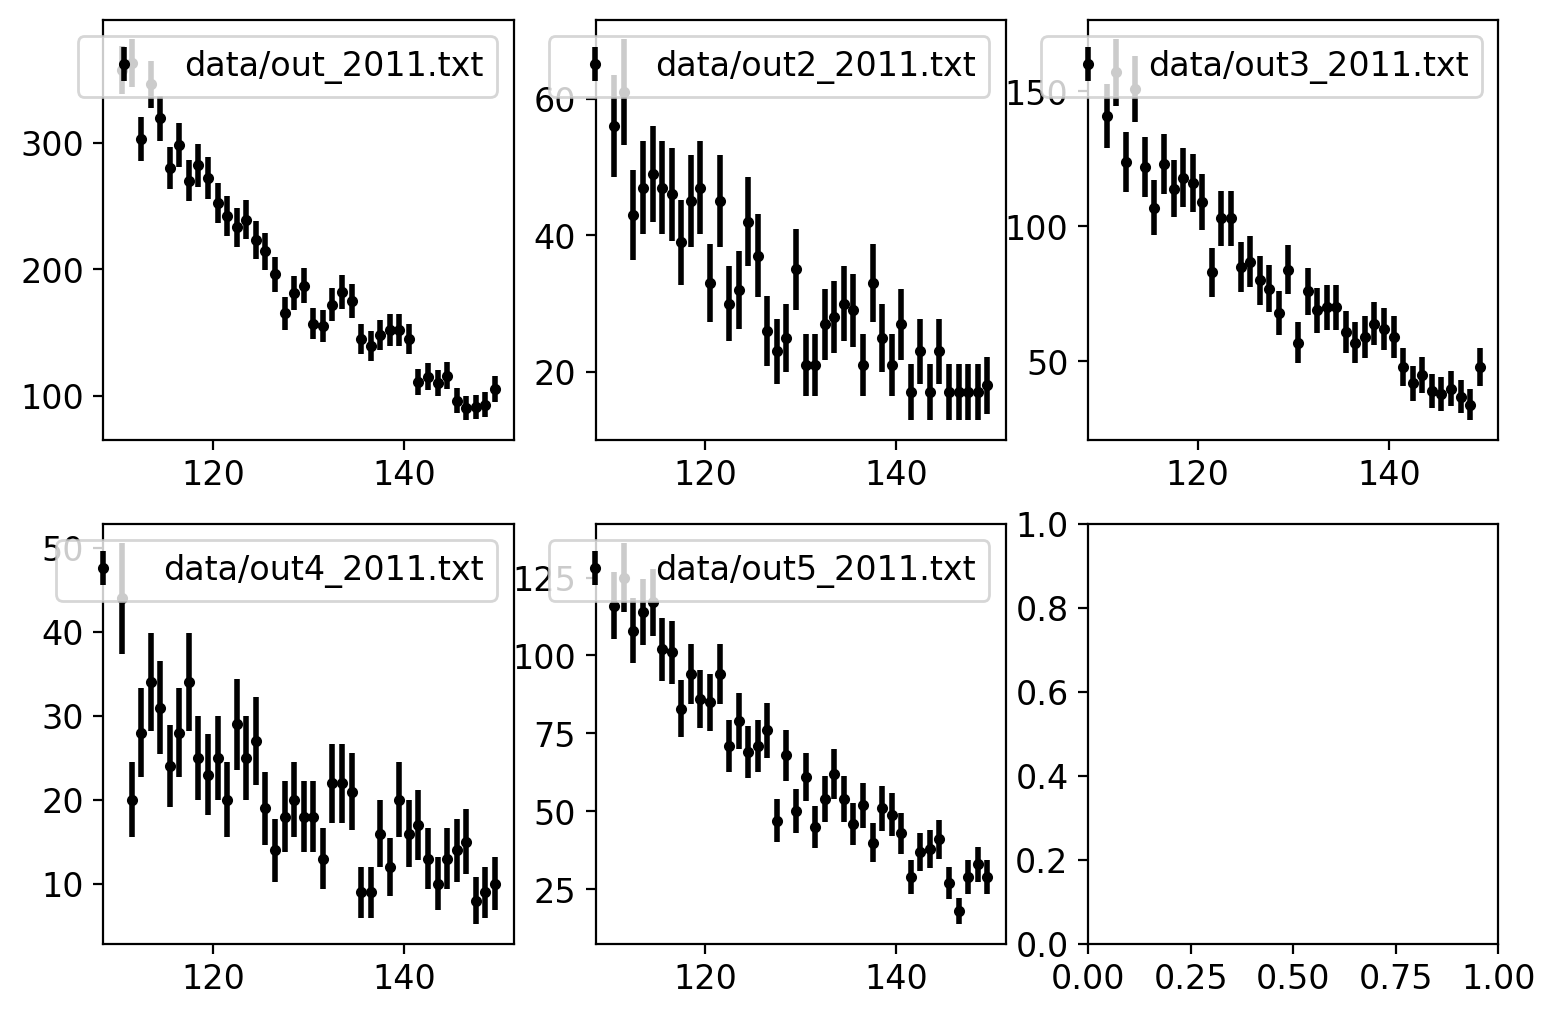

In [22]:
def load(iLabel,iRange=False):
    x = np.array([])
    y = np.array([])
    label=iLabel
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=' ')
        for row in plots:
            if not iRange and (float(row[1]) > 150 or float(row[1]) < 110):
                continue
            x = np.append(x,float(row[1]))
            y = np.append(y,float(row[2]))
            #add poisson uncertainties                                                                                                 
    weights = 1./y**0.5 
    return x,y,y**0.5,weights

def plot(ax,iLabel):
    x,y,y_err,weights=load(iLabel)
    #Now we plot it. 
    ax.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label=iLabel)
    #ax.x_label("$m_{\gamma\gamma}$")
    #ax.y_label("$N_{events}$")
    ax.legend()
    #ax.show()
    
fig, axs = plt.subplots(2, 3)
#2012 data    
plot(axs[0,0],"data/out.txt")
plot(axs[0,1],"data/out2.txt")
plot(axs[0,2],"data/out3.txt")
plot(axs[1,0],"data/out4.txt")
plot(axs[1,1],"data/out5.txt")
plt.show()

fig, axs = plt.subplots(2, 3)
#2011 data    
plot(axs[0,0],"data/out_2011.txt")
plot(axs[0,1],"data/out2_2011.txt")
plot(axs[0,2],"data/out3_2011.txt")
plot(axs[1,0],"data/out4_2011.txt")
plot(axs[1,1],"data/out5_2011.txt")

As you can see, from the above plots, there are way more points in the 2012 data. Lets take the category with the largest number of points, and perform an f-test on it, we can neglect the signal for now, but we will get back to that in a sec.  

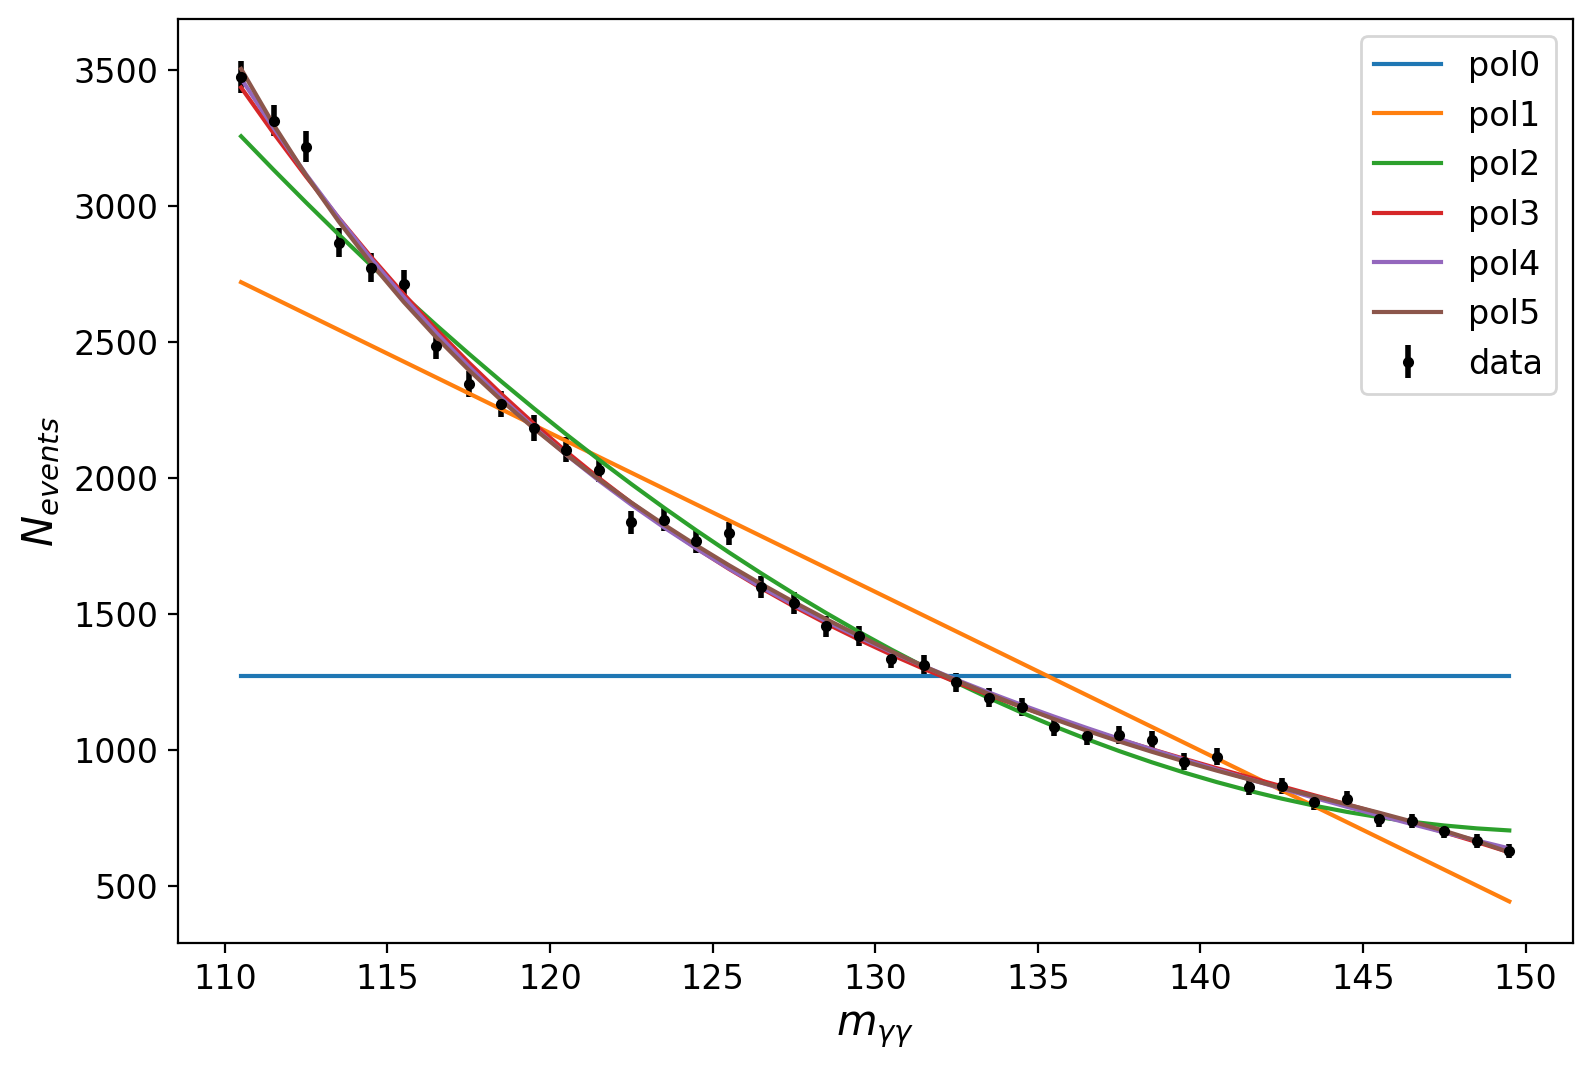

f 1 to 0: 1.1102230246251565e-16
f 2 to 1: 1.1102230246251565e-16
f 3 to 2: 1.0090073221391549e-10
f 4 to 3: 0.04897029186418689
f 5 to 4: 0.07983871564723133


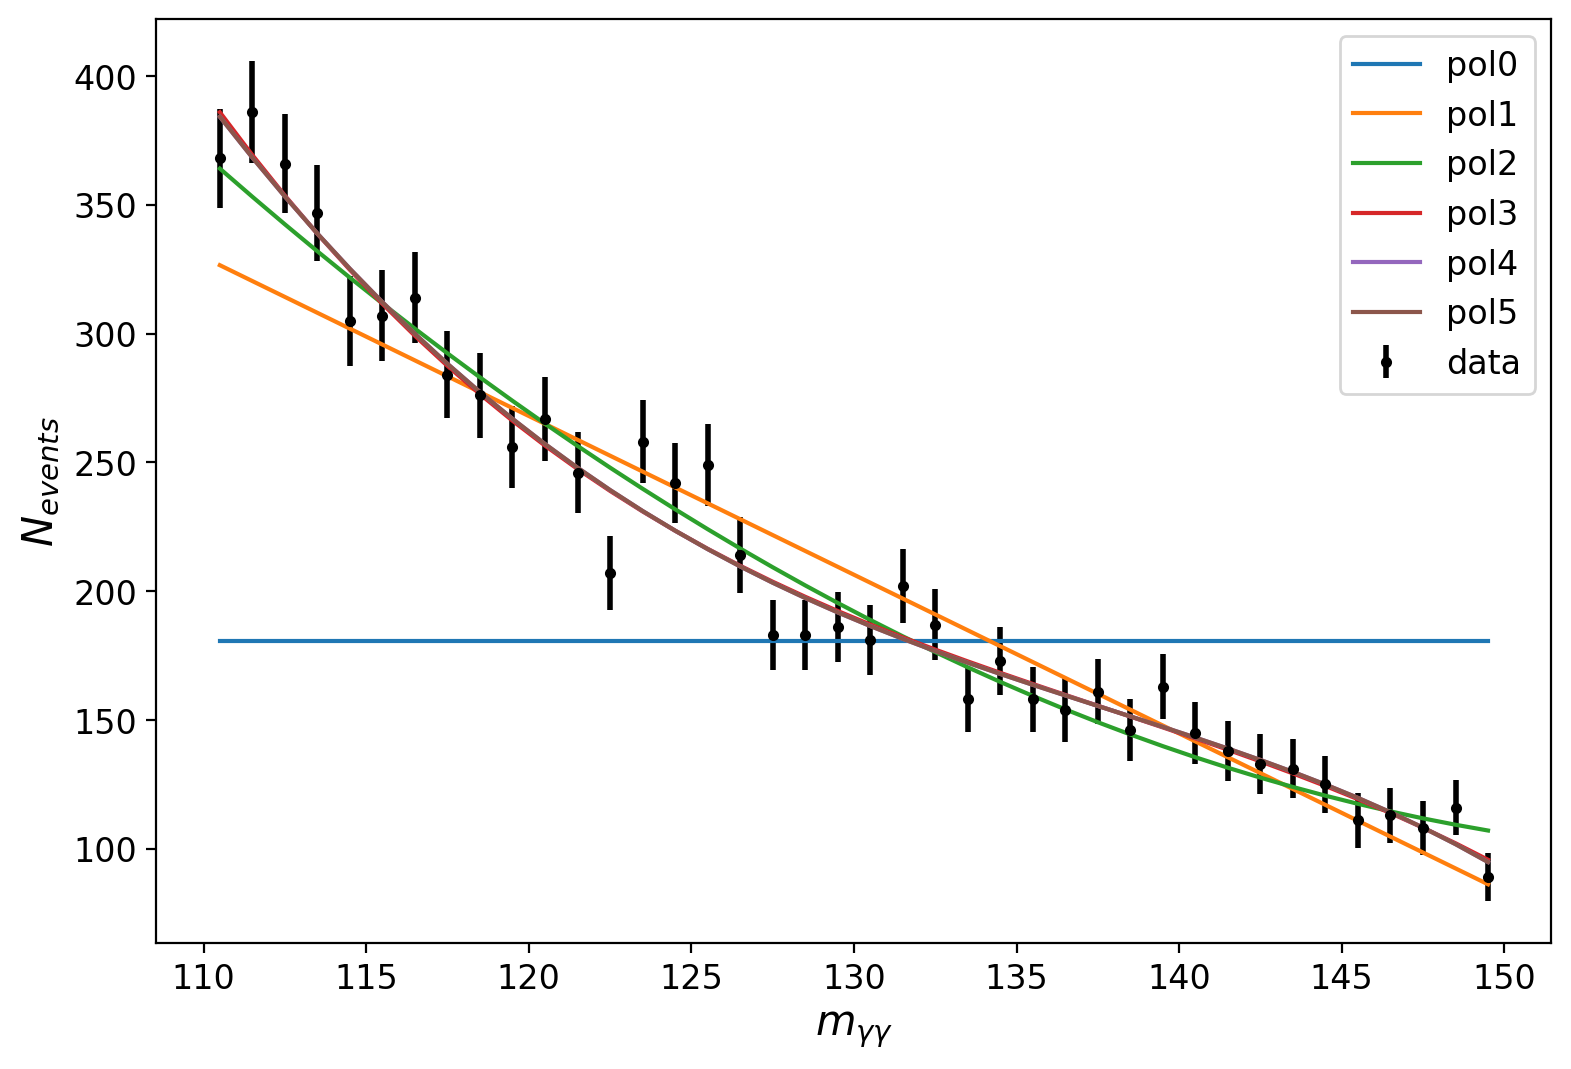

f 1 to 0: 1.1102230246251565e-16
f 2 to 1: 4.9372434141048416e-08
f 3 to 2: 0.0035138407452814935
f 4 to 3: 0.8546368491590365
f 5 to 4: 0.9749828674119615


In [23]:
def fitAll(iLabel,iPlot=False):
    x,y,y_err,weights=load(iLabel)
    result0 = fitModel(x,y,weights,pol0)
    result1 = fitModel(x,y,weights,pol1)
    result2 = fitModel(x,y,weights,pol2)
    result3 = fitModel(x,y,weights,pol3)
    result4 = fitModel(x,y,weights,pol4)
    result5 = fitModel(x,y,weights,pol5)

    if iPlot:
        plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label="data")
        plt.plot(x,result0,label="pol0")
        plt.plot(x,result1,label="pol1")
        plt.plot(x,result2,label="pol2")
        plt.plot(x,result3,label="pol3")
        plt.plot(x,result4,label="pol4")
        plt.plot(x,result5,label="pol5")
        plt.xlabel("$m_{\gamma\gamma}$")
        plt.ylabel("$N_{events}$")
        plt.legend()
        plt.show()
    return x,y,y_err,result0,result1,result2,result3,result4,result5

def ftestAll(iLabel):
    x,y,y_err,result0,result1,result2,result3,result4,result5=fitAll(iLabel)
    f10=ftest(y,y_err,result0,result1,1,2)
    f21=ftest(y,y_err,result1,result2,2,3)
    f32=ftest(y,y_err,result2,result3,3,4)
    f43=ftest(y,y_err,result3,result4,4,5)
    f54=ftest(y,y_err,result4,result5,5,6)
    print("f 1 to 0:",1-stats.f.cdf(f10,1,len(y)-1))
    print("f 2 to 1:",1-stats.f.cdf(f21,1,len(y)-2))
    print("f 3 to 2:",1-stats.f.cdf(f32,1,len(y)-3))
    print("f 4 to 3:",1-stats.f.cdf(f43,1,len(y)-4))
    print("f 5 to 4:",1-stats.f.cdf(f54,1,len(y)-5))
    
fitAll("data/out.txt",True)
ftestAll("data/out.txt")

fitAll("data/out2.txt",True)
ftestAll("data/out2.txt")

So from this looks like a 4th order polynomial gives an f-test above roughly 5% for both the category with the largest yield and the second largest yield. This seems reaonsable for us to use as our background function. Let's proceed with a signal function. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.1.1 </span>

When we searched for the Higgs boson, we did this blind. What that means is we did look at the plots of the fits. However, we did do f-tests, and even $\chi^{2}$ goodness of fit tests. Knowing f-tests are good compute the $\chi^{2}$ of the best fit for the above. 



In [ ]:
def chi2testAll(iLabel):
    x,y,y_err,result0,result1,result2,result3,result4,result5=fitAll(iLabel)
    ###Now we test the chi2
    chi2(y,result0,y_err,1)


In [24]:

def chi2testAll(iLabel):
    x,y,y_err,result0,result1,result2,result3,result4,result5=fitAll(iLabel)
    ###Now we test the chi2
    chi2(y,result0,y_err,1)
    chi2(y,result1,y_err,2)
    chi2(y,result2,y_err,3)
    chi2(y,result3,y_err,4)
    chi2(y,result4,y_err,5)
    chi2(y,result5,y_err,6)

chi2testAll("data/out.txt")

Mean: 4.21387638786741 	STD: 17.765714486207152 chi2 prob: 0.0
Mean: 0.1917170321272086 	STD: 5.043617204965229 chi2 prob: 0.0
Mean: 0.024312853377889687 	STD: 1.6740897250876112 chi2 prob: 1.7216746917014802e-09
Mean: 0.010249522177507103 	STD: 0.9495802617148658 chi2 prob: 0.46526713803735364
Mean: 0.010299433815906766 	STD: 0.9184503662653373 chi2 prob: 0.5285587877741877
Mean: 0.009600357697371192 	STD: 0.8817918186256064 chi2 prob: 0.6102212328809923


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
The chi2 is already good 
</pre>
        
**EXPLANATION:**
These sort of fits, we call **background only** all have a good quality of fit, and the f-test gives us different information. For signals like this where the background fraction is small, these sort of tests can be done by just looking to see if the chi2 background only fit is good. 
    
</div>



### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.1.2</span>

If the signal is large why would this be a form of unblinding (ie a seeing about our signal signfiicance before we look at the data)?


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
Yes
</pre>
        
**EXPLANATION:**
When you are looking for a large signal with high purity, and you are doing a blind analysis, you have to be careful to only look at the signal region or any indicator like the $\chi^{2}$ goodness of fit when you are read to start looking at the signal. 
    
</div>



<a name='section_12_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.2 Fitting for the Higgs boson signal Background </h2>  



Now, to fit a Higgs signal, what we want to do is a hypothesis test like we did above. Except now, we will cast our hypothesis, slightly differently to before. 

**Null Hypothesis** The Higgs signal is not there. 

**Alternative Hypothesis** The Higgs signal has a mass of $m_{\gamma\gamma}$ at a specific $m_{0}$, and a fixed width 1.2 GeV. 

The reason for the fixed width is that we know the Higgs width from our prediction of the Higgs (is 4 MeV), we also know the detector resolution by measuring photons in the experiment at other regions. In this case, we actually use $Z\rightarrow ee$ where the electrons are treated as photons. 

Also, in this case, we are going to fix the mass at 125 GeV, that way the only variable we are floating is the amplitude, and the significance we can quote by taking 2 $\Delta\log(\mathcal{L})$ and noting this should follow a $\chi^{2}_{1}$ distribution with 1 degree of freedom.

As a reminder the sum of the residual squares is -2NLL already because

\begin{eqnarray}
 \mathcal{L}(\theta_{i} | x_{i},y_{i}) & = & \prod_{i=0}^{N}\frac{1}{\sqrt{2\pi\sigma_{i}^{2}}}\exp\left(-\sum_{i=0}^{N} \frac{(y_{i}-f(x_{i})^2}{2\sigma_{i}^{2}}\right) \\
 \log\left(\mathcal{L}(\theta_{i} | x_{i},y_{i})\right) & = &  -\sum_{i=0}^{n}\log\left(2\pi\sigma_{i}^{2}\right) - \sum_{i=0}^{N} \frac{(y_{i}-f(x_{i}|\theta_{i}))^2}{2\sigma_{i}^{2}} \\
  \log\left(\mathcal{L}(\theta_{i} | x_{i},y_{i})\right) & = &  -\rm{Constant} - \sum_{i=0}^{N} \frac{\rm{residual}_{i}^2}{2}\\
    -2\log\left(\mathcal{L}(\theta_{i} | x_{i},y_{i})\right) & \equiv &  \sum_{i=0}^{N} \rm{residual}_{i}^2\\
\end{eqnarray}

The residuals squared are thus -2NLL


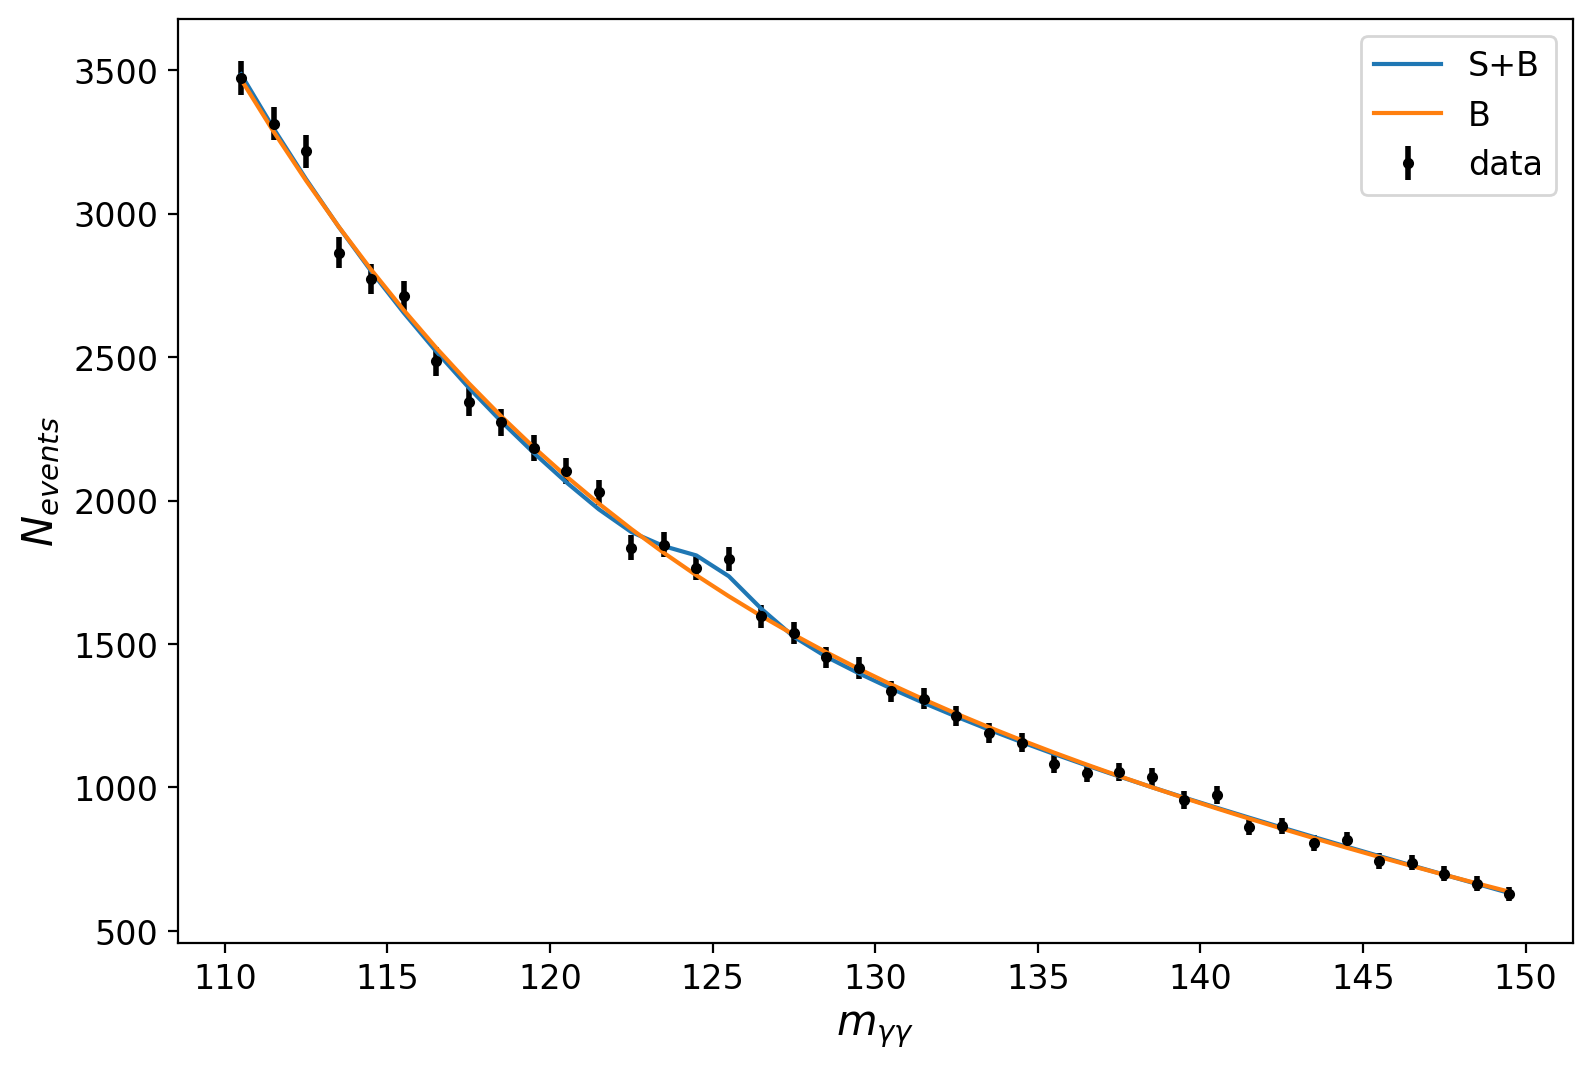

2NLL: 8.213184358916976 p-value 0.004158710550913658 z-score 2.6389053021505826


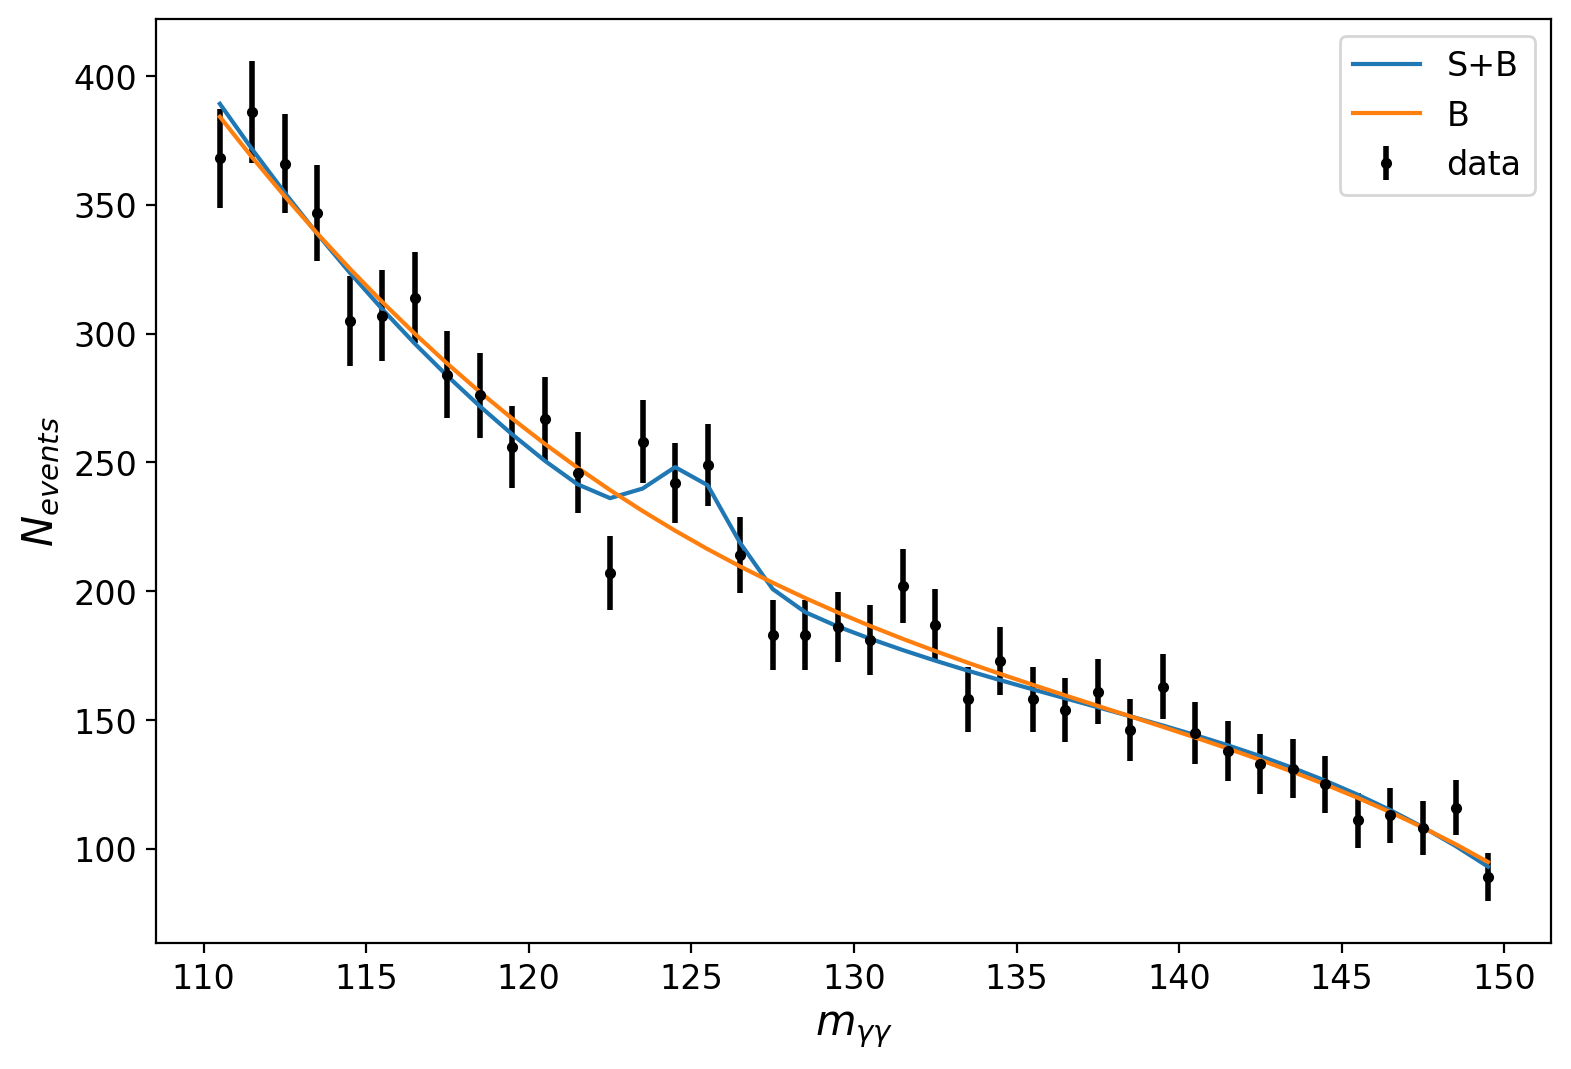

2NLL: 7.483846869878974 p-value 0.006225492453245107 z-score 2.49909807042433


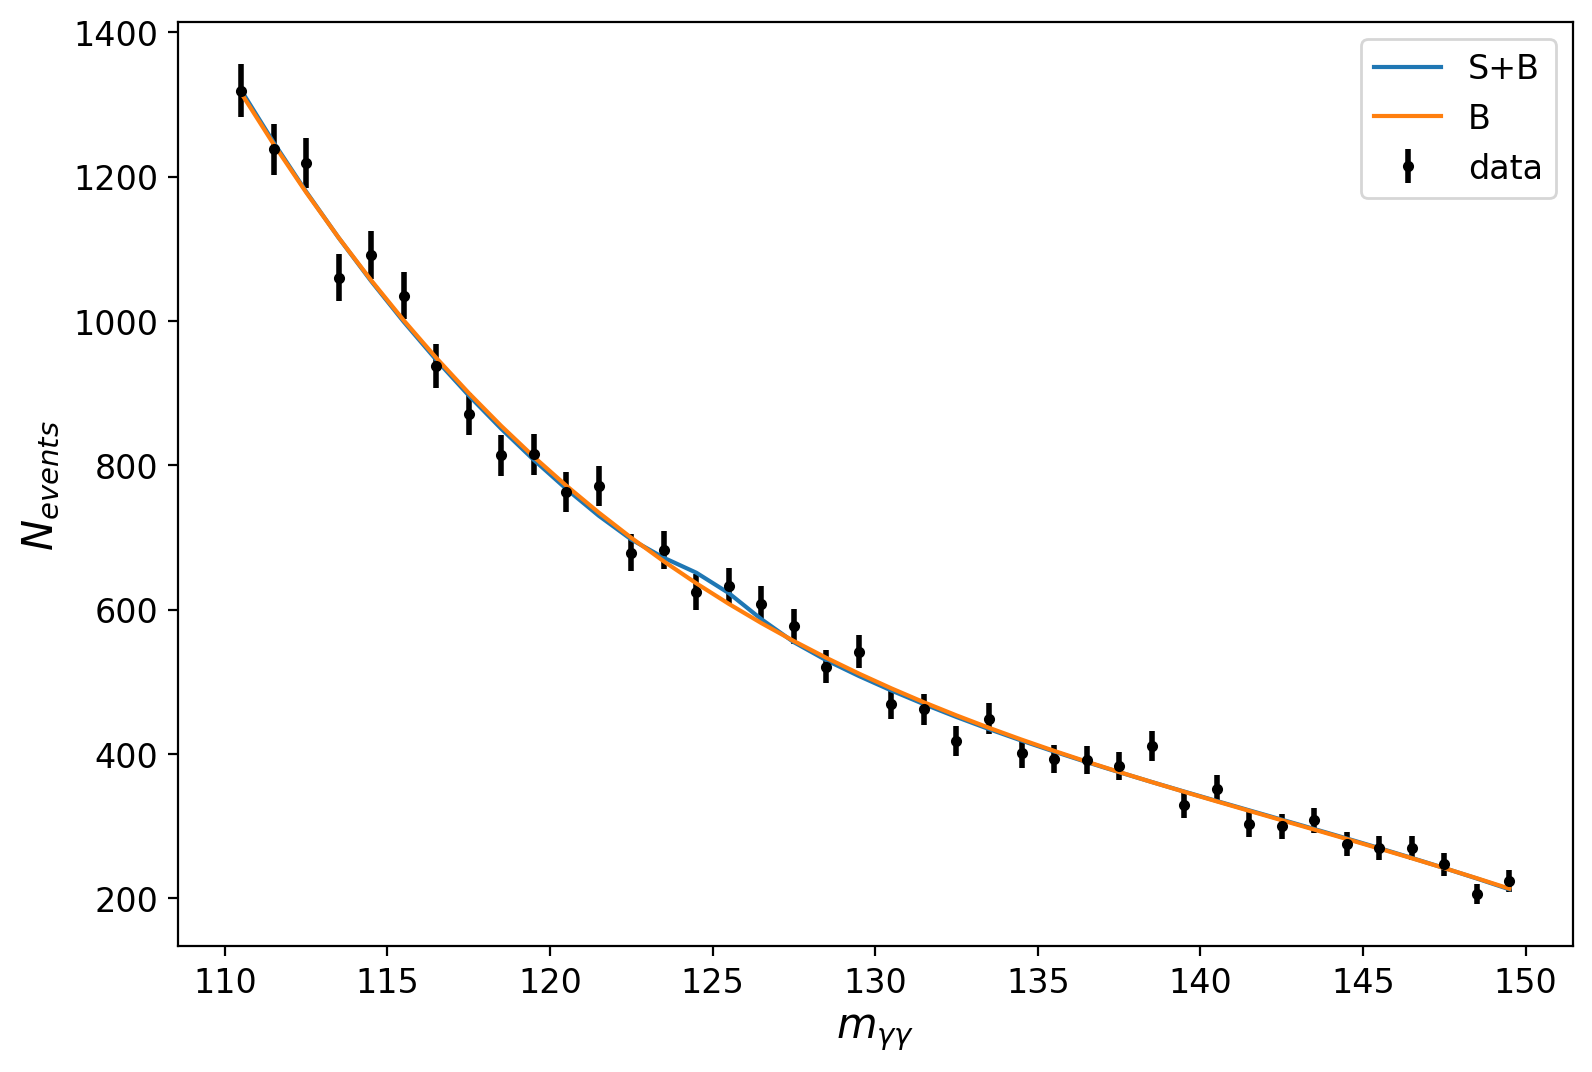

2NLL: 1.0484335987044346 p-value 0.30586811912214484 z-score 0.5075966531577758


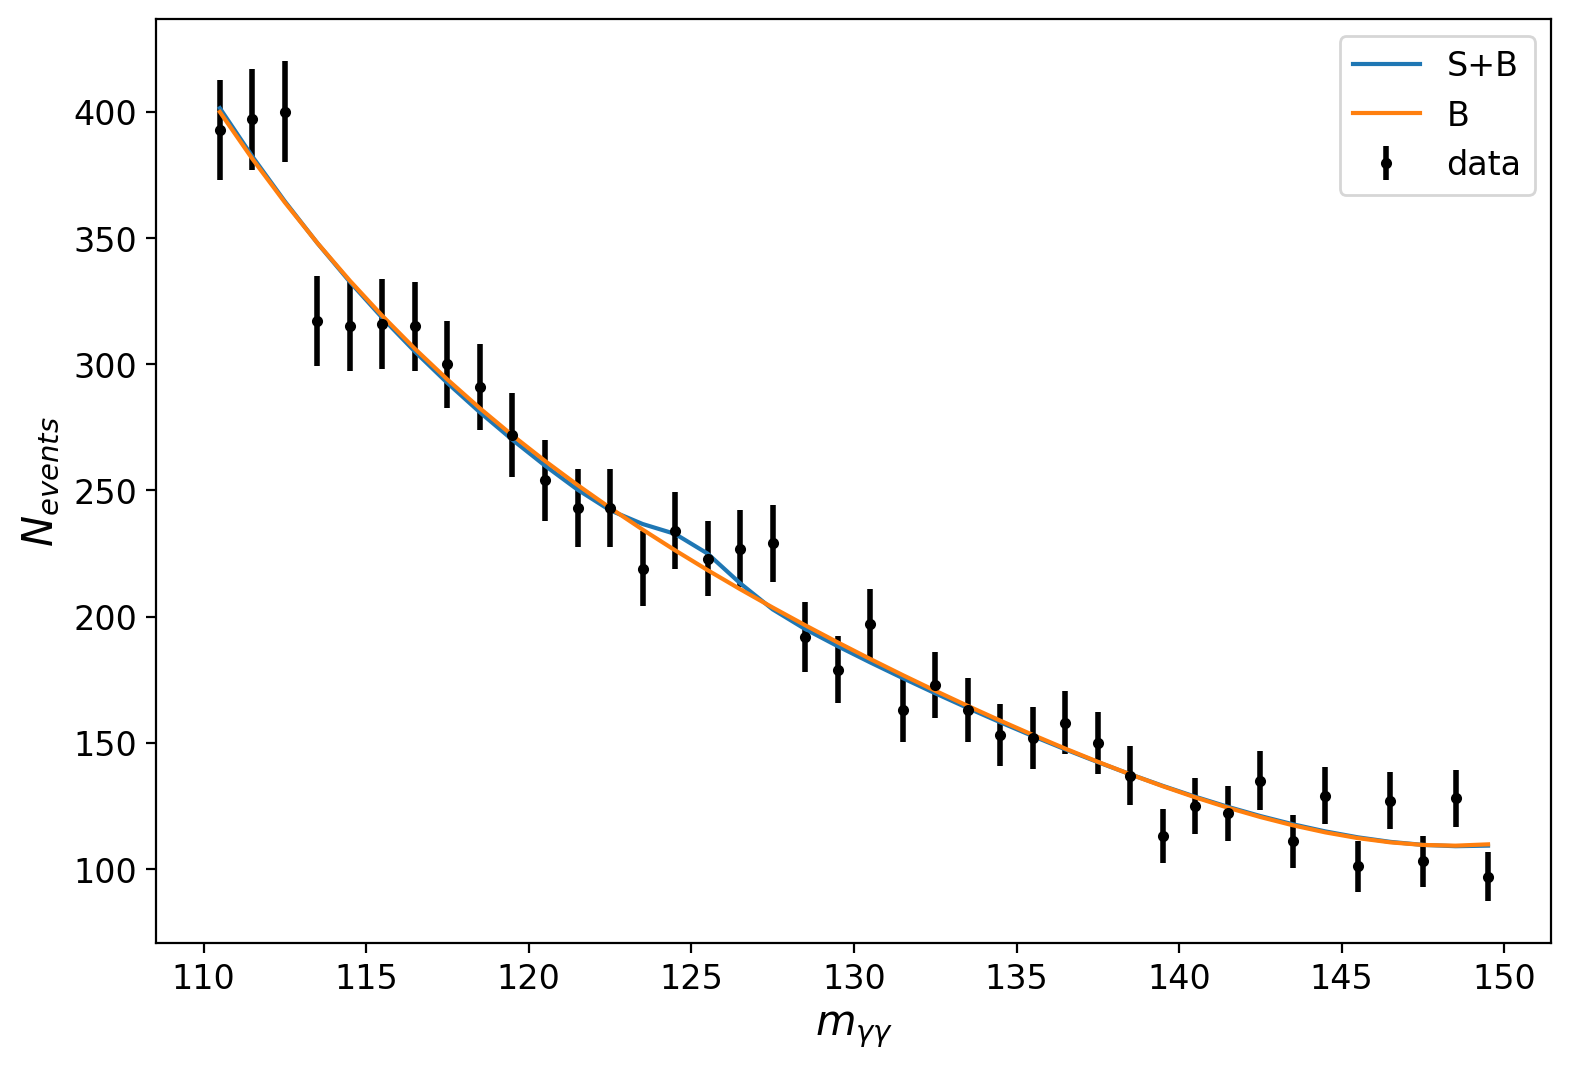

2NLL: 0.5629803445190475 p-value 0.45306190277594016 z-score 0.11792913799945565


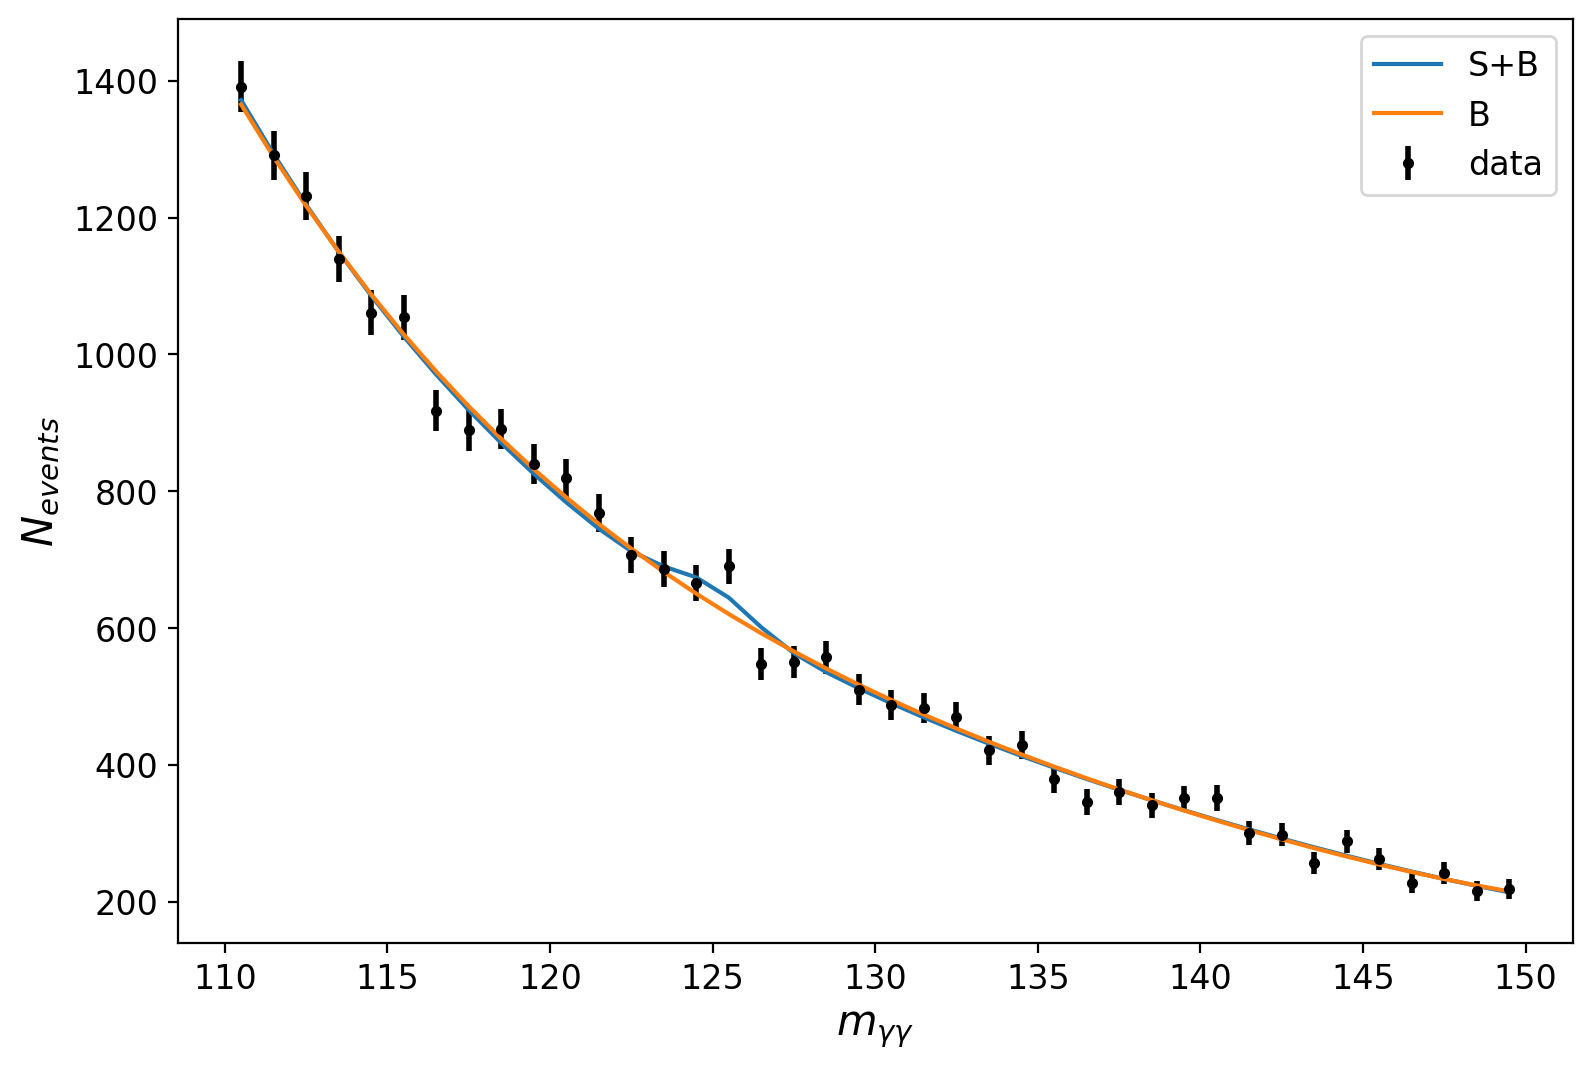

2NLL: 2.5781255552211704 p-value 0.10834989967480646 z-score 1.2353512724189557


In [25]:
def sigpol4(x,p0,p1,p2,p3,p4,amp,mass,sigma):
    bkg=pol4(x,p0,p1,p2,p3,p4)
    sig=amp*stats.norm.pdf(x,mass,sigma)
    return sig+bkg

def sigpol3(x,p0,p1,p2,p3,p4,amp,mass,sigma):
    bkg=pol3(x,p0,p1,p2,p3)
    sig=amp*stats.norm.pdf(x,mass,sigma)
    return sig+bkg

def sigpol5(x,p0,p1,p2,p3,p4,p5,amp,mass,sigma):
    bkg=pol5(x,p0,p1,p2,p3,p4,p5)
    sig=amp*stats.norm.pdf(x,mass,sigma)
    return sig+bkg

def fitModel(iX,iY,iWeights,iM,iFunc):
    model  = lmfit.Model(iFunc)
    p = model.make_params(p0=0,p1=0,p2=0,p3=0,p4=0,p5=0,amp=0,mass=iM,sigma=1.2)
    try:
        p["mass"].vary=False
        p["sigma"].vary=False
    except:
      a=1
      #print("Mass and Sigma not in fit")
    result = model.fit(data=iY,params=p,x=iX,weights=iWeights)
    output = model.eval(params=result.params,x=iX)
    return output,result.residual #Note the log

def fitSig(iLabel,iM,SBfunc,Bfunc,iPlot=False):
    x,y,y_err,weights=load(iLabel)
    resultSB,likeSB=fitModel(x,y,weights,iM,SBfunc)
    resultB, likeB =fitModel(x,y,weights,iM,Bfunc)
    if iPlot:
        plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label="data")
        plt.plot(x,resultSB,label="S+B")
        plt.plot(x,resultB, label="B")
        plt.xlabel("$m_{\gamma\gamma}$")
        plt.ylabel("$N_{events}$")
        plt.legend()
        plt.show()
    return np.sum(likeB**2)-np.sum(likeSB**2)

NLL=fitSig("data/out.txt",125,sigpol4,pol4,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1),"z-score",stats.norm.ppf(stats.chi2.cdf(NLL,1)))

NLL=fitSig("data/out2.txt",125,sigpol4,pol4,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1),"z-score",stats.norm.ppf(stats.chi2.cdf(NLL,1)))

NLL=fitSig("data/out3.txt",125,sigpol4,pol4,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1),"z-score",stats.norm.ppf(stats.chi2.cdf(NLL,1)))

NLL=fitSig("data/out4.txt",125,sigpol4,pol4,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1),"z-score",stats.norm.ppf(stats.chi2.cdf(NLL,1)))

NLL=fitSig("data/out5.txt",125,sigpol4,pol4,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1),"z-score",stats.norm.ppf(stats.chi2.cdf(NLL,1)))

Wow, we see a fairly significant Higgs bump at 125, but lets scan the mass and make the so called p-value plot. This is just a plot of the significance as a function of mass. What we will do is move the mass distribution peform the same p-value calculation with the fixed signal, and we will make the plot. 

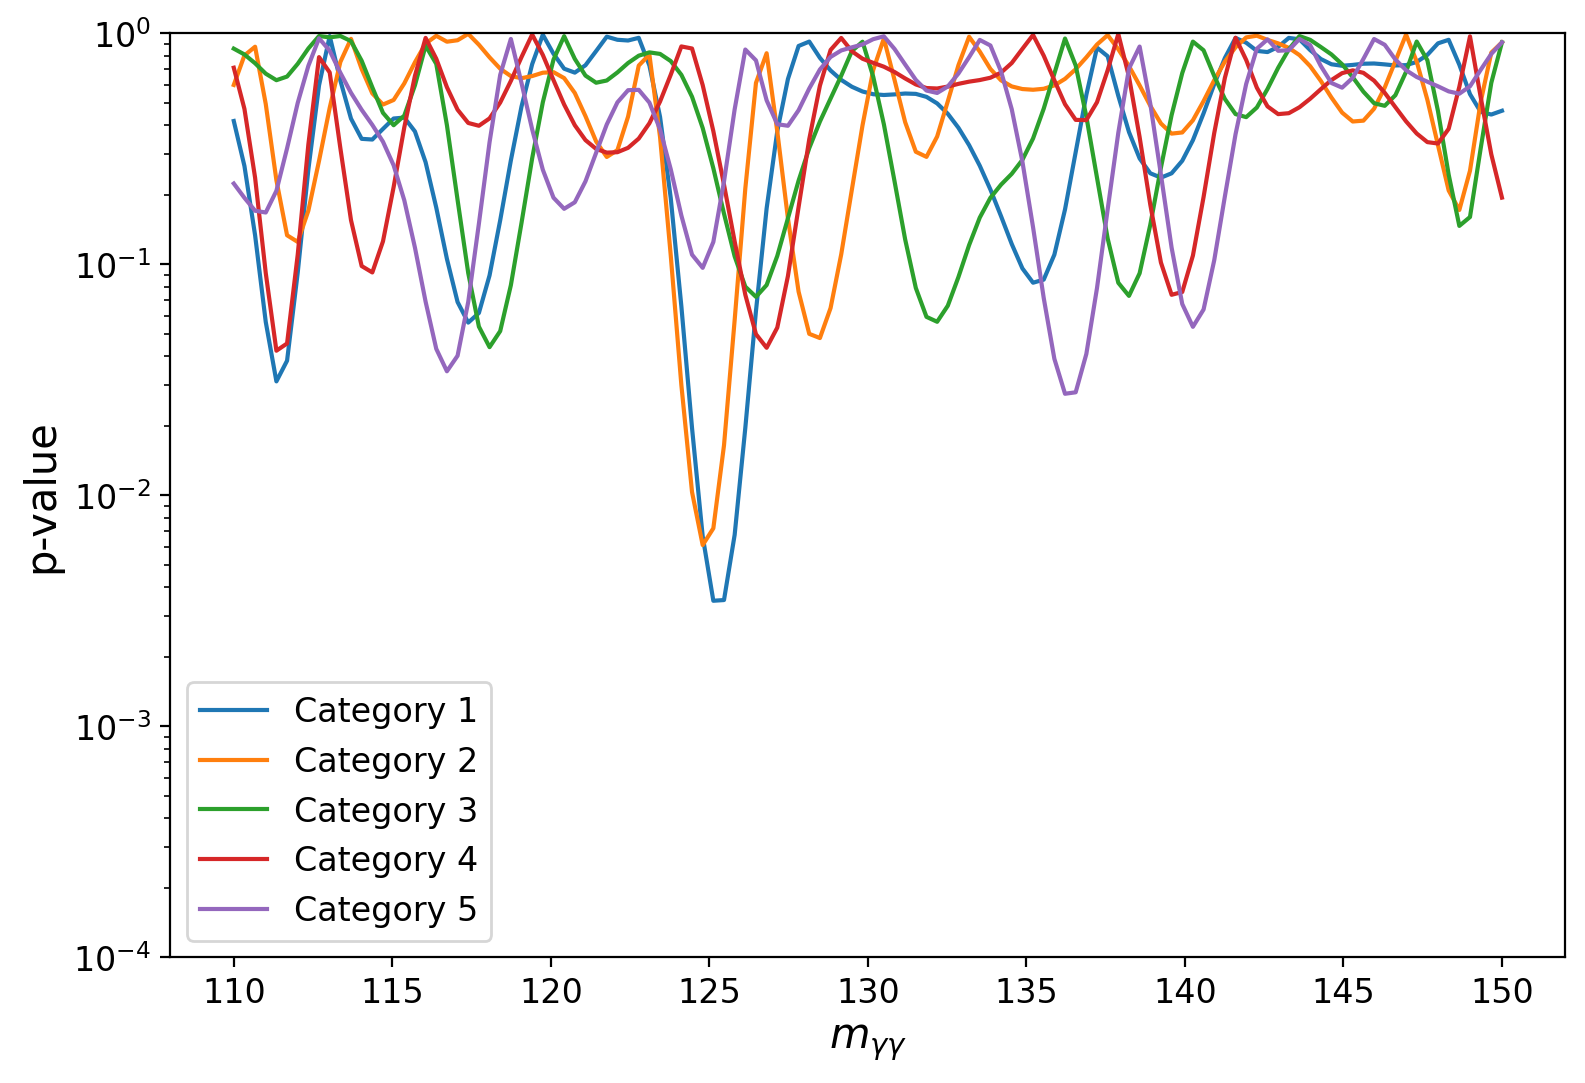

In [26]:
def pvalueCalc(iLabel,pMass,iSBFunc,iBFunc):
    NLL=fitSig(iLabel,pMass,iSBFunc,iBFunc,False)
    NLLp = 1-stats.chi2.cdf(NLL,1)
    return NLLp

def pvaluePlot(iLabel,iSBFunc,iBFunc):
    pvalue = np.array([])
    massrange=np.linspace(110,150,120)
    for pMass in massrange:
        pvalue = np.append(pvalue,pvalueCalc(iLabel,pMass,iSBFunc,iBFunc))
    return massrange,pvalue

m0,p0 = pvaluePlot("data/out.txt",sigpol4,pol4)
m1,p1 = pvaluePlot("data/out2.txt",sigpol4,pol4)
m2,p2 = pvaluePlot("data/out3.txt",sigpol4,pol4)
m3,p3 = pvaluePlot("data/out4.txt",sigpol4,pol4)
m4,p4 = pvaluePlot("data/out5.txt",sigpol4,pol4)

plt.plot(m0,p0,label="Category 1")
plt.plot(m1,p1,label="Category 2")
plt.plot(m2,p2,label="Category 3")
plt.plot(m3,p3,label="Category 4")
plt.plot(m4,p4,label="Category 5")
plt.ylim((0.0001,1))
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.2.1</span>


Compute the Higgs boson p-value signficance plot for category 1 with a 5th order polynomial? How does it compare. 

In [ ]:
def sigpol5(x,p0,p1,p2,p3,p4,p5,amp,mass,sigma):
    sig=#
    bkg=#
    return sig+bkg

m0,p0 = pvaluePlot("out.txt",sigpol5,pol5)
m1,p1 = pvaluePlot("out2.txt",sigpol5,pol5)
m2,p2 = pvaluePlot("out3.txt",sigpol5,pol5)
m3,p3 = pvaluePlot("out4.txt",sigpol5,pol5)
m4,p4 = pvaluePlot("out5.txt",sigpol5,pol5)

plt.plot(m0,p0,label="Category 1")
plt.plot(m1,p1,label="Category 2")
plt.plot(m2,p2,label="Category 3")
plt.plot(m3,p3,label="Category 4")
plt.plot(m4,p4,label="Category 5")
plt.ylim((0.0001,1))
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()

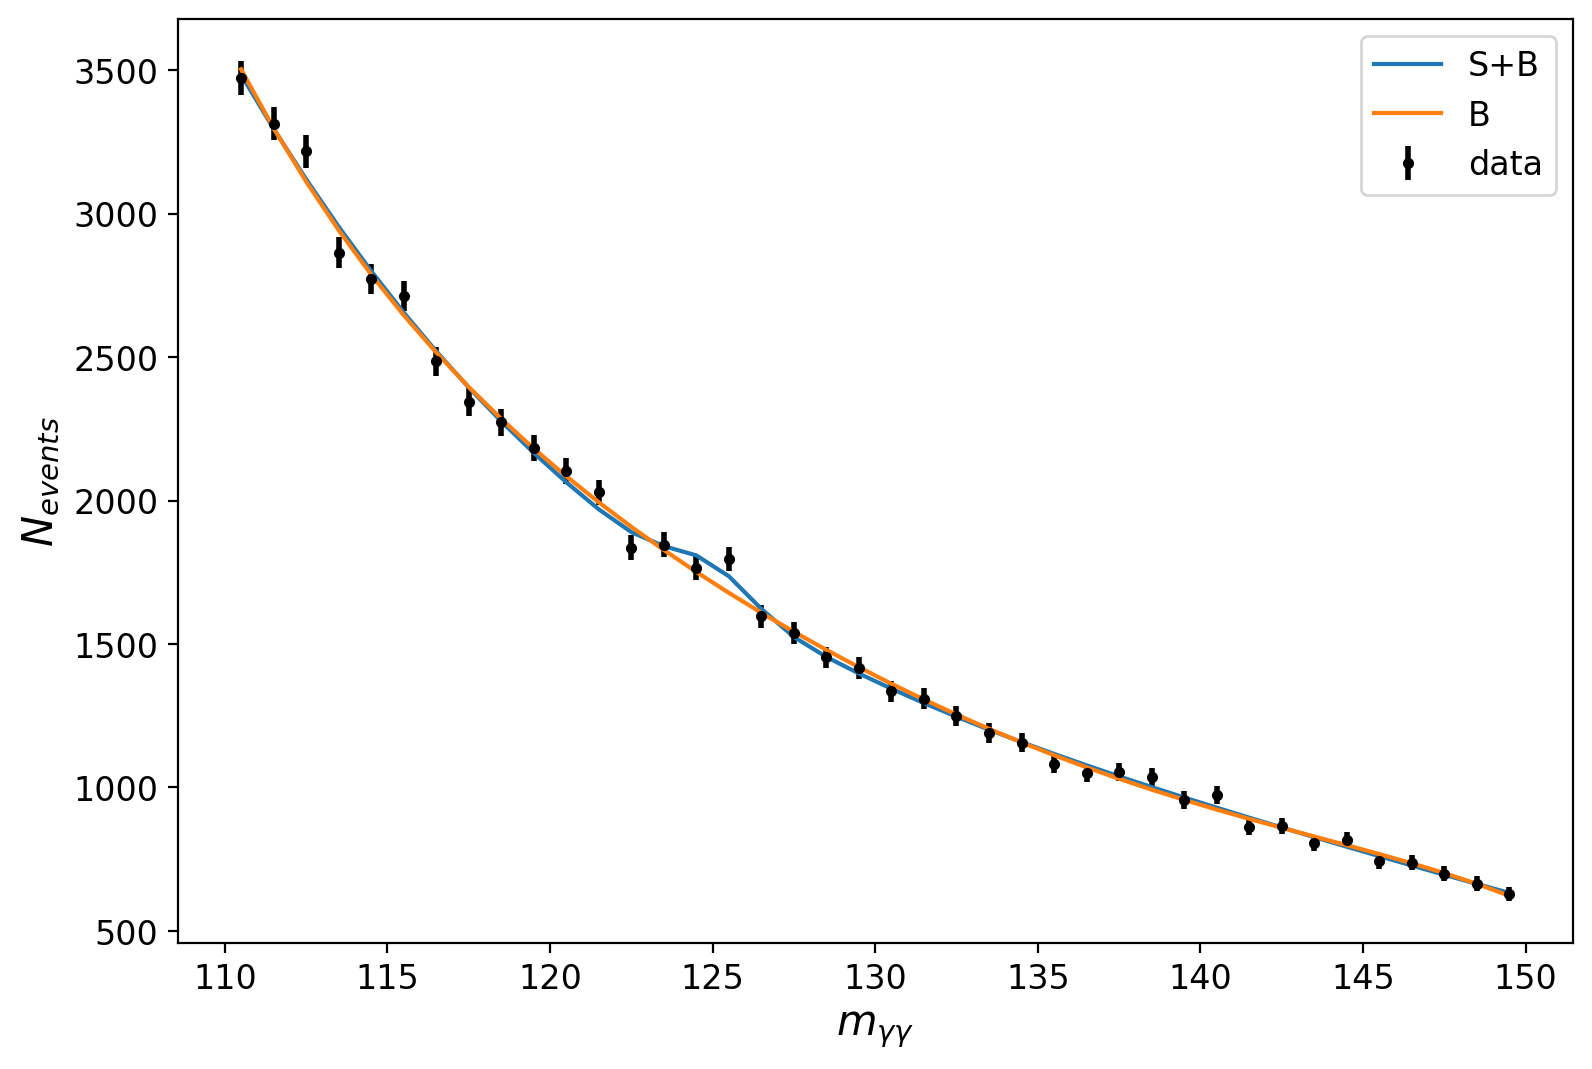

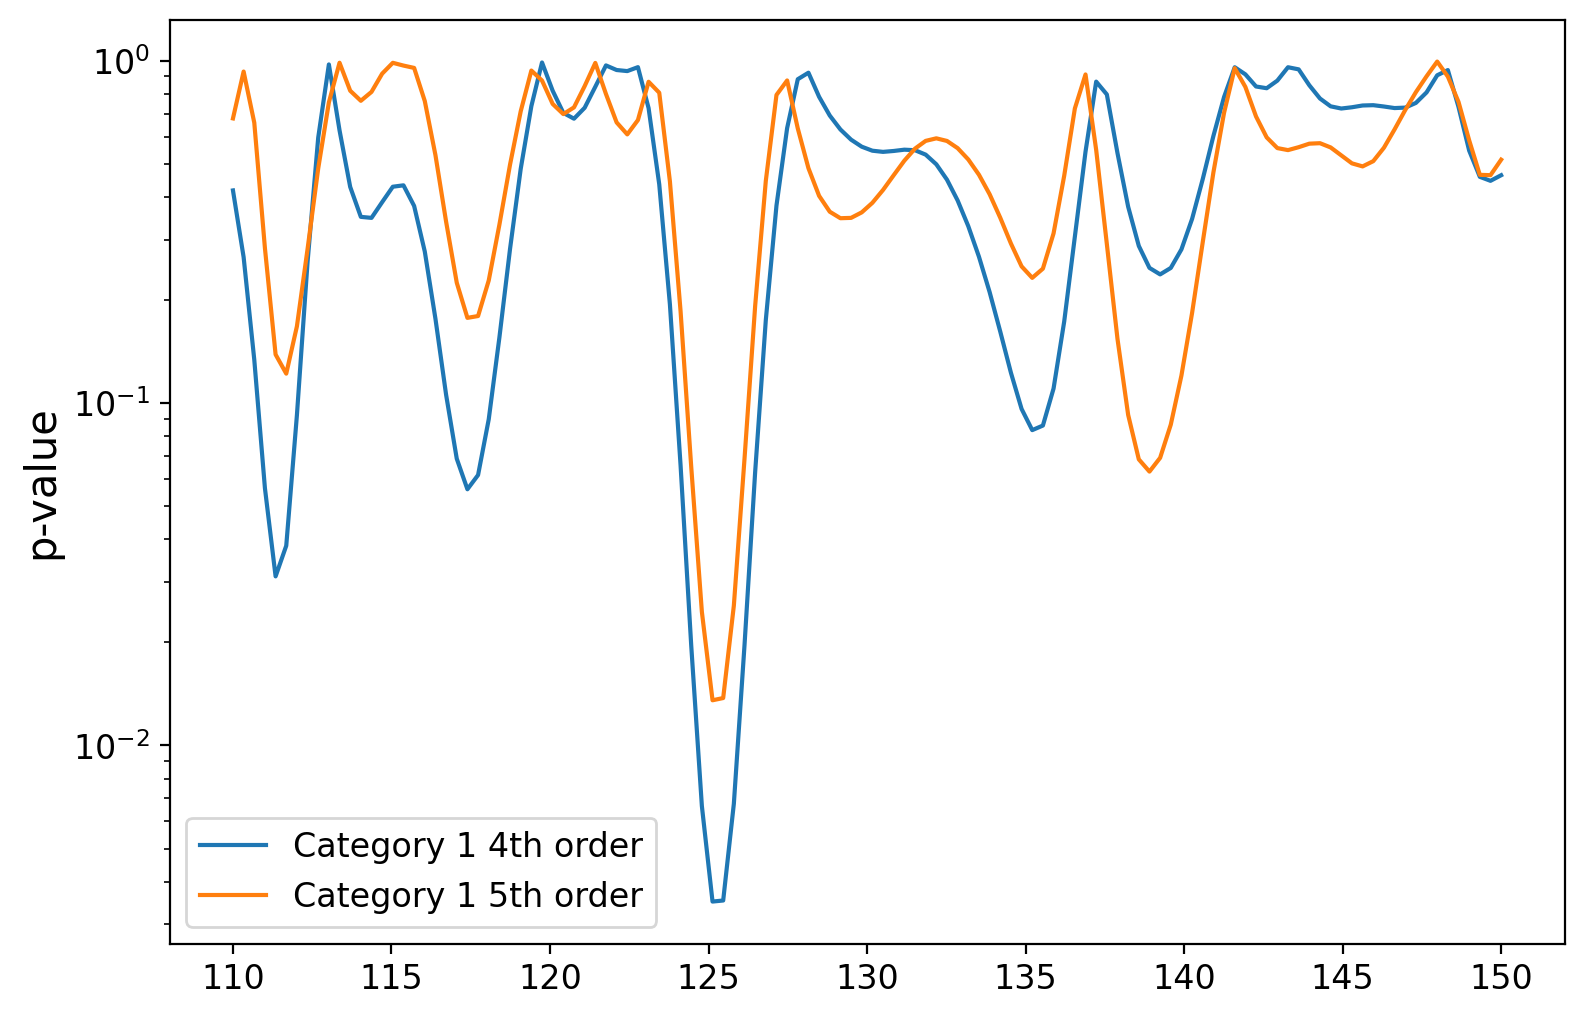

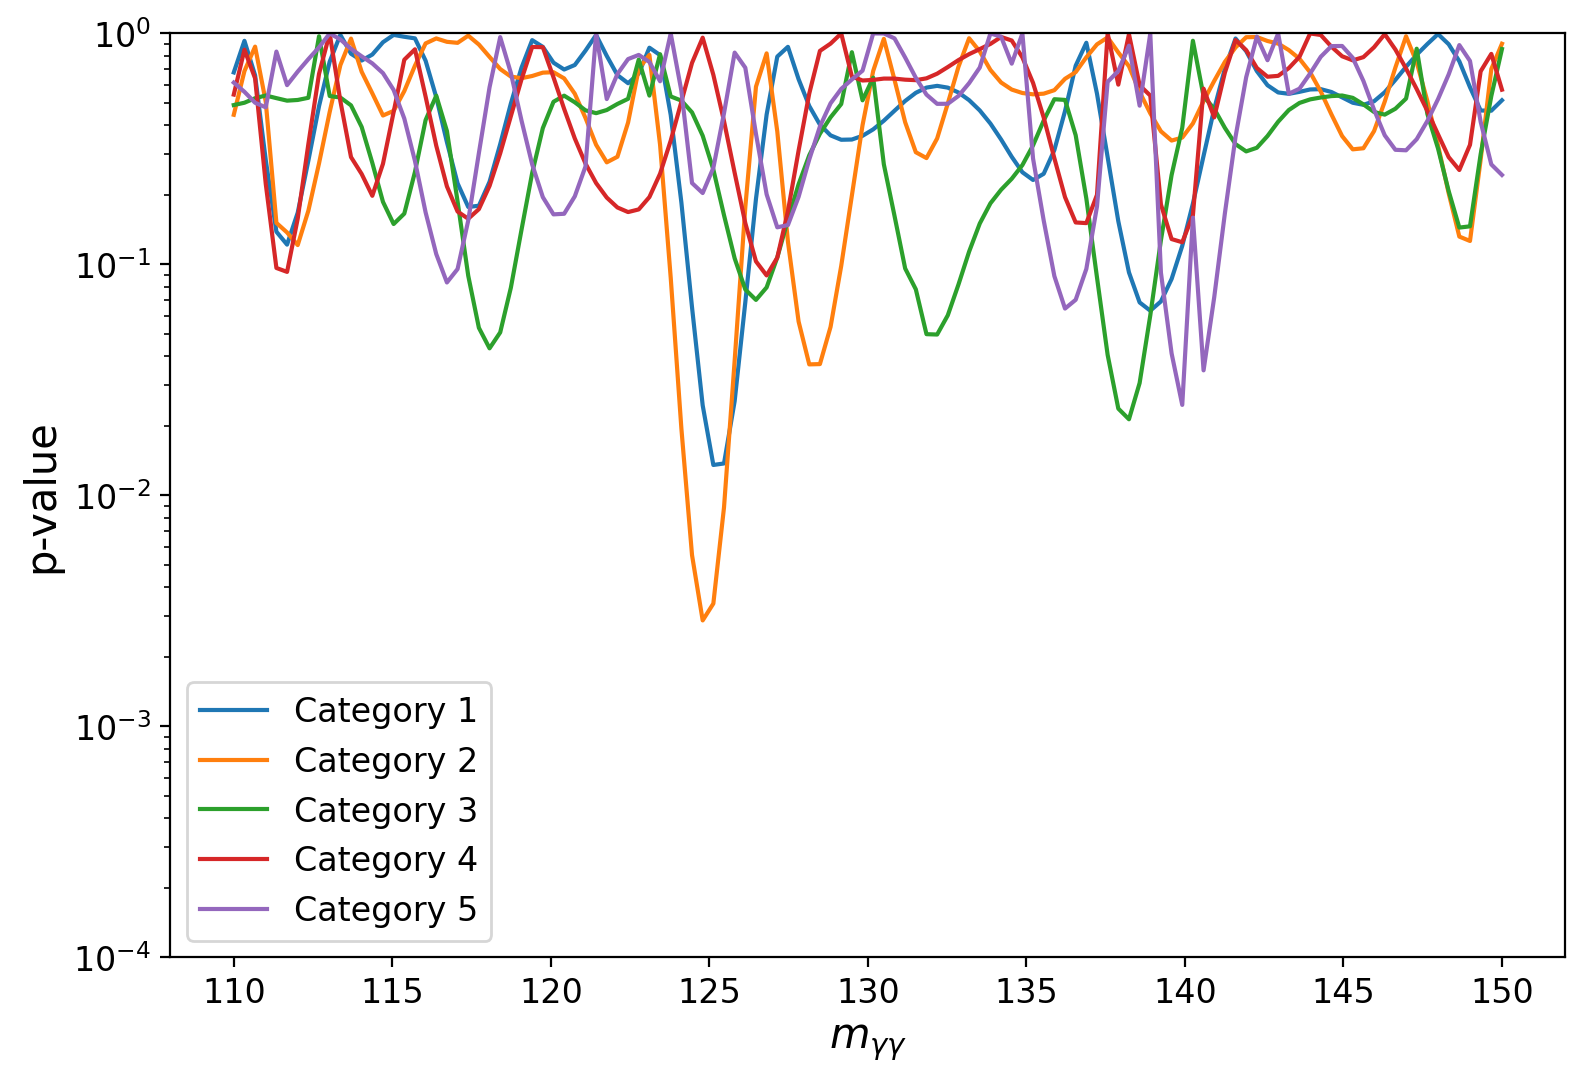

In [27]:
def pol5(x, p0, p1,p2,p3,p4,p5):
    pols=[p0,p1,p2,p3,p4,p5]
    y = np.polyval(pols,x)
    return y

def sigpol5(x,p0,p1,p2,p3,p4,p5,amp,mass,sigma):
    bkg=pol5(x,p0,p1,p2,p3,p4,p5)
    sig=amp*stats.norm.pdf(x,mass,sigma)
    return sig+bkg


#answer
NLL=fitSig("data/out.txt",125,sigpol5,pol5,True)

m03,p03 = pvaluePlot("data/out.txt",sigpol5,pol5)
plt.plot(m0,p0,label="Category 1 4th order")
plt.plot(m03,p03,label="Category 1 5th order")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()

#Now just for fun, lets run the full p-value plot
m0,p0 = pvaluePlot("data/out.txt",sigpol5,pol5)
m1,p1 = pvaluePlot("data/out2.txt",sigpol5,pol5)
m2,p2 = pvaluePlot("data/out3.txt",sigpol5,pol5)
m3,p3 = pvaluePlot("data/out4.txt",sigpol5,pol5)
m4,p4 = pvaluePlot("data/out5.txt",sigpol5,pol5)

plt.plot(m0,p0,label="Category 1")
plt.plot(m1,p1,label="Category 2")
plt.plot(m2,p2,label="Category 3")
plt.plot(m3,p3,label="Category 4")
plt.plot(m4,p4,label="Category 5")
plt.ylim((0.0001,1))
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
Less Significant
</pre>
        
**EXPLANATION:**
When you fit with more degrees of freedom, you start to lose sensitivity. The choice of freedom of the function is critical to ensure good sensitivity. 
    
</div>


<a name='section_12_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.3 Combining p-values</h2>  


Now, if we have 5 experiments each giving a p-value at a specific mass point. How, do we combine these p-values. The strategy is to realize these are each independent experiments. Moreover, it can be shown that if you have a flat prior in probability, and if you take the log of this prior and multiply by 2 $2\log(p)$ this distribution is approximately that of a $\chi^{2}$ distribution of 2 degrees of freedom.  That is to say if you have N categories each with equal sensitivity to a signal (flat prior in probability to be in any category), the the sum of the $2\log(p)$ of the categories gives us a $\chi^{2}$ distribution. 


We can see this analytically by noting that $\chi^{2}$ distribution is given by 

\begin{equation}
\chi^{2}(x,\nu) = \frac{1}{2^{\nu/2}\Gamma(\nu/2)} x^{\nu/2-1}e^{-x/2}
\end{equation}

For $\nu=2$, we have it is just a an exponential distribution given by:

\begin{equation}
\chi^{2}(x,\nu=2) = \frac{1}{2}e^{-x/2}
\end{equation}

Now for a distribution that is flat is distribution from 0 to 1, such as the $p-value$ of a random measurement. Then if we take the log of that, we find
\begin{equation}
 y = -2\log(x)\rightarrow e^{-\frac{y}{2}}=x \\
 dx = -\frac{1}{2}e^{\frac{-y}{2}} dy \\
\end{equation}
To equate probability distributions, we want to solve for scenario where the probabilities over a range are equal, namely, to get it as a function of $y$, we can write, noting $p(x)=1$
\begin{equation}
 p(y) dy = p(x) dx \\
 p(y) = p(x) \frac{dx}{dy}\\
 p(y) = p(f^{-1}(y)) \frac{dx}{dy}\\
 p(y) = \frac{dx}{dy} \\
 p(y)=e^{-\frac{y}{2}} \\
\end{equation}
or for $x$ a flat probability distribution from 0 to 1, we have that $y$ has to be distributed such that $p(y)=e^{-\frac{y}{2}}$ 

(array([ 9926., 10082., 10056.,  9963.,  9996., 10016., 10177.,  9915.,
         9862., 10007.]),
 array([1.35995238e-05, 1.00012127e-01, 2.00010655e-01, 3.00009182e-01,
        4.00007710e-01, 5.00006238e-01, 6.00004765e-01, 7.00003293e-01,
        8.00001821e-01, 9.00000348e-01, 9.99998876e-01]),
 <BarContainer object of 10 artists>)

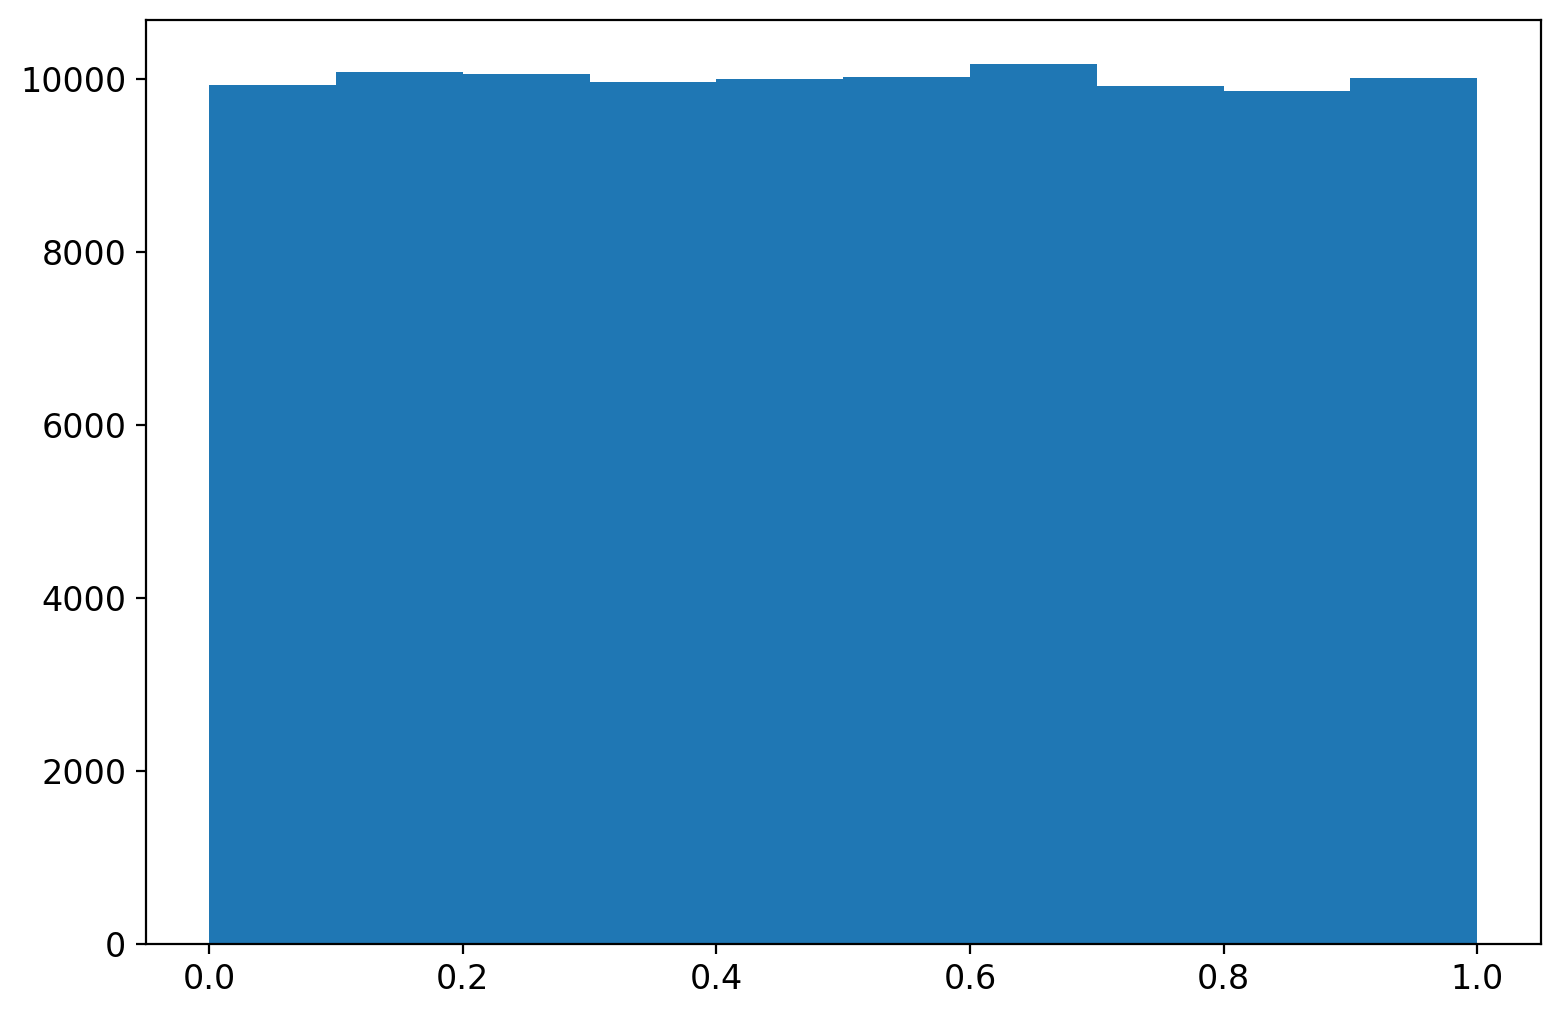

In [28]:
samples=np.random.normal(0,1,100000)
pvalues=stats.norm.cdf(samples)
plt.hist(pvalues)

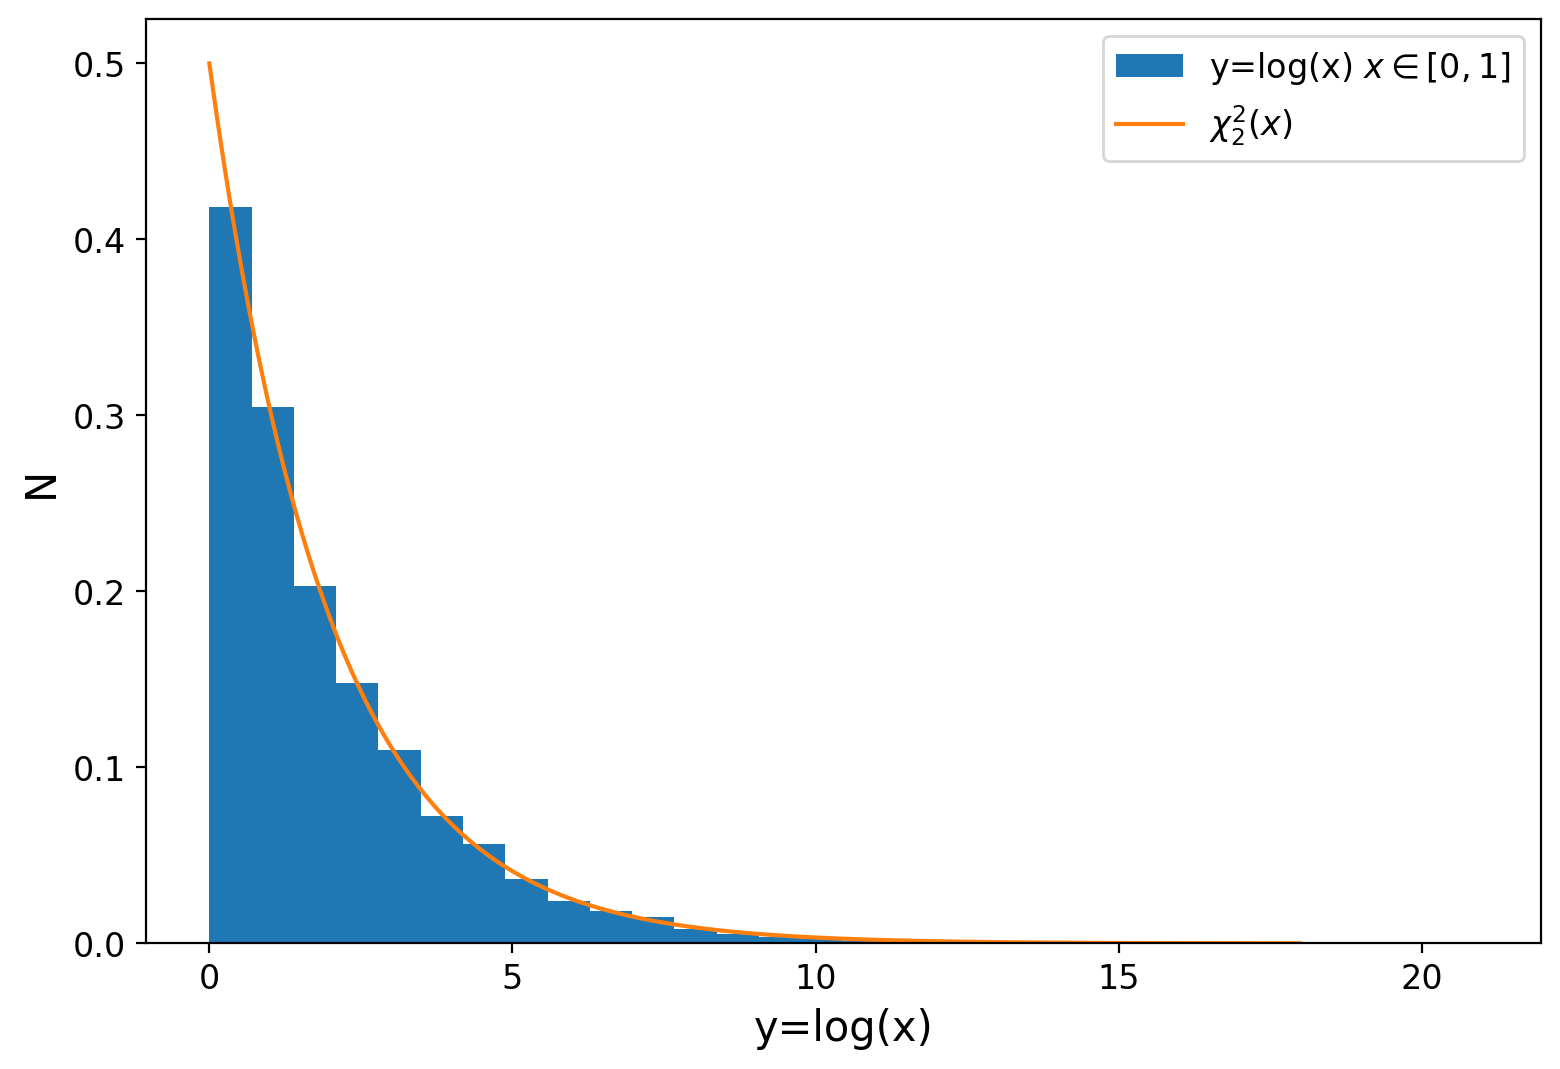

In [29]:
xvals=np.arange(0,18,0.01)
samples = np.random.uniform(0,1,10000)
plt.hist(-2.*np.log(samples),bins=30,density=True,label='y=log(x) $x\in[0,1]$')
plt.plot(xvals,stats.chi2.pdf(xvals,2),label='$\chi^{2}_{2}(x)$')
plt.xlabel("y=log(x)")
plt.ylabel("N")
plt.legend()
plt.show()

Now going back to our calculation, we can immediately relate 
\begin{equation}
\chi^{2}_{\nu=2} = -2 \log(p_{i})
\end{equation}
Now, lets say we have $n$ measurements each with probability $p_{i}$ for the i-th category. If we take the $2\log(p_{i})$ and sum the distributions, we have a sum of $\chi^{2}$ distributions of 2 degrees of freedom. This is just a $\chi^{2}_{\nu=2n}$ distribution. 

\begin{equation}
\chi^{2}_{\nu=2n} = -2 \sum_{i=1}^{n} \log(p_{i})
\end{equation}

From this relation, we can immediately get the combined p-value by checking up the p-value of a $\chi^{2}_{\nu=2n}$ distribution.  Lets see this in action!

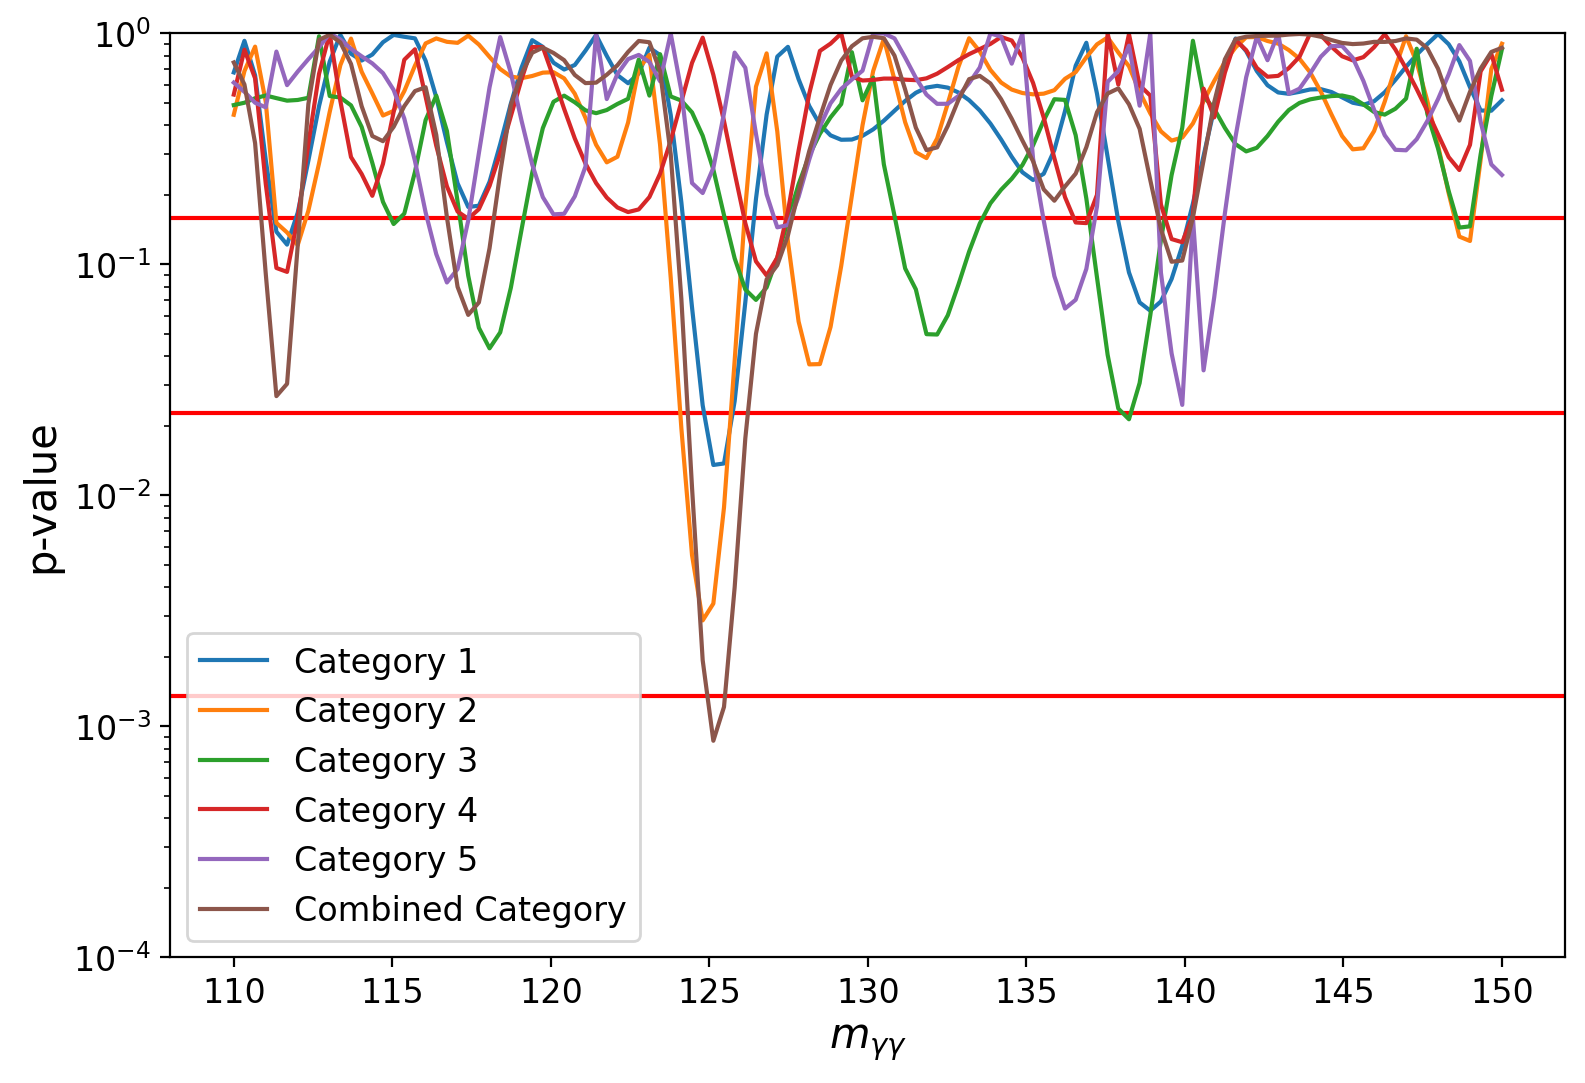

In [30]:
def pvalueCalc(iLabel,pMass,iSBFunc,iBFunc):
    logp=0
    for pLabel in iLabel:
        NLL=fitSig(pLabel,pMass,iSBFunc,iBFunc,False)
        NLLp = 1.-stats.chi2.cdf(NLL,1)
        logp = logp - 2.*np.log(NLLp)
    pPVal  = 1-stats.chi2.cdf(logp,2*len(iLabel))
    return pPVal

files=["data/out.txt","data/out2.txt","data/out3.txt","data/out4.txt","data/out5.txt"]
mC,pC = pvaluePlot(files,sigpol4,pol4)

for pVal in range(4):
    sigmas = 1-stats.norm.cdf(pVal+1)
    plt.axhline(y=sigmas, color='r', linestyle='-')
plt.plot(m0,p0,label="Category 1")
plt.plot(m1,p1,label="Category 2")
plt.plot(m2,p2,label="Category 3")
plt.plot(m3,p3,label="Category 4")
plt.plot(m4,p4,label="Category 5")
plt.plot(mC,pC,label="Combined Category")
plt.ylim((0.0001,1))
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()


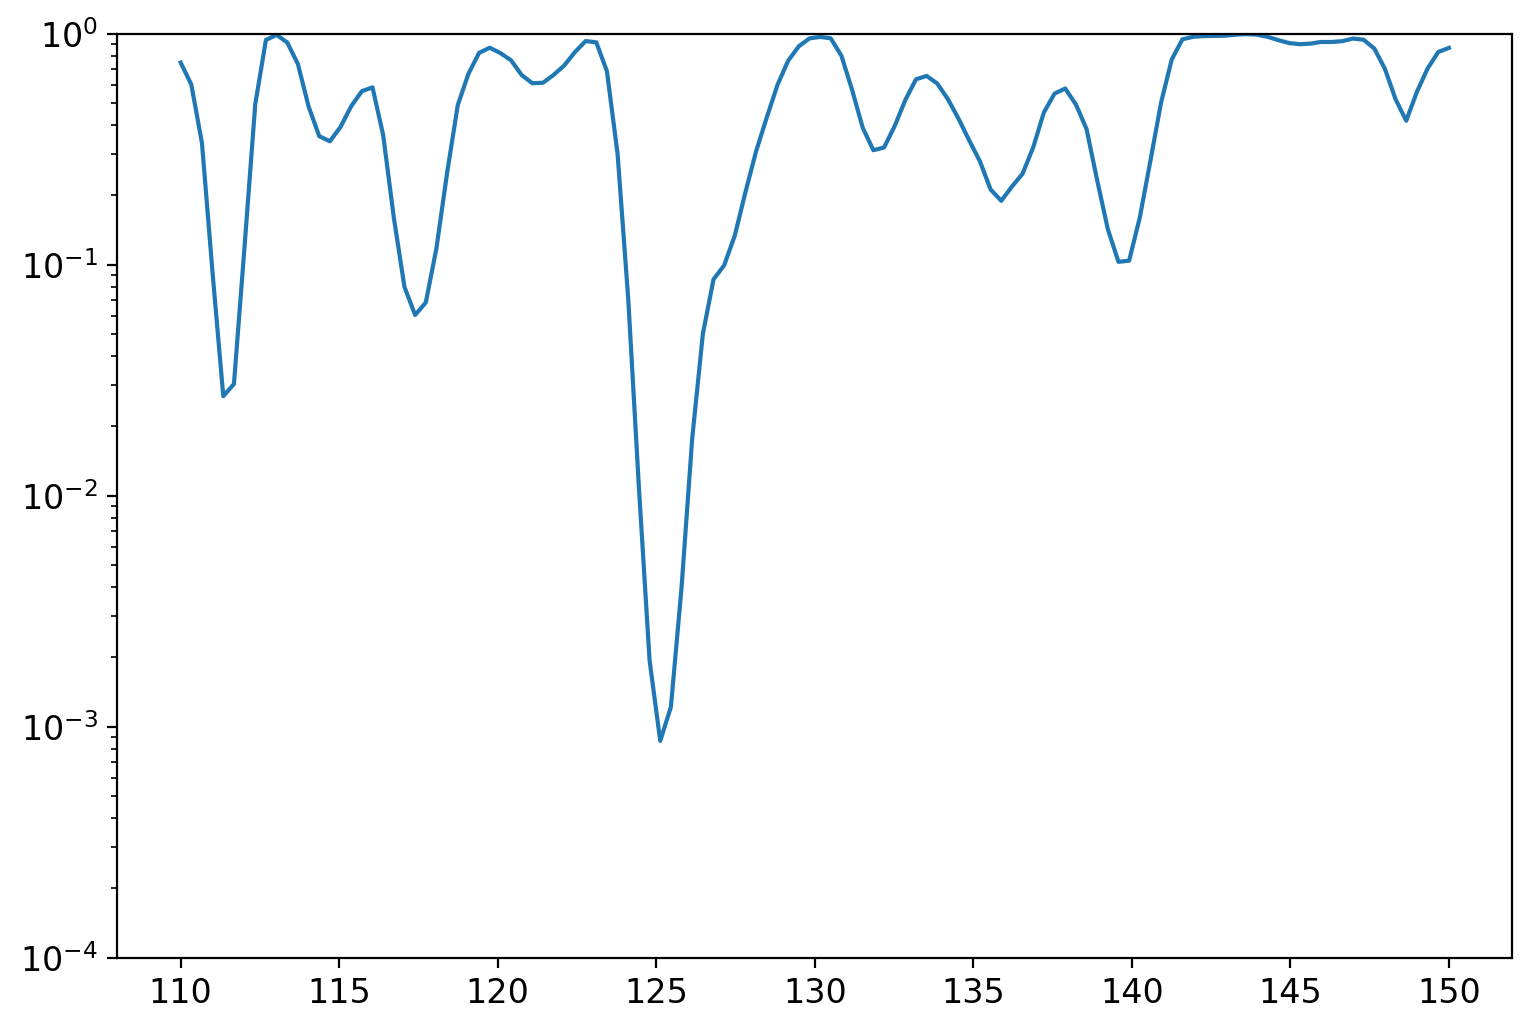

In [31]:
plt.plot(mC,pC,label="Category 1")
plt.ylim((0.0001,1))
plt.yscale("log")

Ok, now that we have done that, lets compare our result for the 8TeV measurement in the original paper [here](https://arxiv.org/pdf/1407.0558.pdf). If you look at that plot, you will see that there is a significance of almost 4 standard deviations for the 8TeV data, whereas we only have 3 standard deviations. The reason is that the analysis in the paper is more complicated. To compare our result with something closer, look at the Higgs discovery [paper](https://arxiv.org/pdf/1207.7235.pdf). Here, we are more sensitive, but we also have more data. 

The way the analysis is more complicated is because of the fact that the combination we are doing here is naive. We are assuming all the categories contribute equally. In reality, we know that from simulation of the signal that the relative contributions of each category is not flat, but weighted. As a consequnce, the trick in this section really only works to get an "approximate" sensitivity. The real way to do this is to simultaneously fit all categories with the known, relative signal strength of each of the categories. 

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.3.1</span>

Noting that the p-value on the y-axis is just a translation of the likelihood, and the p-value is computed from a $\chi^{2}$ distribution, convert from $\chi^{2}$ probability back to 2$\log(\mathcal{L})$, from this compute the best fit mass for the Higgs boson? How does it compare to the true value



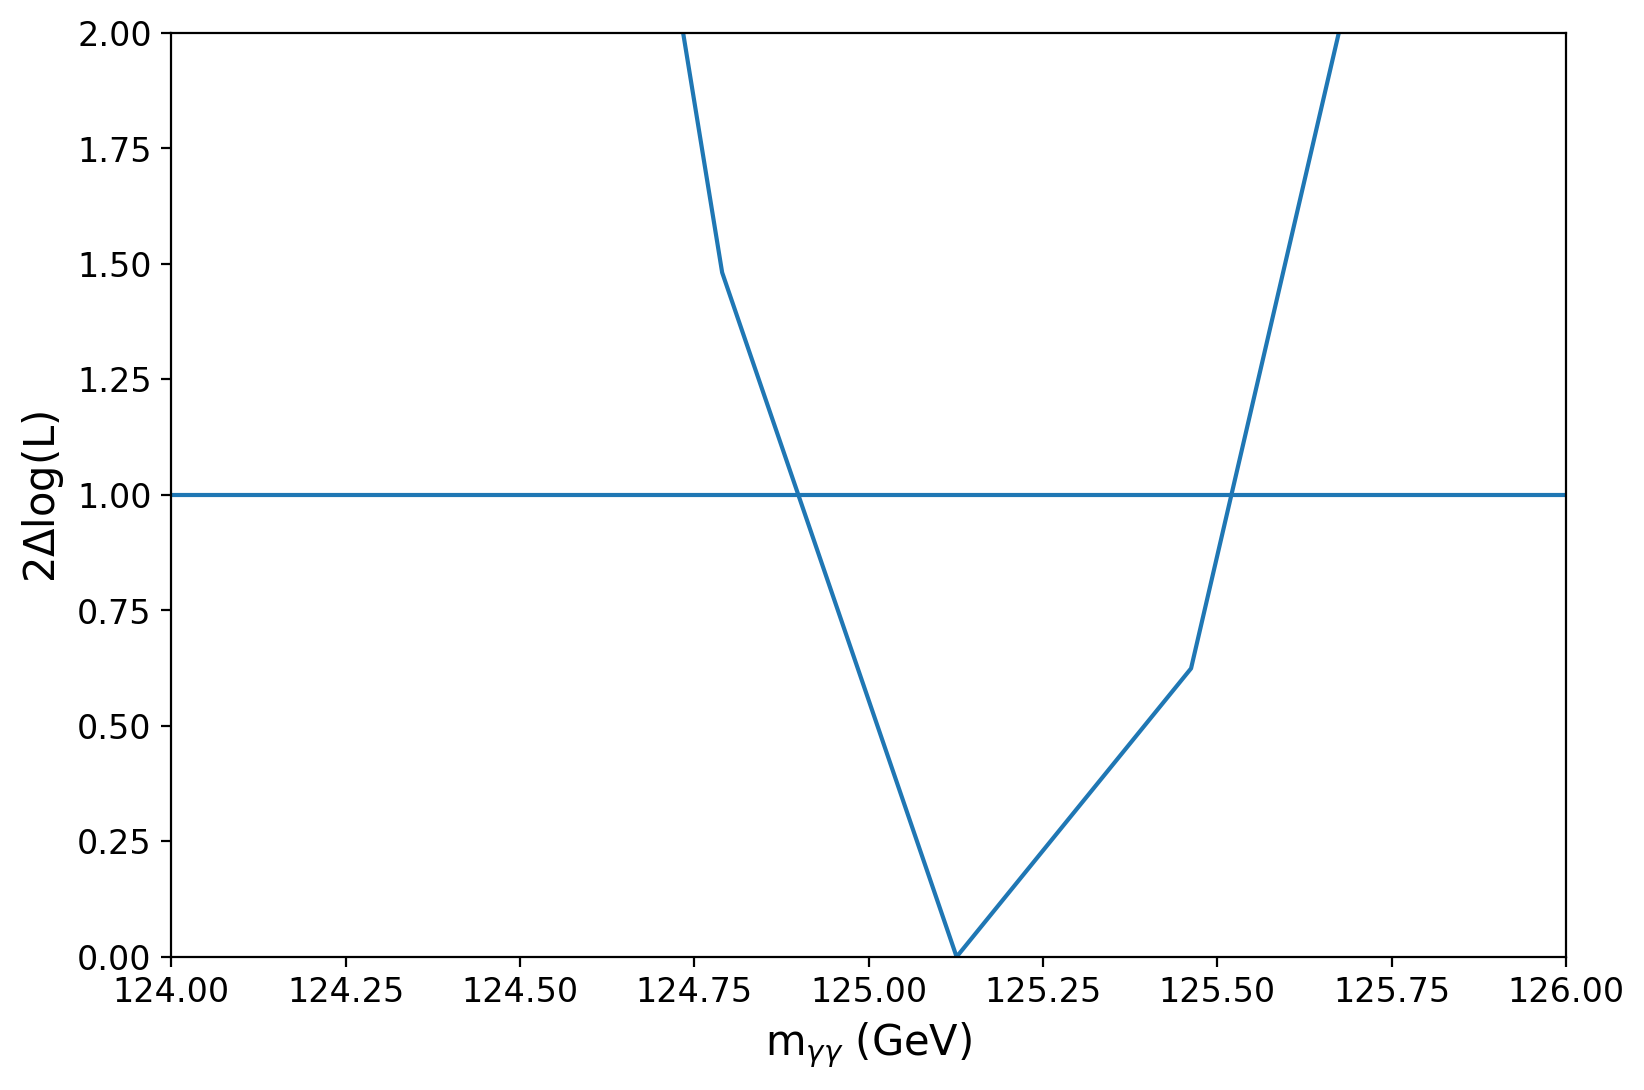

In [32]:
#Answer, the strategy here is to realize that p-value plot is also 2*Log(L) of our best fit, thus, we just need to go 1 standard deviation from the minimum in likelihood
logC = stats.chi2.ppf(1-pC,1)
logC = -logC+np.max(logC)
plt.plot(mC,logC,label="Combined")
plt.ylim(0,2)
plt.xlim(124,126)
plt.hlines(1,120,130)
plt.xlabel("m$_{\gamma\gamma}$ (GeV)")
plt.ylabel("2$\Delta$log(L) ")
plt.show()
#Its roughly 124.8-125.5 => 125.2+/-0.35 (Its almost spot on!)

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
Our best fit mass is from 124.8 to 125.5 => 125.2 +/- 0.35 (almost spont on!)
</pre>
        
**EXPLANATION:**
We can obtain this by noting that the p-value is jsut a translation of the minimum likelihood. So we just need to convert from p-value back to likelihood and scan 2$\log(\mathcal{L})$, and viola. 
    
</div>


<a name='section_12_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.4 Function choice </h2>  

Now, we chose a background function based on a [power law](https://en.wikipedia.org/wiki/Power_law) others you can consider are the [laurent polynomials](https://en.wikipedia.org/wiki/Laurent_polynomial). This will just be taking $x^{-j}$ instead of $x^{j}$. The point for this is that the choice that we made to fit the function had some level of aribratriness. What would our fit performance be if we just chose another fit function somewhat at ranodm? In fact, more generally, if we have another fit function that works, which one is best? 

This section we will try to address this arbitrariness by noting how these fits behave in general. Let's take a deeper dive into what is going on. we are goin to make a set of progressive more complciated functions


f 6 to 5: 0.3284119793694611


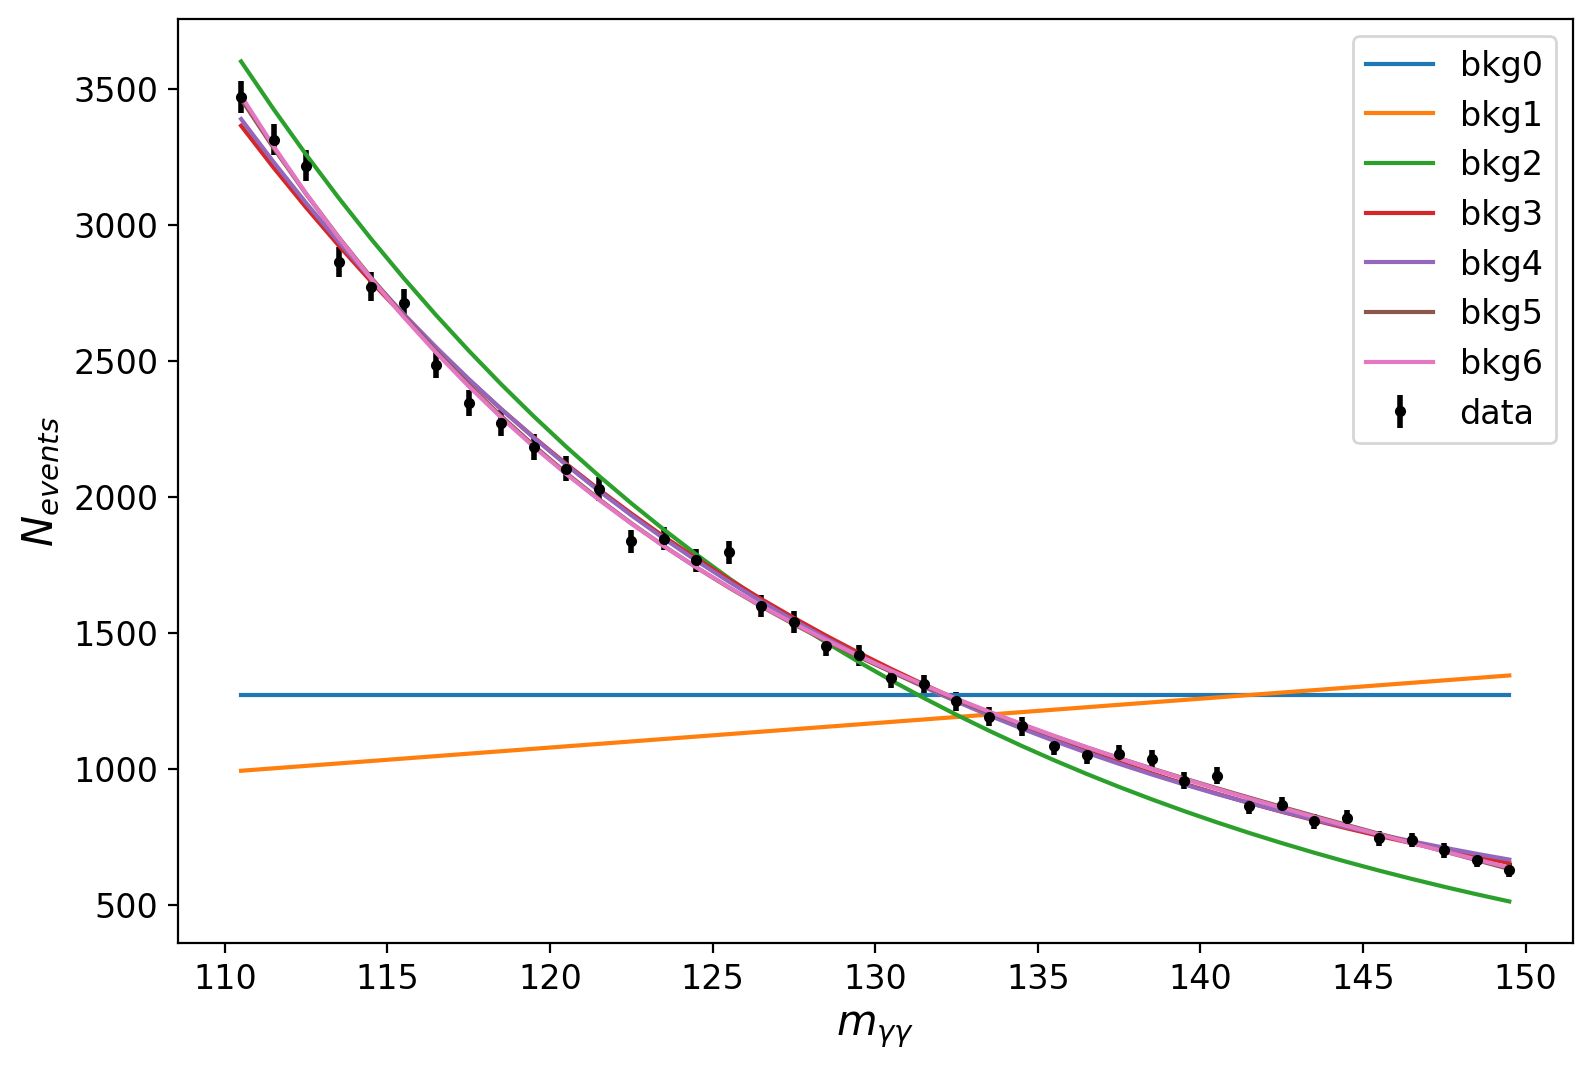

f 6 to 5: 0.3284119793694611
f 1 to 0: 1.0
f 2 to 1: 1.1102230246251565e-16
f 3 to 2: 2.3314683517128287e-14
f 4 to 3: 0.049621250239942016
f 5 to 4: 0.0005156519394441395
f 6 to 5: 0.3284119793694611
Mean: 4.21387638786741 	STD: 17.765714486207152 chi2 prob: 0.0
Mean: 6.393929910480218 	STD: 19.928077547340102 chi2 prob: 0.0
Mean: 0.9237579360159494 	STD: 3.0346624184515125 chi2 prob: 0.0
Mean: 0.007078860911581958 	STD: 1.1074722215457389 chi2 prob: 0.07196632760077637
Mean: 0.012484204872860899 	STD: 1.084579911101066 chi2 prob: 0.0837265228057622
Mean: 0.010119513924247255 	STD: 0.9159905502043955 chi2 prob: 0.48877409810150074


In [34]:
def bkg1(x,p0,p1):
    pols=[p0,p1]
    y=np.polyval(pols,x)
    #y=np.exp(-p0*(x-p1))
    return y

def bkg2(x, p0,p1,p2):
    #pols=[p0,p1,p2]
    #y=np.polyval(pols,x)
    y=p0*np.exp(-p1*(x-p2))
    return y

def bkg3(x, p0, p1,p2,p3):
    #pols=[p0,p1,p2,p3]
    y=p0*np.exp(-p1*(x-p2))+p3
    return y

def bkg4(x, p0, p1,p2,p3,p4):
    pols=[p3,p4]
    y=p0*np.exp(-p1*(x-p2))+np.polyval(pols,x)
    return y

def bkg5(x, p0, p1,p2,p3,p4,p5):
    pols=[p3,p4,p5]
    y=p0*np.exp(-p1*(x-p2))+np.polyval(pols,x)
    return y

def bkg6(x, p0, p1,p2,p3,p4,p5,p6):
    pols=[p3,p4,p5,p6]
    y=p0*np.exp(-p1*(x-p2))+np.polyval(pols,x)
    return y

def fitModel(iX,iY,iWeights,iFunc):
    model  = lmfit.Model(iFunc)
    p = model.make_params(p0=0,p1=0.05,p2=100,p3=0.05,p4=0,p5=0,p6=0)
    try:
        p['p1'].vary=False
    except:
        a=1
    try:
        p['p2'].vary=False
    except:
        a=1
    result = model.fit(data=iY,params=p,x=iX,weights=iWeights)
    #lmfit.report_fit(result)
    output = model.eval(params=result.params,x=iX)
    return output

def fitAll(iLabel,iPlot=False):
    x,y,y_err,weights=load(iLabel)
    result0 = fitModel(x,y,weights,pol0)
    result1 = fitModel(x,y,weights,bkg1)
    result2 = fitModel(x,y,weights,bkg2)
    result3 = fitModel(x,y,weights,bkg3)
    result4 = fitModel(x,y,weights,bkg4)
    result5 = fitModel(x,y,weights,bkg5)
    result6 = fitModel(x,y,weights,bkg6)
    
    f65=ftest(y,y_err,result5,result6,4,5)
    print("f 6 to 5:",1-stats.f.cdf(f65,1,len(y)-1))
    if iPlot:
        plt.errorbar(x,y,y_err, lw=2,fmt=".k", capsize=0,label="data")
        plt.plot(x,result0,label="bkg0")
        plt.plot(x,result1,label="bkg1")
        plt.plot(x,result2,label="bkg2")
        plt.plot(x,result3,label="bkg3")
        plt.plot(x,result4,label="bkg4")
        plt.plot(x,result5,label="bkg5")
        plt.plot(x,result6,label="bkg6")
        plt.xlabel("$m_{\gamma\gamma}$")
        plt.ylabel("$N_{events}$")
        plt.legend()
        plt.show()
    return x,y,y_err,result0,result1,result2,result3,result4,result5

#just showing 4 since its the hardest to fit
fitAll("data/out.txt",True)
ftestAll("data/out.txt")
chi2testAll("data/out.txt")



So from above, a the second order constant + power law and a linear term is sufficient to fit he data both with a good $\chi^{2}$ and a good f-test. Notice the f-test is not perfect higher orders. In any case, lets go ahaed and chose this function, and see how this changes our significance? 

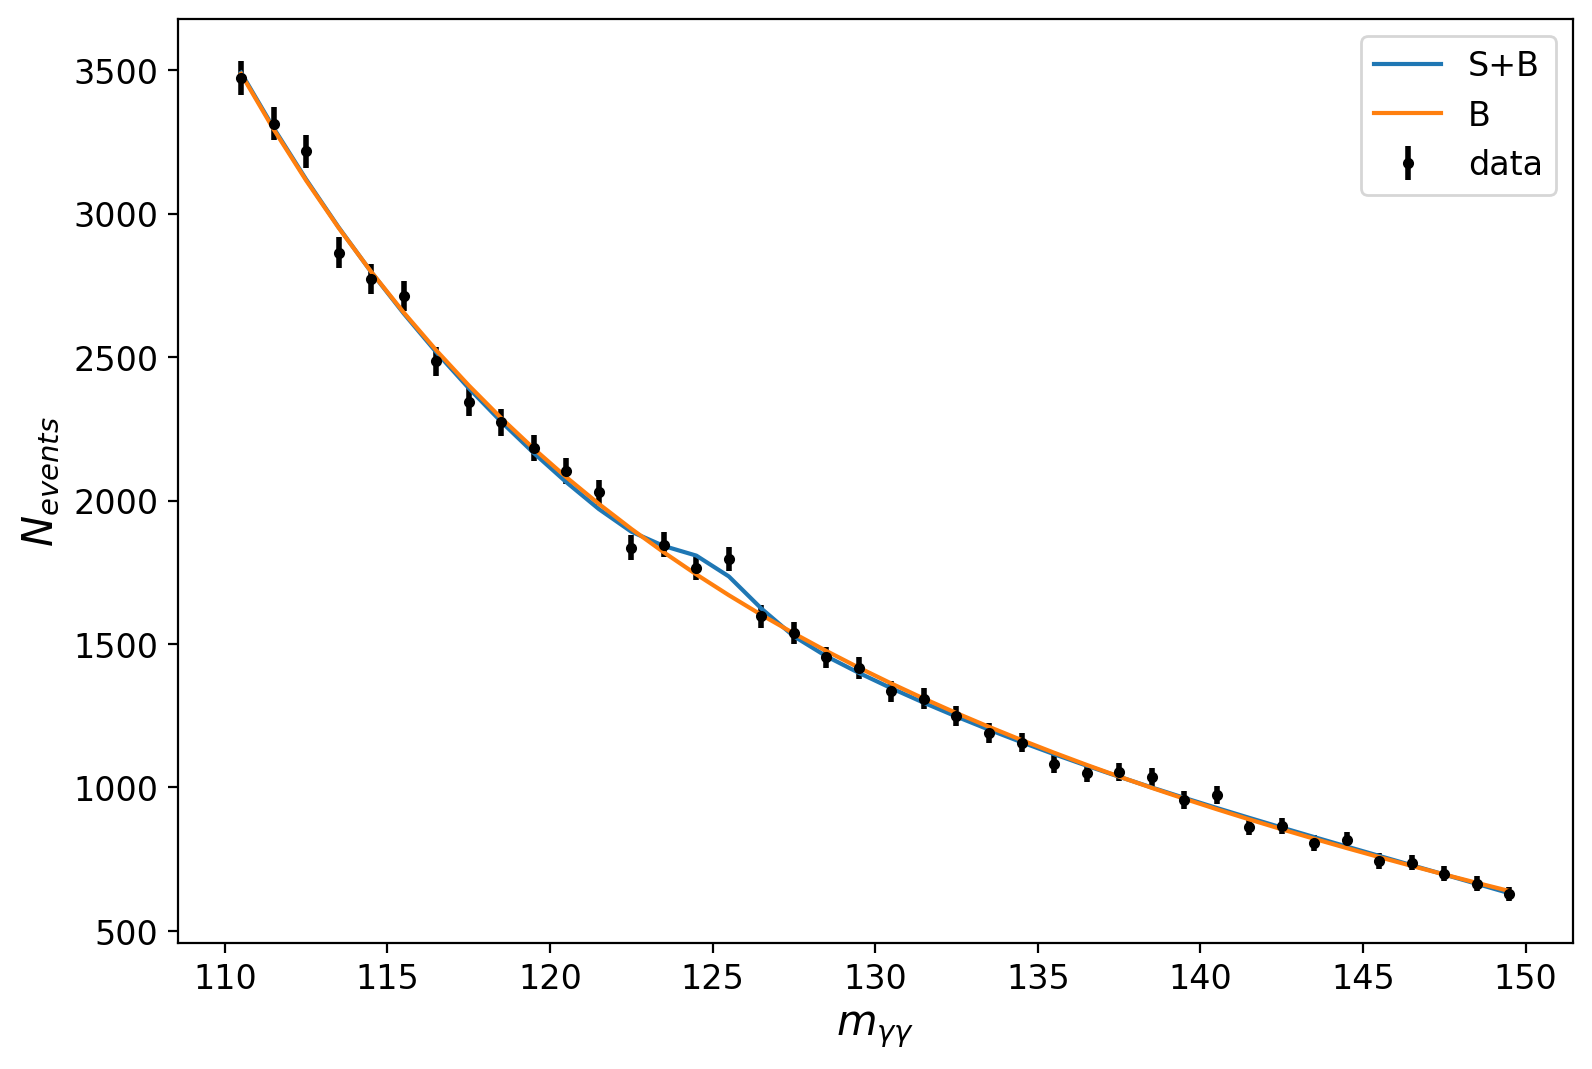

2NLL: 7.464852594191392 p-value 0.0062915182772264044


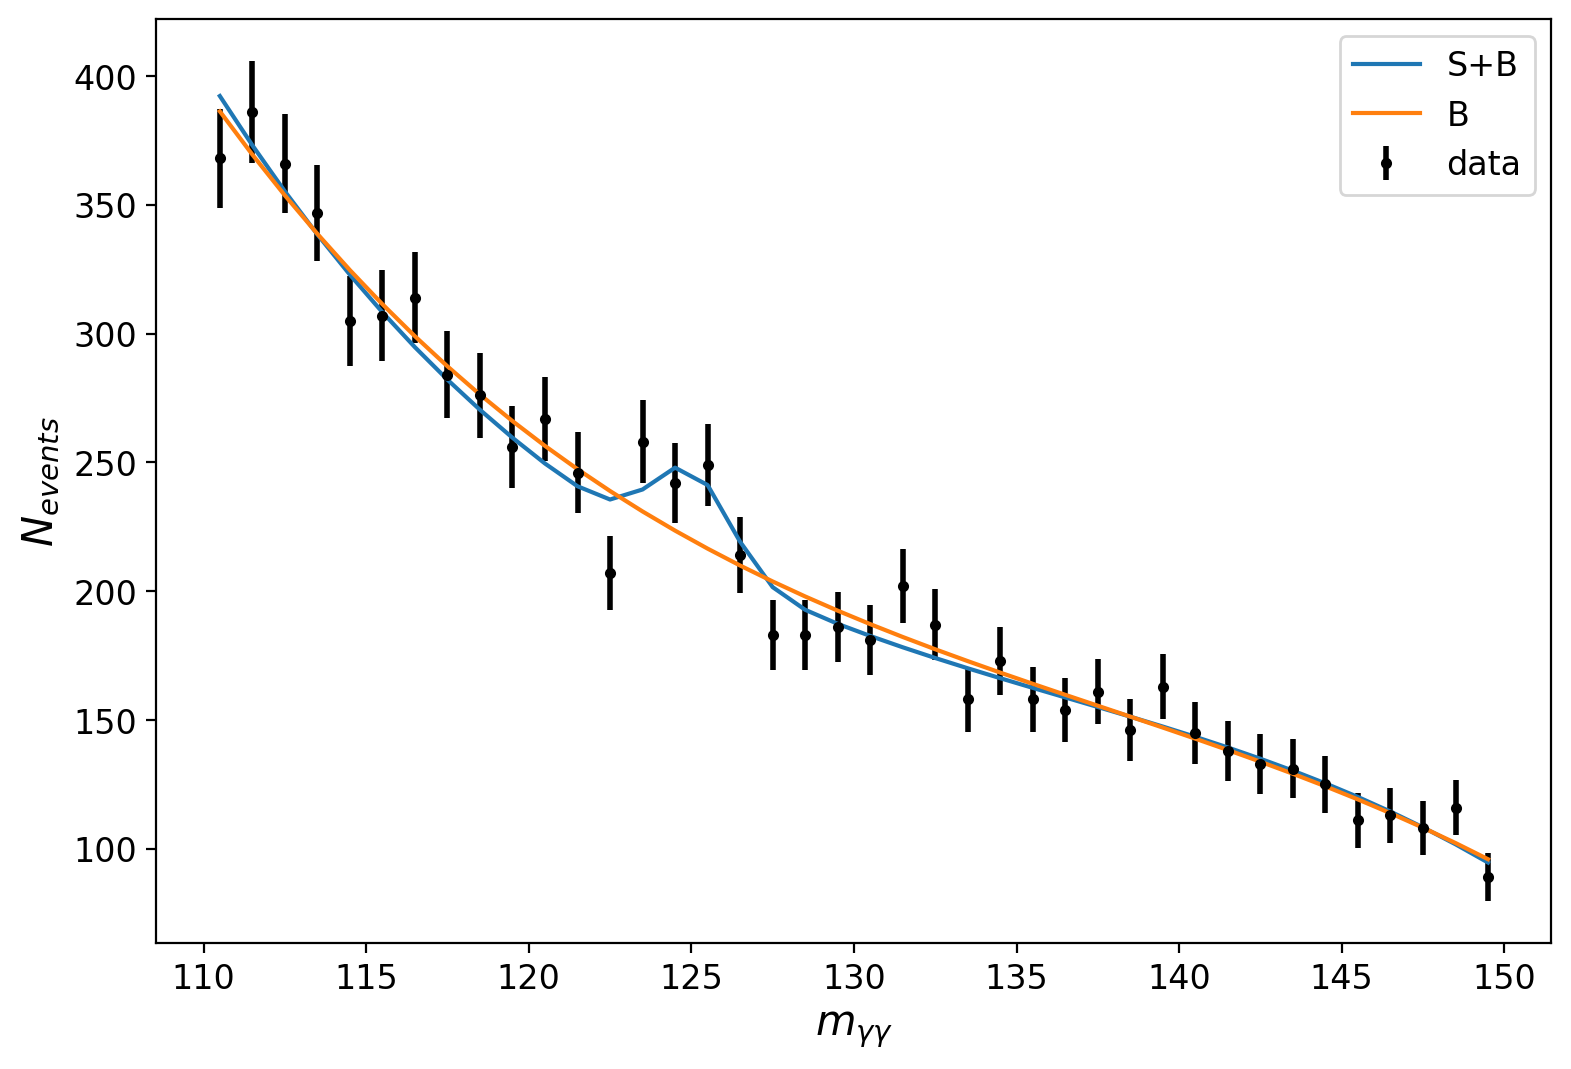

2NLL: 7.381865335424511 p-value 0.006588480073389302


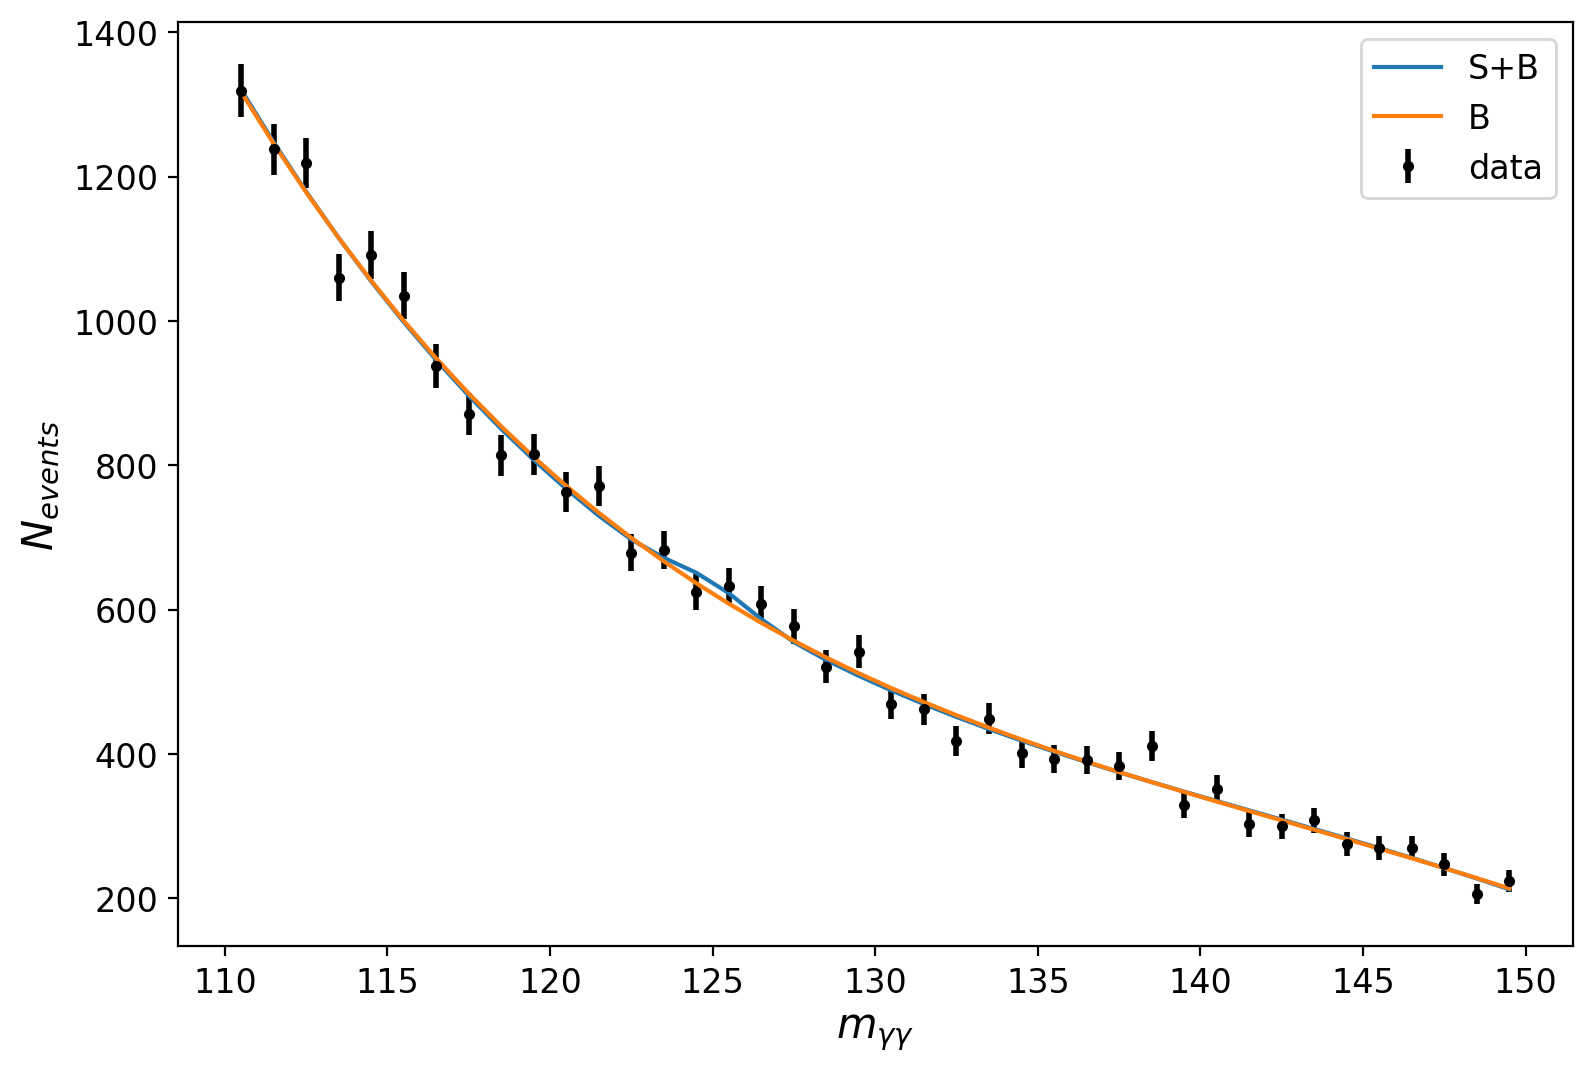

2NLL: 1.0185067753286035 p-value 0.31287346825415707


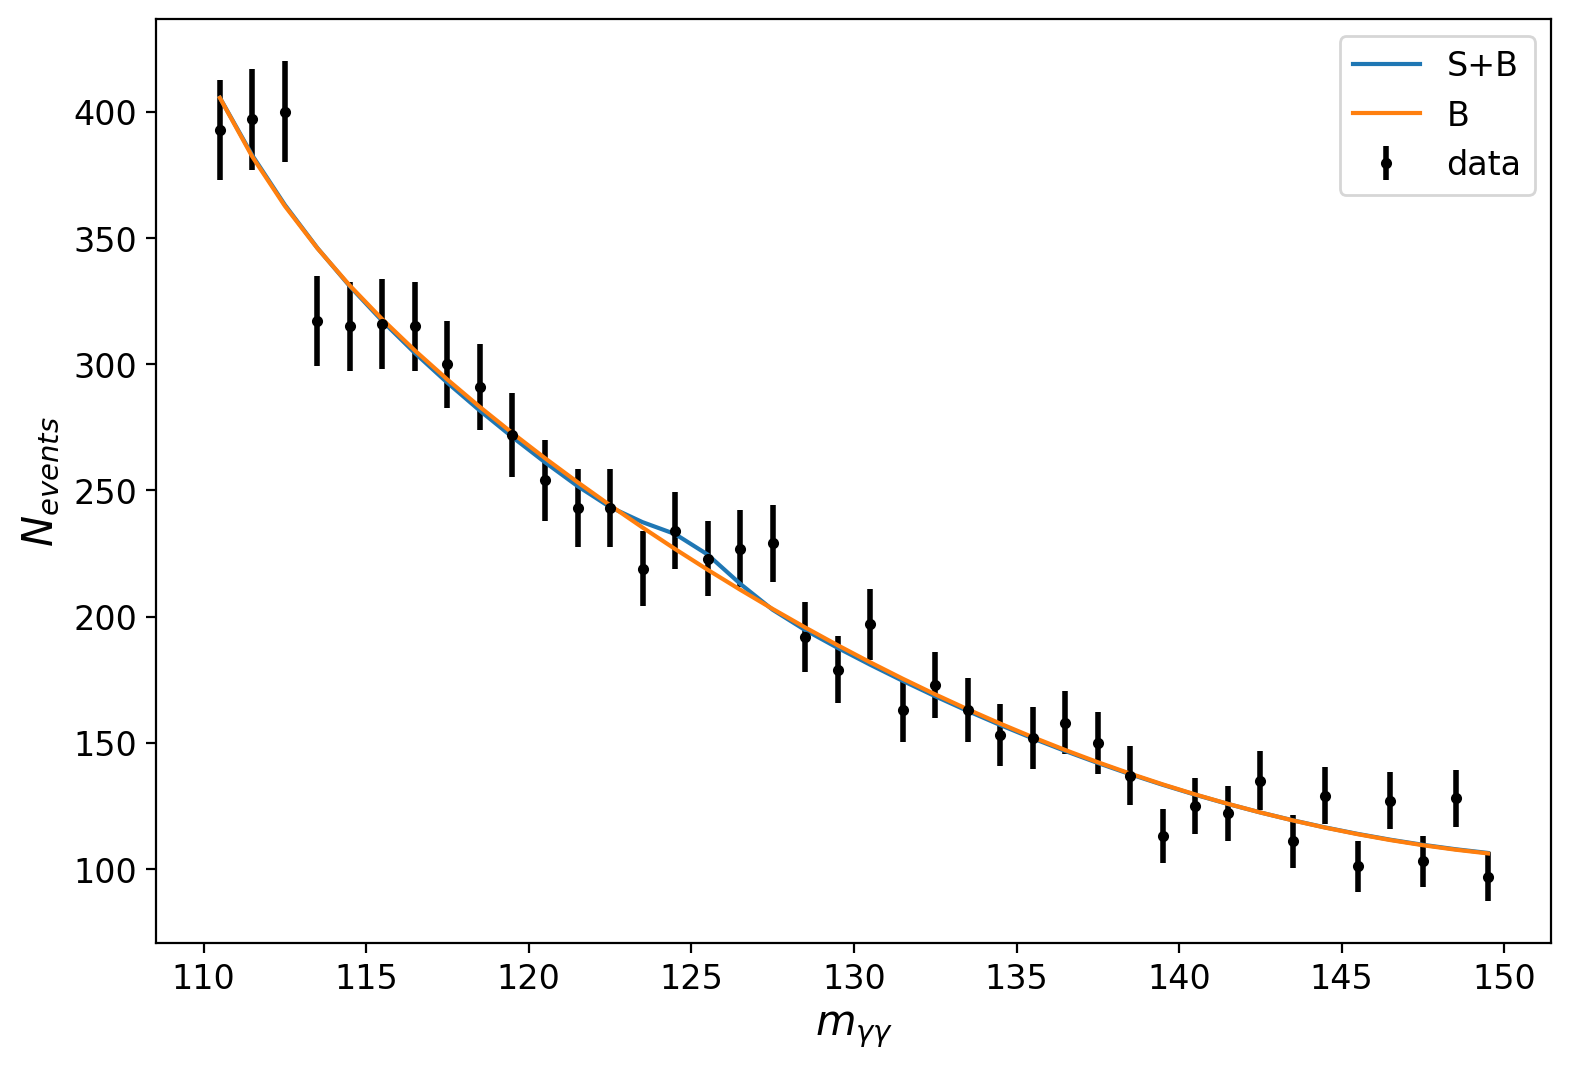

2NLL: 0.4573658316138136 p-value 0.4988576352196198


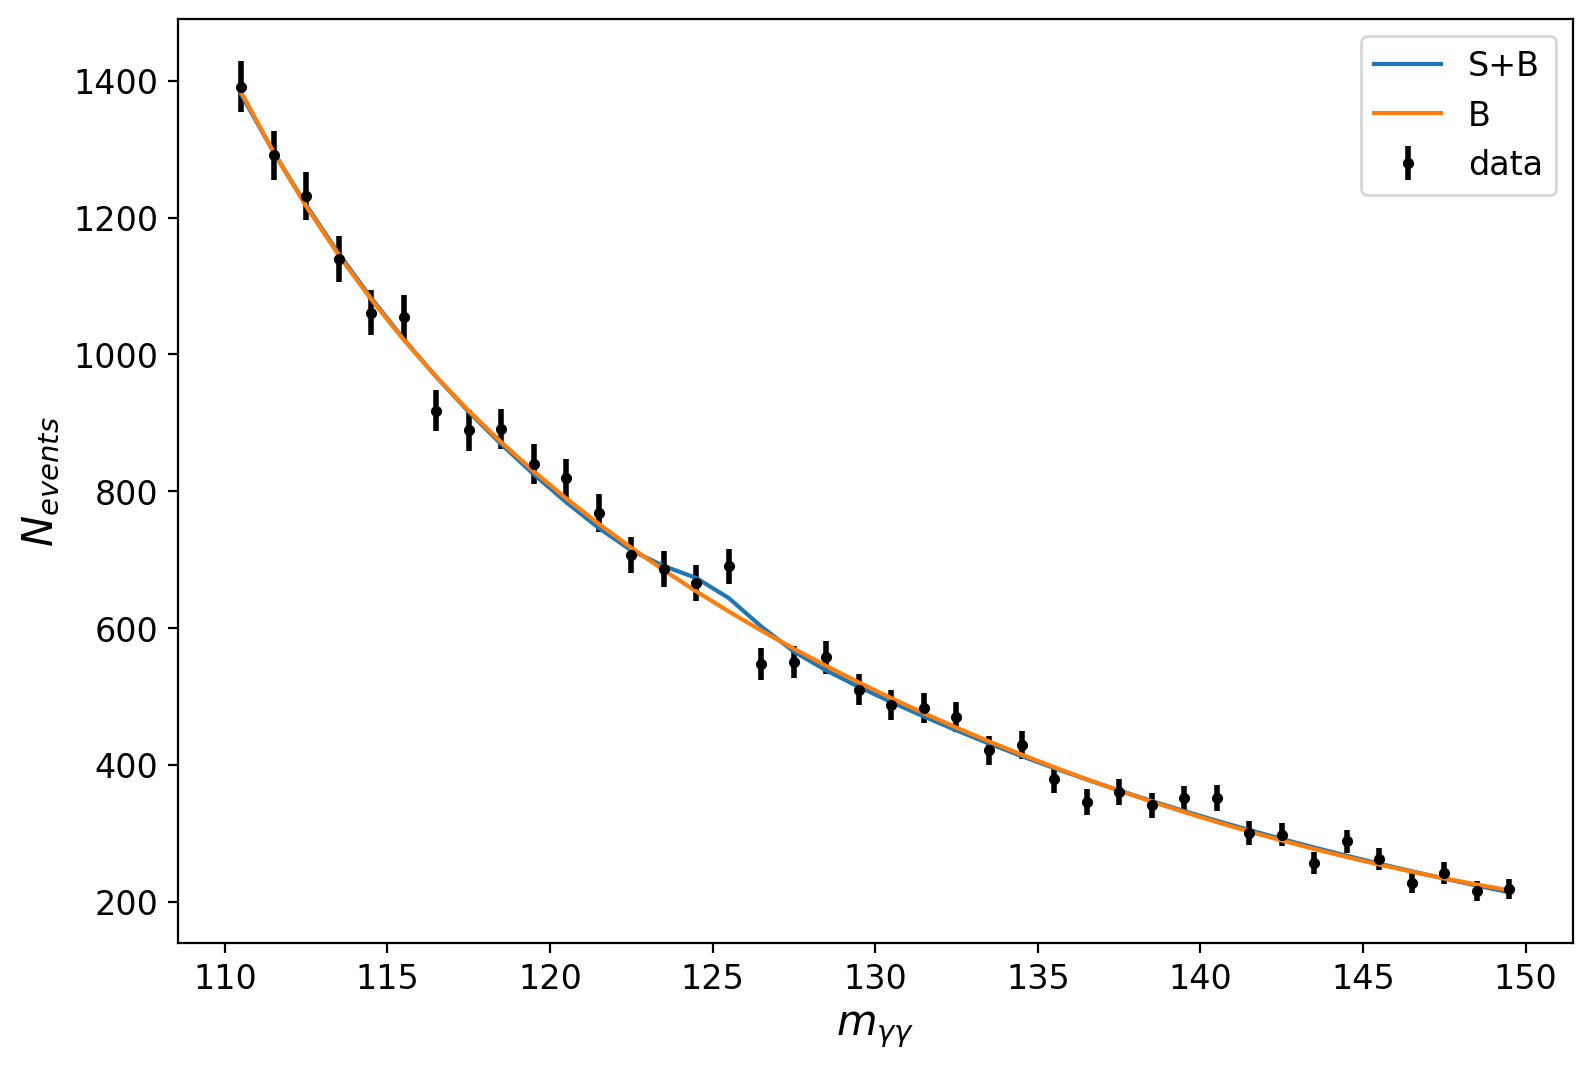

2NLL: 1.8417193344849565 p-value 0.1747495643713246


In [36]:
def fitModel(iX,iY,iWeights,iM,iFunc):
    model  = lmfit.Model(iFunc)
    p = model.make_params(p0=0,p1=0,p2=0,p3=0,p4=0,p5=0,amp=0,mass=iM,sigma=1.2)
    try:
        p["mass"].vary=False
        p["sigma"].vary=False
    except:
      a=1
      #print("Mass and Sigma not in fit")
    result = model.fit(data=iY,params=p,x=iX,weights=iWeights)
    output = model.eval(params=result.params,x=iX)
    return output,result.residual

def sigbkg5(x,p0,p1,p2,p3,p4,p5,amp,mass,sigma):
    bkg=bkg5(x,p0,p1,p2,p3,p4,p5)
    sig=amp*stats.norm.pdf(x,mass,sigma)
    return sig+bkg

#answer
NLL=fitSig("data/out.txt",125,sigbkg5,bkg5,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1))

NLL=fitSig("data/out2.txt",125,sigbkg5,bkg5,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1))

NLL=fitSig("data/out3.txt",125,sigbkg5,bkg5,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1))

NLL=fitSig("data/out4.txt",125,sigbkg5,bkg5,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1))

NLL=fitSig("data/out5.txt",125,sigbkg5,bkg5,True)
print("2NLL:",NLL,"p-value",1-stats.chi2.cdf(NLL,1))


Our p-value for this one category went down from 0.004 to 0.048. This means we are getting less excess. Could this mean we are more sensitive? Let's do the full combined p-value scan with this assumptions, and compare.  Note that the scan below now starts to take a little bit of time (few min). 

While you are waiting to run the code, maybe you can start to guess which function will be more sensitive? 

Moreover, given that, is there anything we gain from having multiple functions? 

Mass: 120.0
Mass: 121.11111111111111
Mass: 122.22222222222223
Mass: 123.33333333333333
Mass: 124.44444444444444
Mass: 125.55555555555556
Mass: 126.66666666666667
Mass: 127.77777777777777
Mass: 128.88888888888889
Mass: 130.0


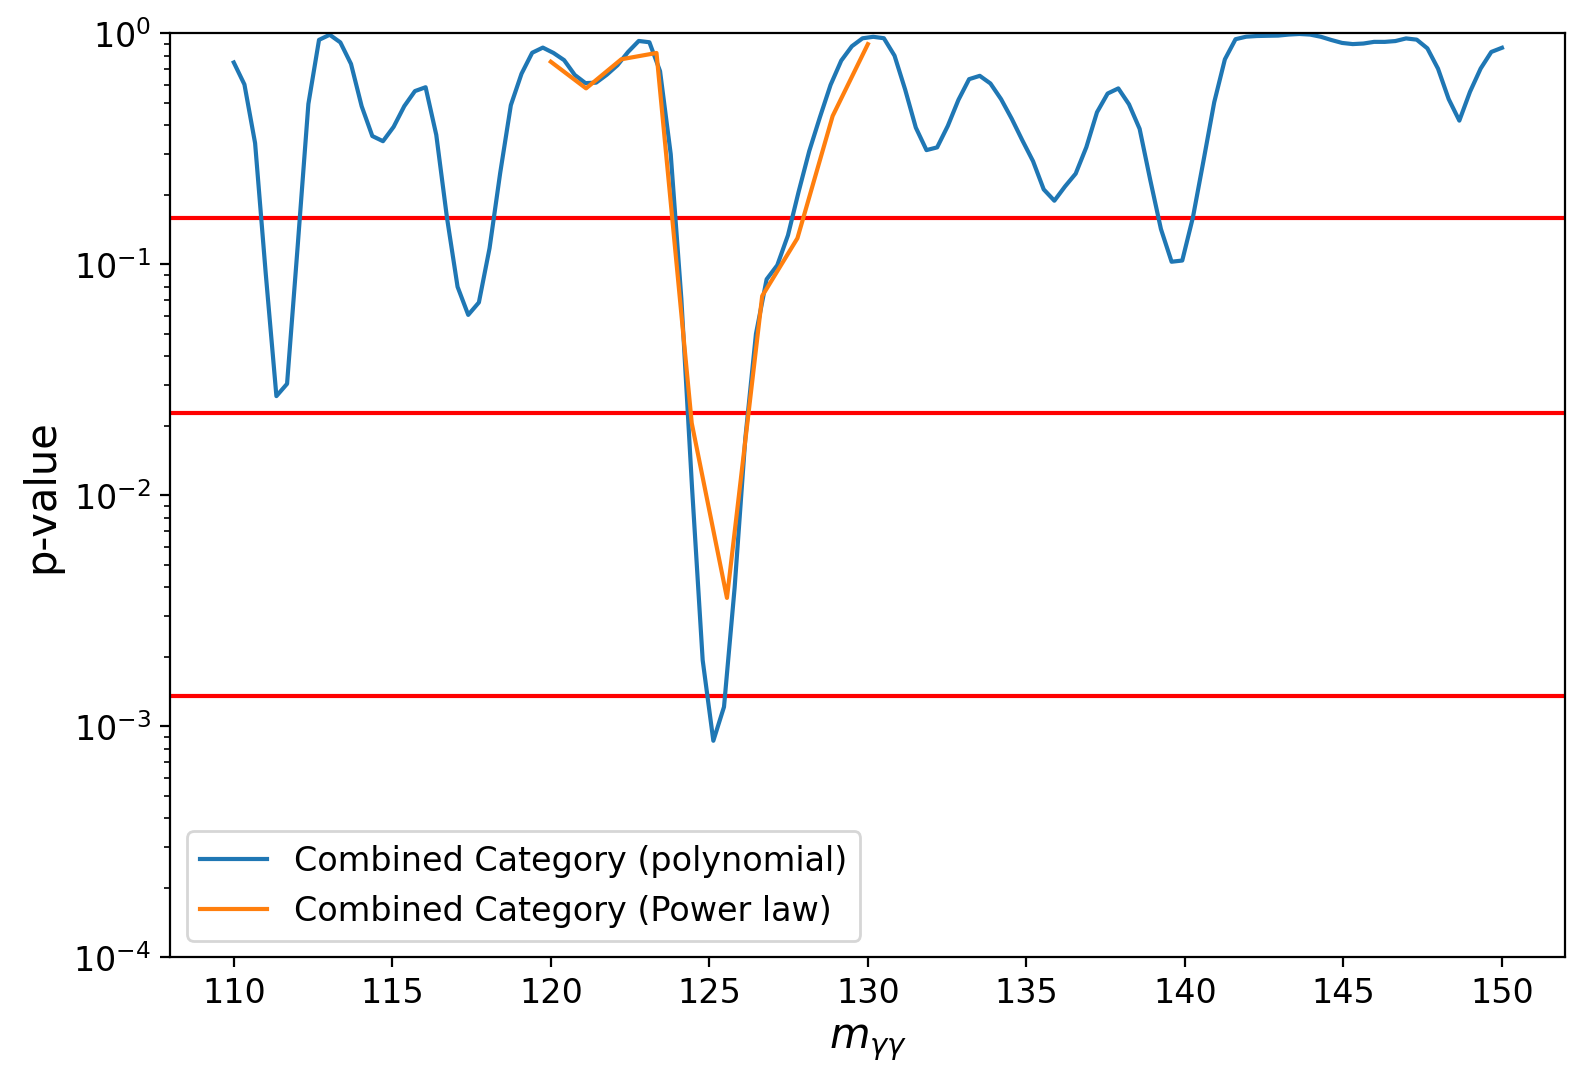

In [37]:
def pvaluePlot(iLabel,iSBFunc,iBFunc):
    pvalue = np.array([])
    massrange=np.linspace(120,130,10)
    for pMass in massrange:
        print("Mass:",pMass)
        pvalue = np.append(pvalue,pvalueCalc(iLabel,pMass,iSBFunc,iBFunc))
    return massrange,pvalue


files=["data/out.txt","data/out2.txt","data/out3.txt","data/out4.txt","data/out5.txt"]
mCB2,pCB2 = pvaluePlot(files,sigbkg5,bkg5)

for pVal in range(4):
    sigmas = 1-stats.norm.cdf(pVal+1)
    plt.axhline(y=sigmas, color='r', linestyle='-')
plt.plot(mC,pC,label="Combined Category (polynomial)")
plt.plot(mCB2,pCB2,label="Combined Category (Power law)")
plt.ylim((0.0001,1))
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("p-value")
plt.yscale("log")
plt.legend()
plt.show()


Now, in light of this, there has been a recent development known as discrete profiling that has allowed to extend the scope of our interpretations. The idea here is that if we account for our degrees of freedom to be different, we can profile a whole library of functions simultaneously, and we can compare all of them by looking at their corrected likelihood. 

To do this, we are going to do something a little ad-hoc here and just look at one explempary category so that we can really understand how the envelope changes our measurements. What we will do below, is replace our p-value with a likelihood scan, then we will scan around the Higgs mass and show the likelihood

In [ ]:
def logCalc(iLabel,pMass,iSBFunc,iBFunc,iNDOF):
    lNLL=iNDOF
    for pLabel in iLabel:
        pNLL=fitSig(pLabel,pMass,iSBFunc,iBFunc,False)
        lNLL -= pNLL
    return lNLL

def NLLPlot(iLabel,iSBFunc,iBFunc,iNDOF):
    NLL = np.array([])
    massrange=np.linspace(124,126,20)
    for pMass in massrange:
        NLL = np.append(NLL,logCalc(iLabel,pMass,iSBFunc,iBFunc,iNDOF))
    return massrange,NLL

files=["data/out2.txt"]
mCB2,lLLB = NLLPlot(files,sigbkg5,bkg5,5)
mCP2,lLLP = NLLPlot(files,sigpol4,pol4,5)

plt.plot(mCP2,lLLP,label="Combined Category (polynomial)")
plt.plot(mCB2,lLLB,label="Combined Category (Power law)")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$-2\Delta LL$")
plt.legend()
plt.show()


The true minimum is defined by the envelope in the corrected likelihood, that really gives us the full information that enables us to quote a result. Discrete profiling thus enables us to get even more sensitive if our envelope narrows. However, its often that it widens, this is the uncertainty coming in from function choice. The point being is that by being more expressive by adding more function choices, we naturally give the fit more flexibility to fit well. If there are more options that fit well, then our uncertainties get larger.

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-12.4.1</span>

Based on the above envelope compute the Higgs mass? 


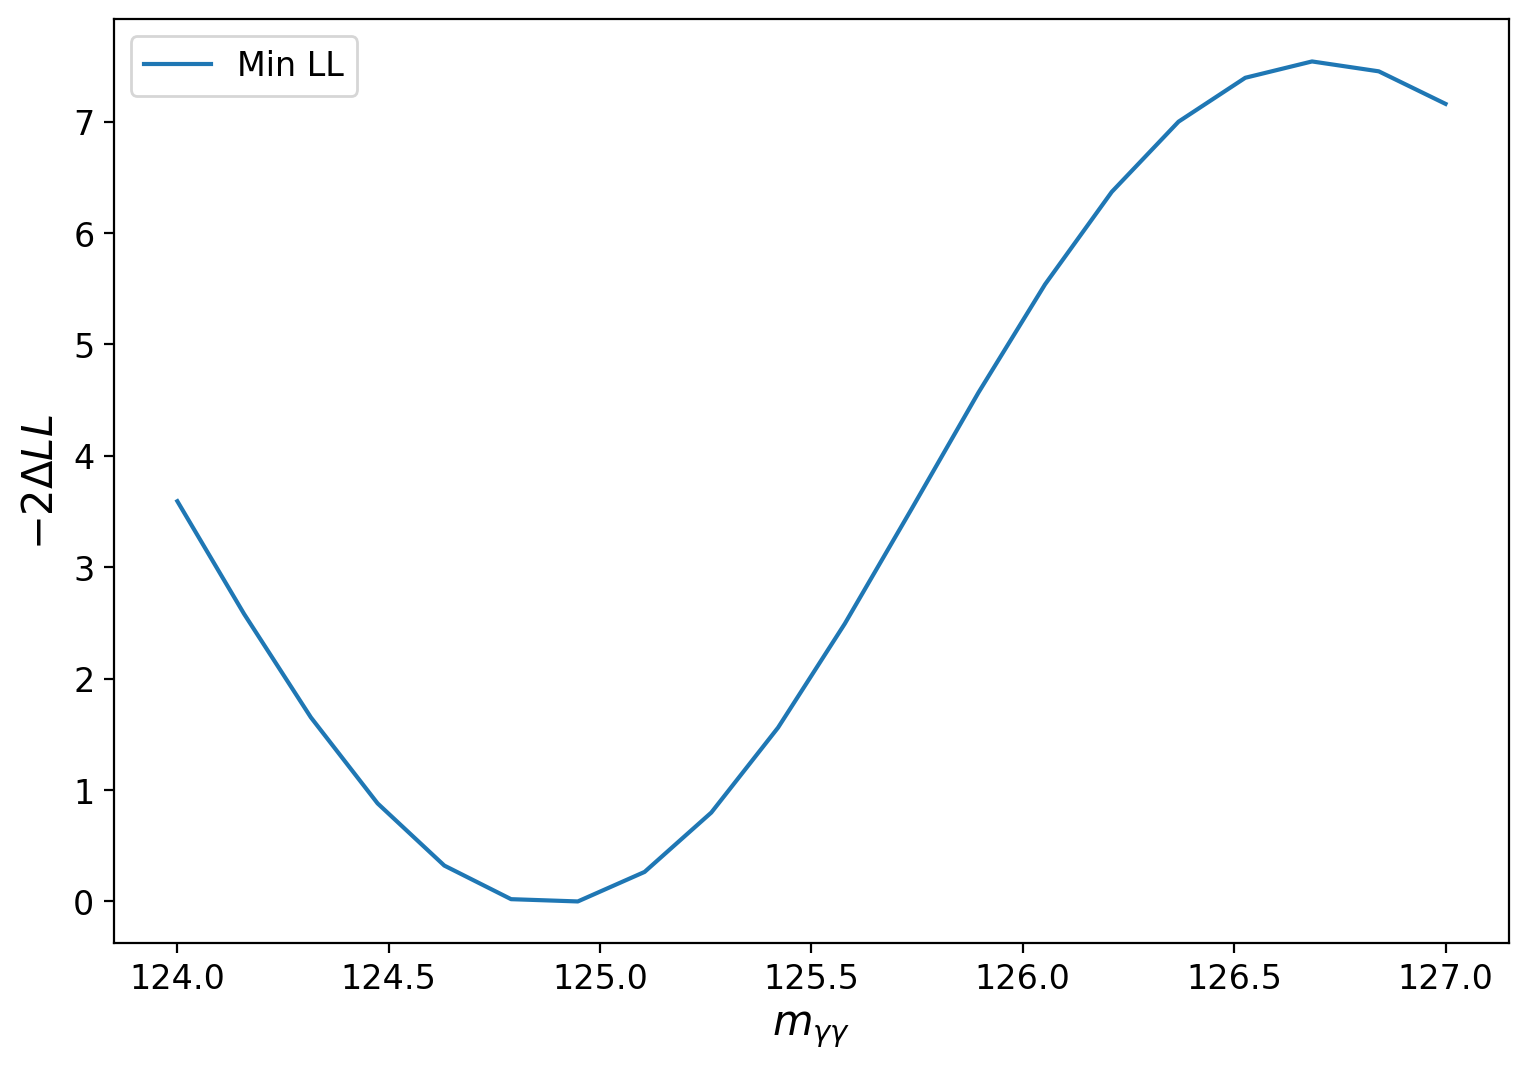

In [43]:
minall=np.minimum(lLLB.flatten(),lLLP.flatten())
minall=np.min(minall)
plt.plot(mCB2,np.minimum(lLLB,lLLP)-minall,label="Min LL")
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$-2\Delta LL$")
plt.legend()
plt.show()

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
Our best fit mass is from 124.4 to 125.3 => 124.8 +/- 0.35 (almost spont on!)
</pre>
        
**EXPLANATION:**
The minimum is not now a quadratic and has a bulge on the left. This shows we have added a systematic for function choice and made the uncertainties slightly larger. 
    
</div>


<a name='section_12_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.5 Convolutions</h2>  



Convlutions are a critical component of evey good statistical analysis. Its a way to multiply distributions together. 
Lets build convlutions up by scratch and then go from there. 

The core concept of a convolution is that you are effectively multiplying distributions. Given two functions $f(x)$ and $g(x)$, we can define convolutions by 
\begin{eqnarray}
(f*g)(t) &=& \int^{\infty}_{-\infty} f(z)g(t-z)dz
\end{eqnarray}
For data analysis, we usually think about this in the context of probability distribuitons $g$ and $f$. From here, we construct a new probability distribution $(g*f)$. Anyway, lets take a look at how it works. 

![alternative text](convolution.gif)

To do this, lets first define some functions to convolve. 

In [52]:
#First lets define a triangular distribution
def triangle(x,mean=5):
    Norm=mean*mean
    val=np.where(x <= mean,np.maximum(x,np.zeros(len(x))), np.maximum(2*mean-x,np.zeros(len(x))))
    return val/Norm

#Now define the gaussian
def gaussian(x,mean=0,sigma=1):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 


In [60]:
#Now lets do a convolution by hand
def convolve(f1,f2,x,sigma=1,iMin=-10,iMax=10,iN=2000):
    step=(iMax-iMin)/iN
    pInt=0
    for i0 in range(iN):
            pX   = np.repeat(i0*step+iMin,len(x))
            pVal = f1(x-pX,sigma=sigma)*f2(pX)
            pInt += pVal*step
    return pInt

print(np.repeat(1.,10))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


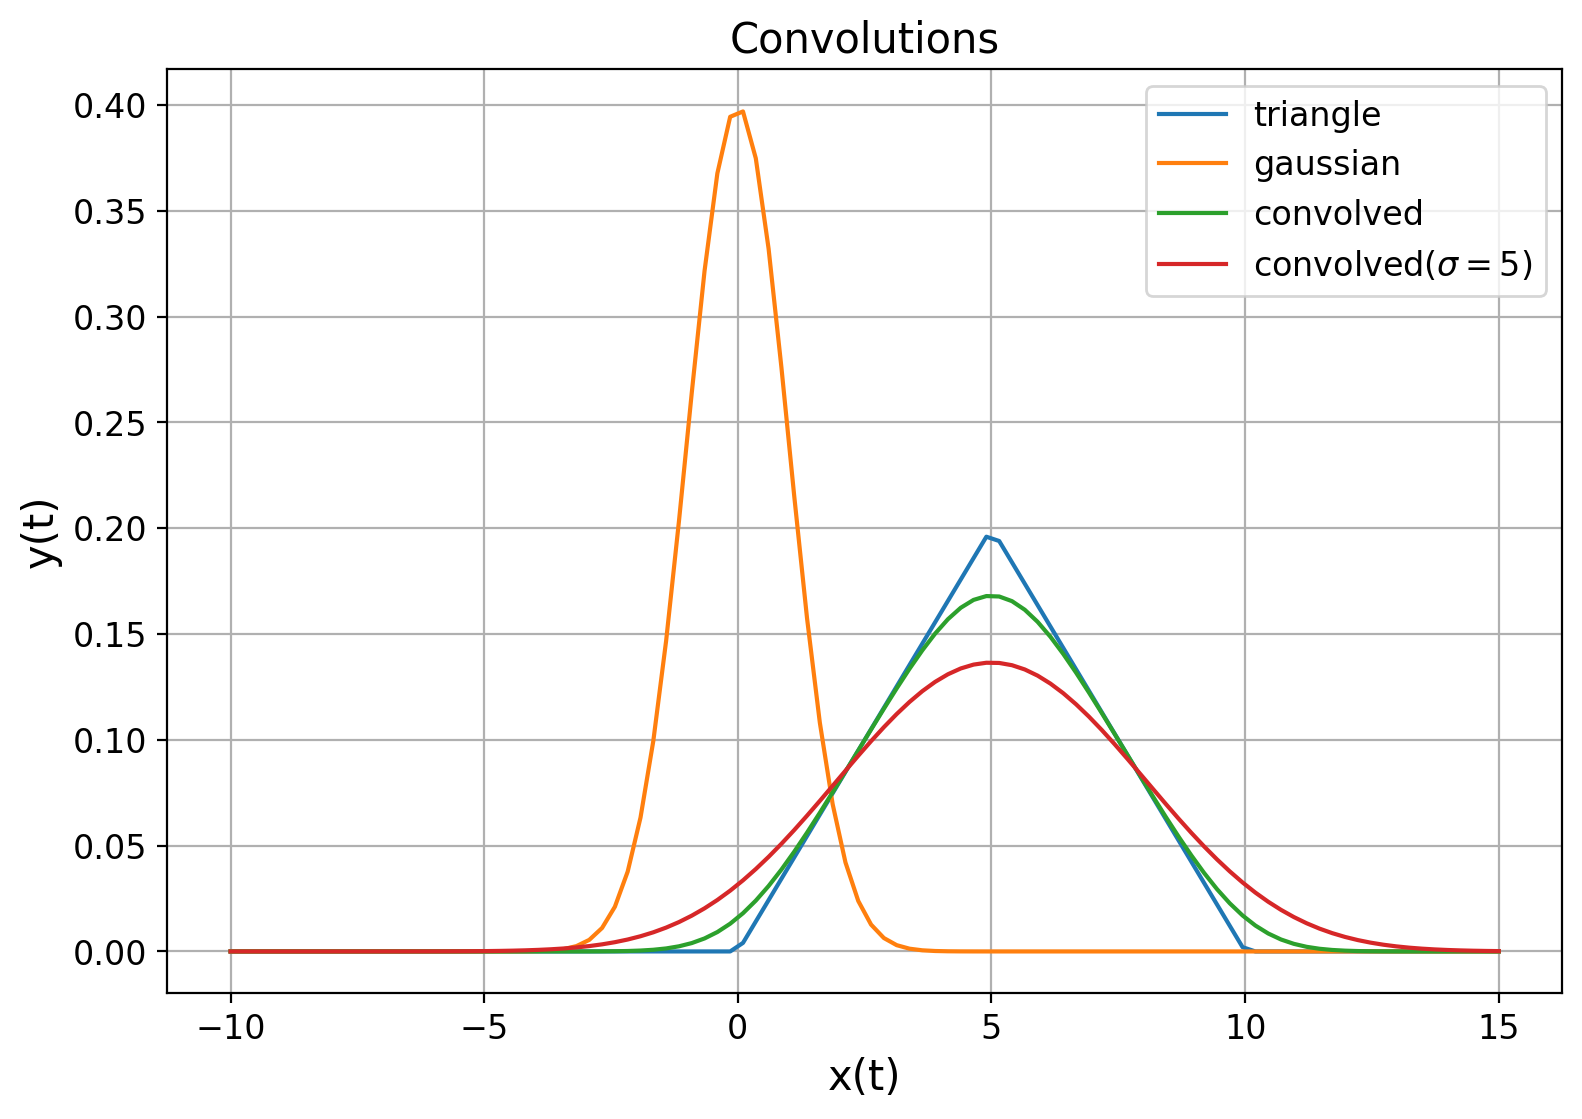

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
tri_out=triangle(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,triangle,x_in)
conv2_out=convolve(gaussian,triangle,x_in,sigma=2)

ax.plot(x_in,tri_out,label='triangle')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=5$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

So why are these convolutions so important? 

We can get a picture of how important these are 

![alternative text](gauss_blur.png)

Effectively, when we have poor resolution of things coming from an uncertainty in how we measure something. Distributions, which are originally nice and sharp can get smeared out. The easy way to describe all of these is through a convolution. There is a rich literature to discribe convolutions. 

A critical element to remember about the convolutions is that in Fourier space convolutions can be performed as straight multiplications and then inversing the fourier transform.  


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.5.1</span>

What happens if you convolve a Gaussian with a straight line: $y=0$? You can use the code from the previous cell to plot it.


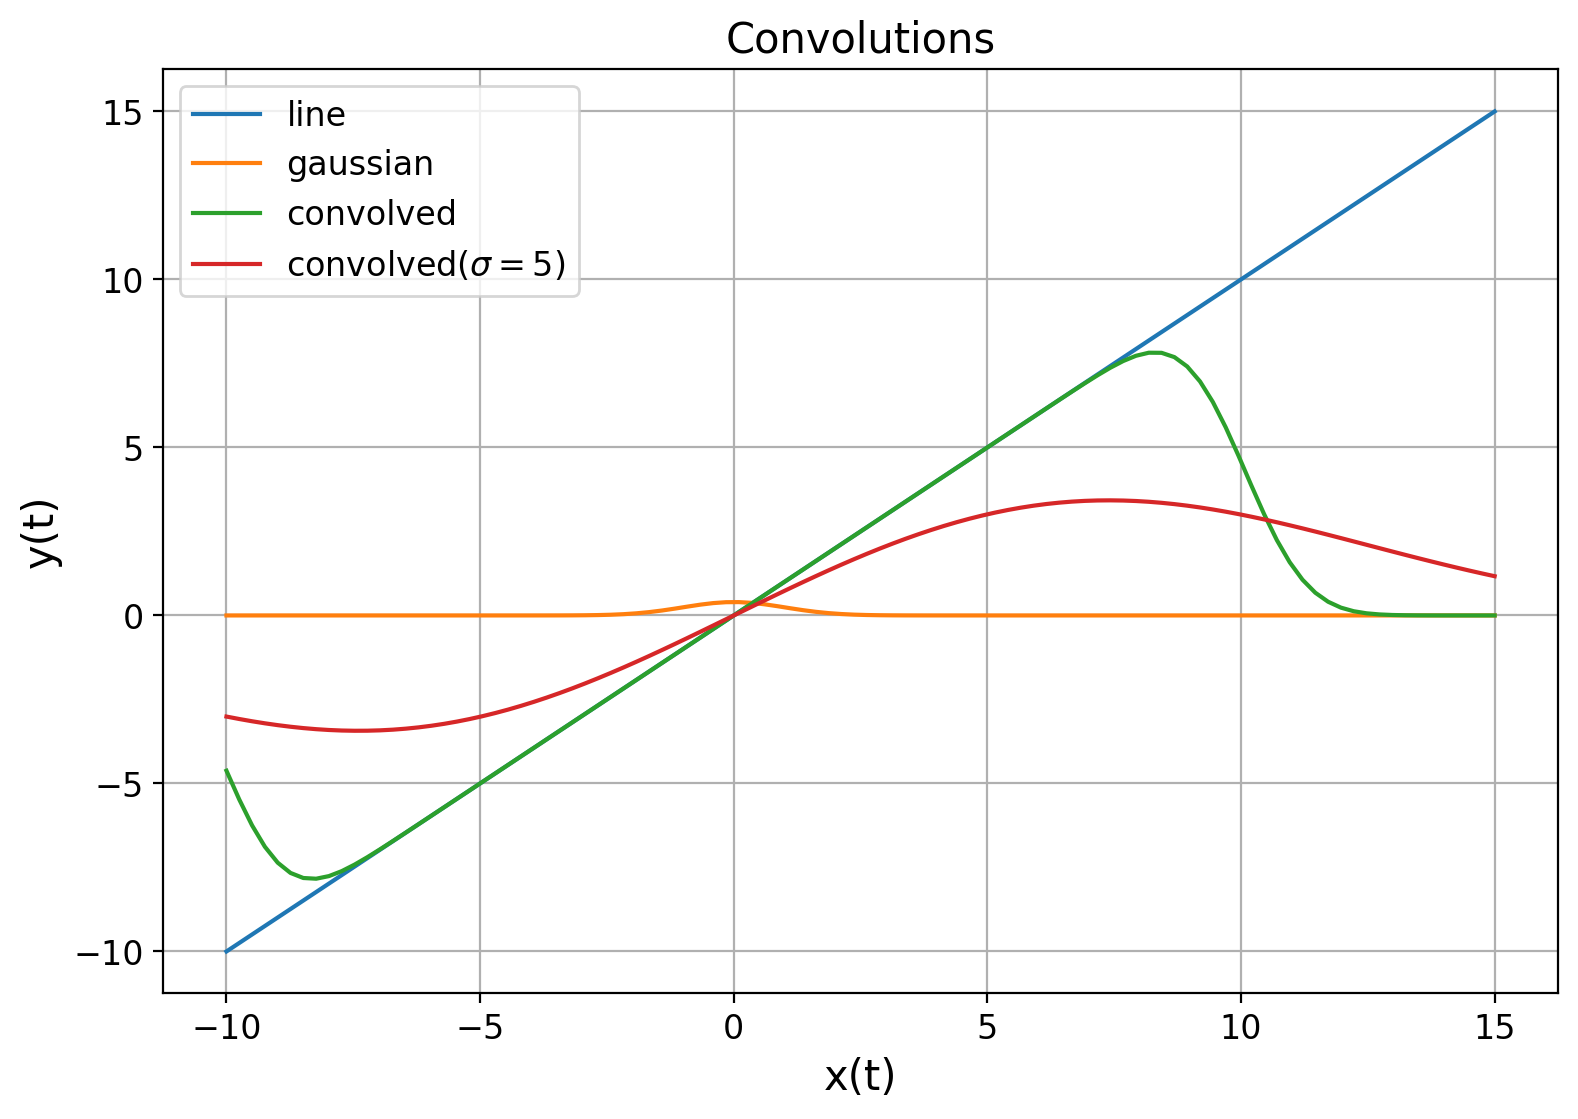

In [62]:
#>>>SOLUTION

def line(x):
  return x 

fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
line_out=line(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,line,x_in)
conv2_out=convolve(gaussian,line,x_in,sigma=5)

ax.plot(x_in,line_out,label='line')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=5$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
See code above
</pre>
        
**EXPLANATION:**
    
The convolution will stretch out the line by weighting points with a gaussian. The stretching only occurs on the boundary where the convolution is underway. As a result, the core line doesn't actually change in shape. 
    
</div>

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.5.2</span>

What happens if you convolve a Gaussian with a Gaussian? (you can again use the code before it)

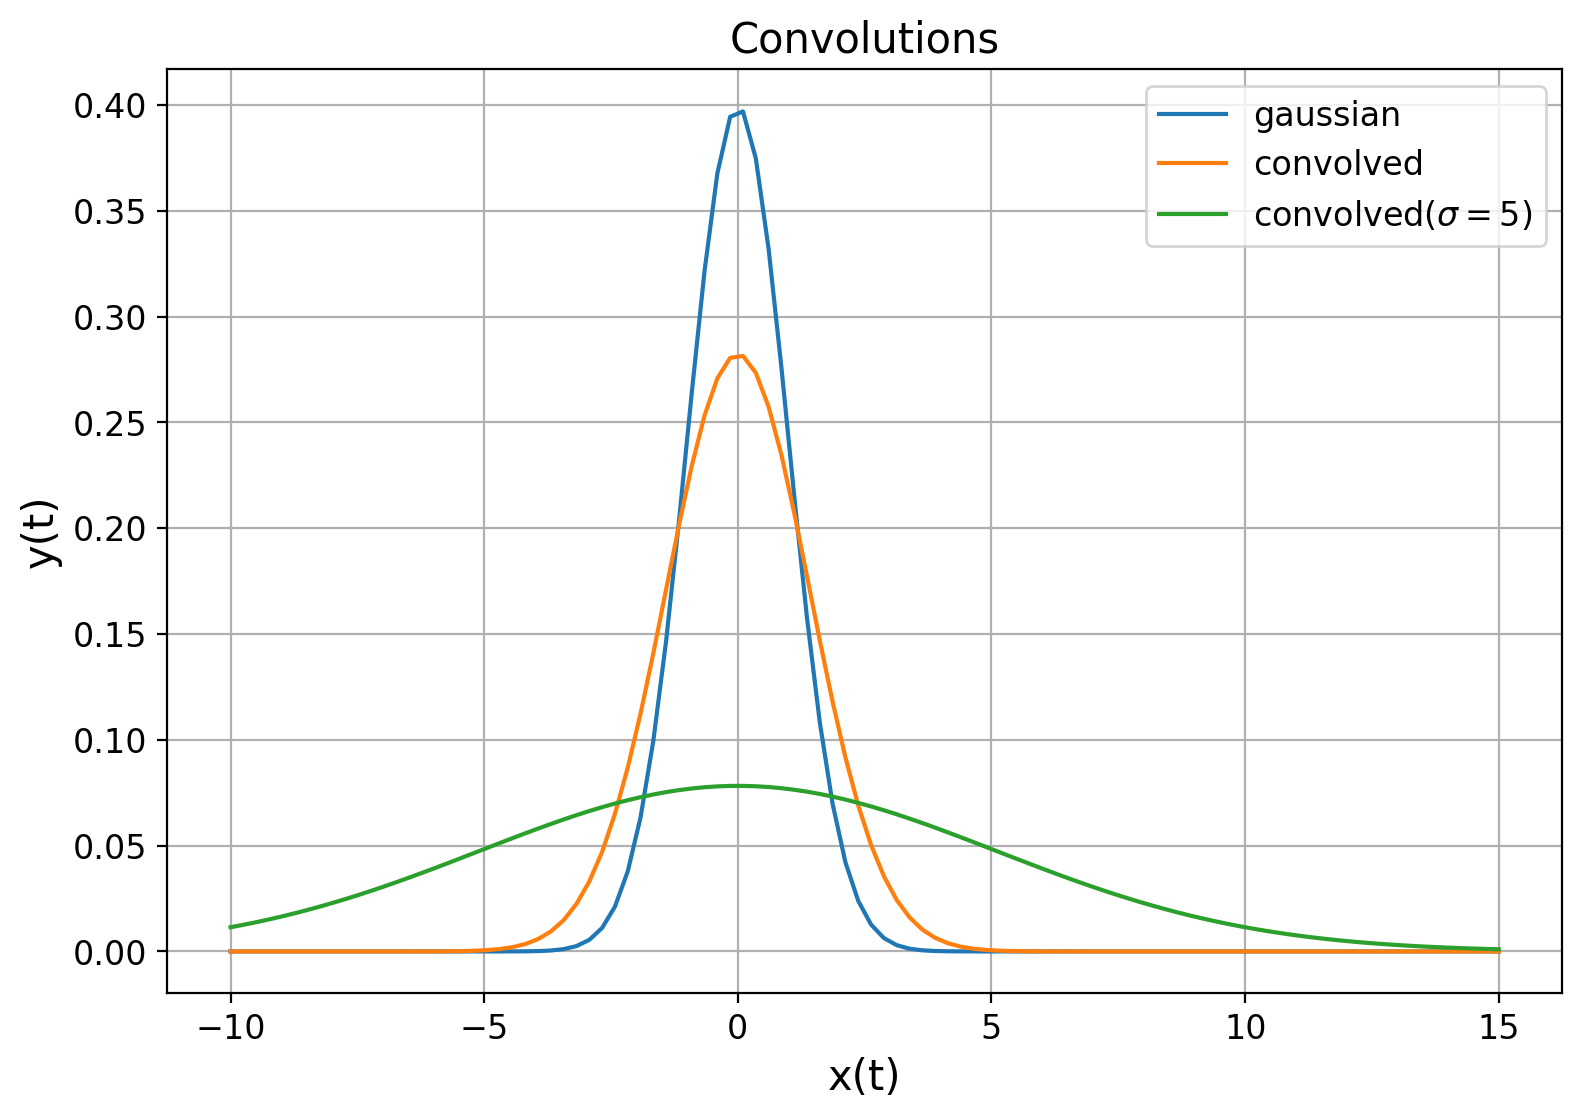

In [63]:
#>>>SOLUTION


fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
line_out=line(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,gaussian,x_in)
conv2_out=convolve(gaussian,gaussian,x_in,sigma=5)

ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=5$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
See code above
</pre>
        
**EXPLANATION:**
    
A Gauassian convolved with a gaussian just gives you another Gaussian, you can prove this by fourier transforming the convolution and noting that according to the [Convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) a convolution is just equal to a product of fourier transforms. 

</div>

### challenge question

What does $f(x)=\sin(x)$ convoled with a gaussian look like? How does it change by the resolution of the gaussian?

In [ ]:
def func(x):
    return np.sin(x)*x

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
func_out=func(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,func,x_in)
conv2_out=convolve(gaussian,func,x_in,sigma=2)

ax.plot(x_in,func_out,label='sin(x)')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=2$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

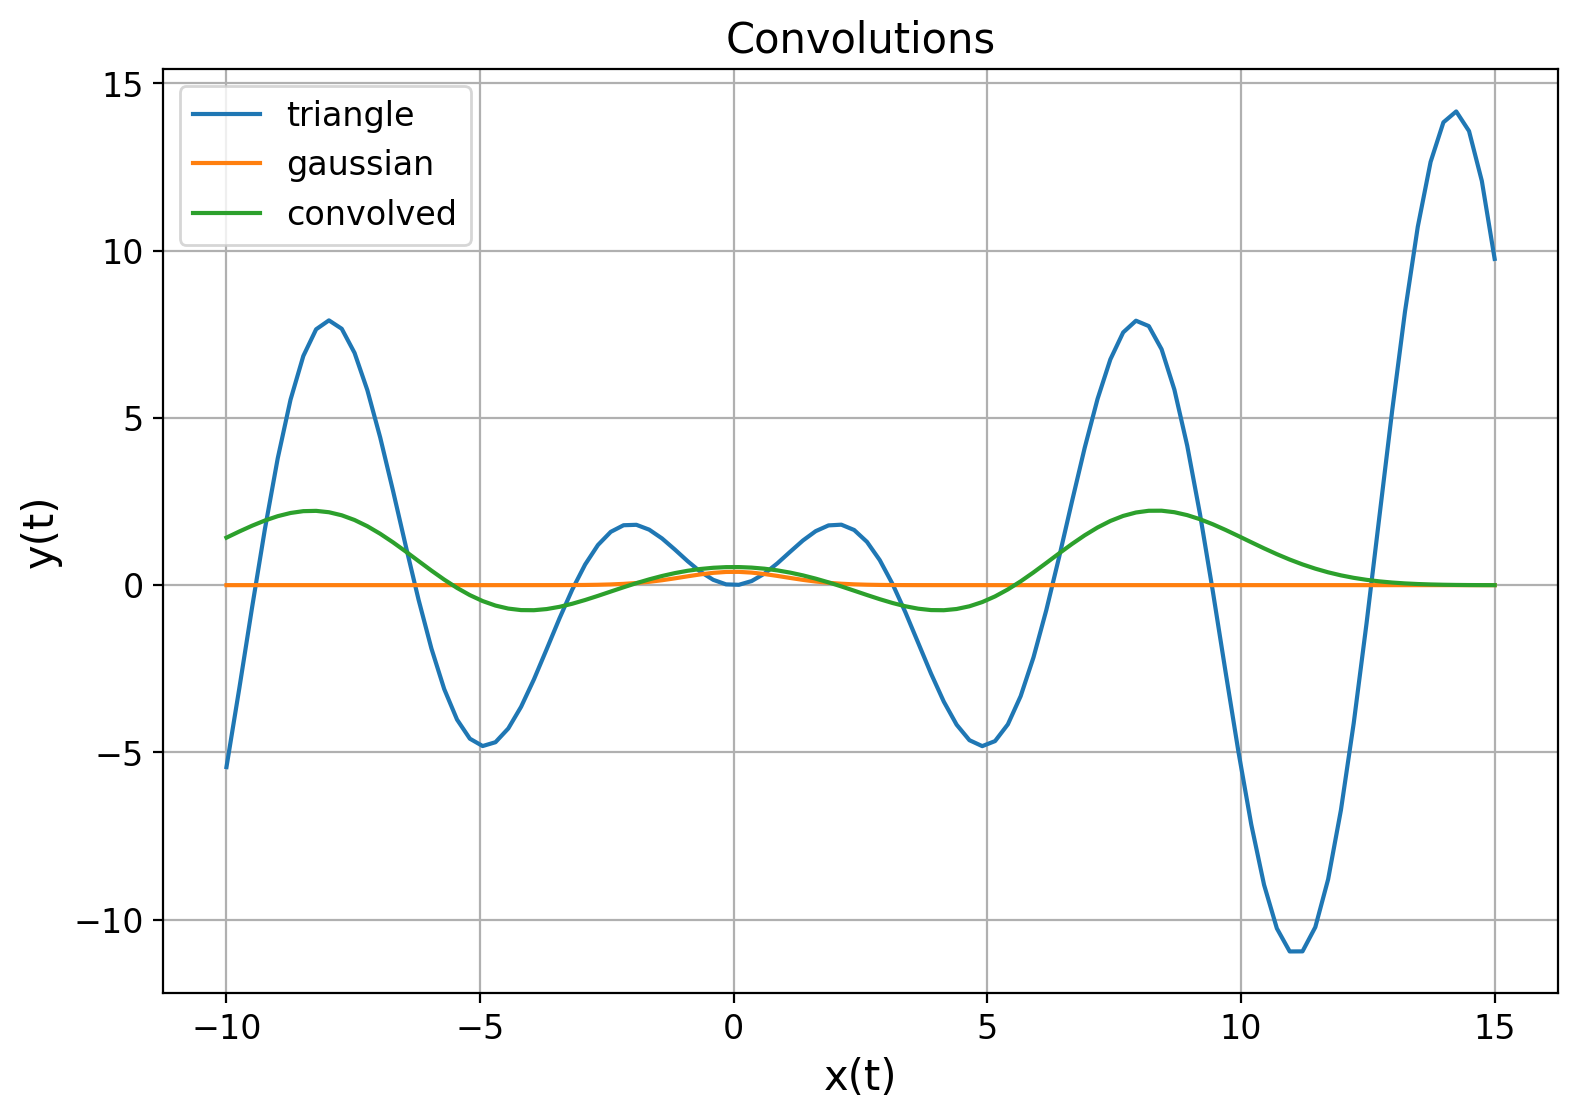

In [65]:
#answer
def func(x):
    return np.sin(x)*x

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
sin_out=func(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,func,x_in,sigma=2)


ax.plot(x_in,sin_out,label='triangle')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.5.3</span>

Often we use convolutions to "Smear" our distributions analytically without having to build a simulation. In the code below we sample points from a gaussian. Take the original function below ( a box disribution), add points sampled by a gaussian, and show that the distribution matches the convolution.

In [ ]:
#>>>EXERCISE
# Use this cell for drafting your solution (if desired),
# then enter your solution in the interactive problem online to be graded.
lNToys=1000
nbins=100
sigma=1
smeared=np.random.normal(0,sigma,(lNToys,nbins))
x_in=np.linspace(-20, 20,(nbins))
smeared_x_in=#your code here, make 1000 example x distributiosn from above

def func(x):
    return 0+0.1*np.where(x < -10,0,1) - 0.1*np.where(x < 10,0,1)

box_out=func(x_in)
smeared_box_out=#your code here, average over 1000 sampled distributions



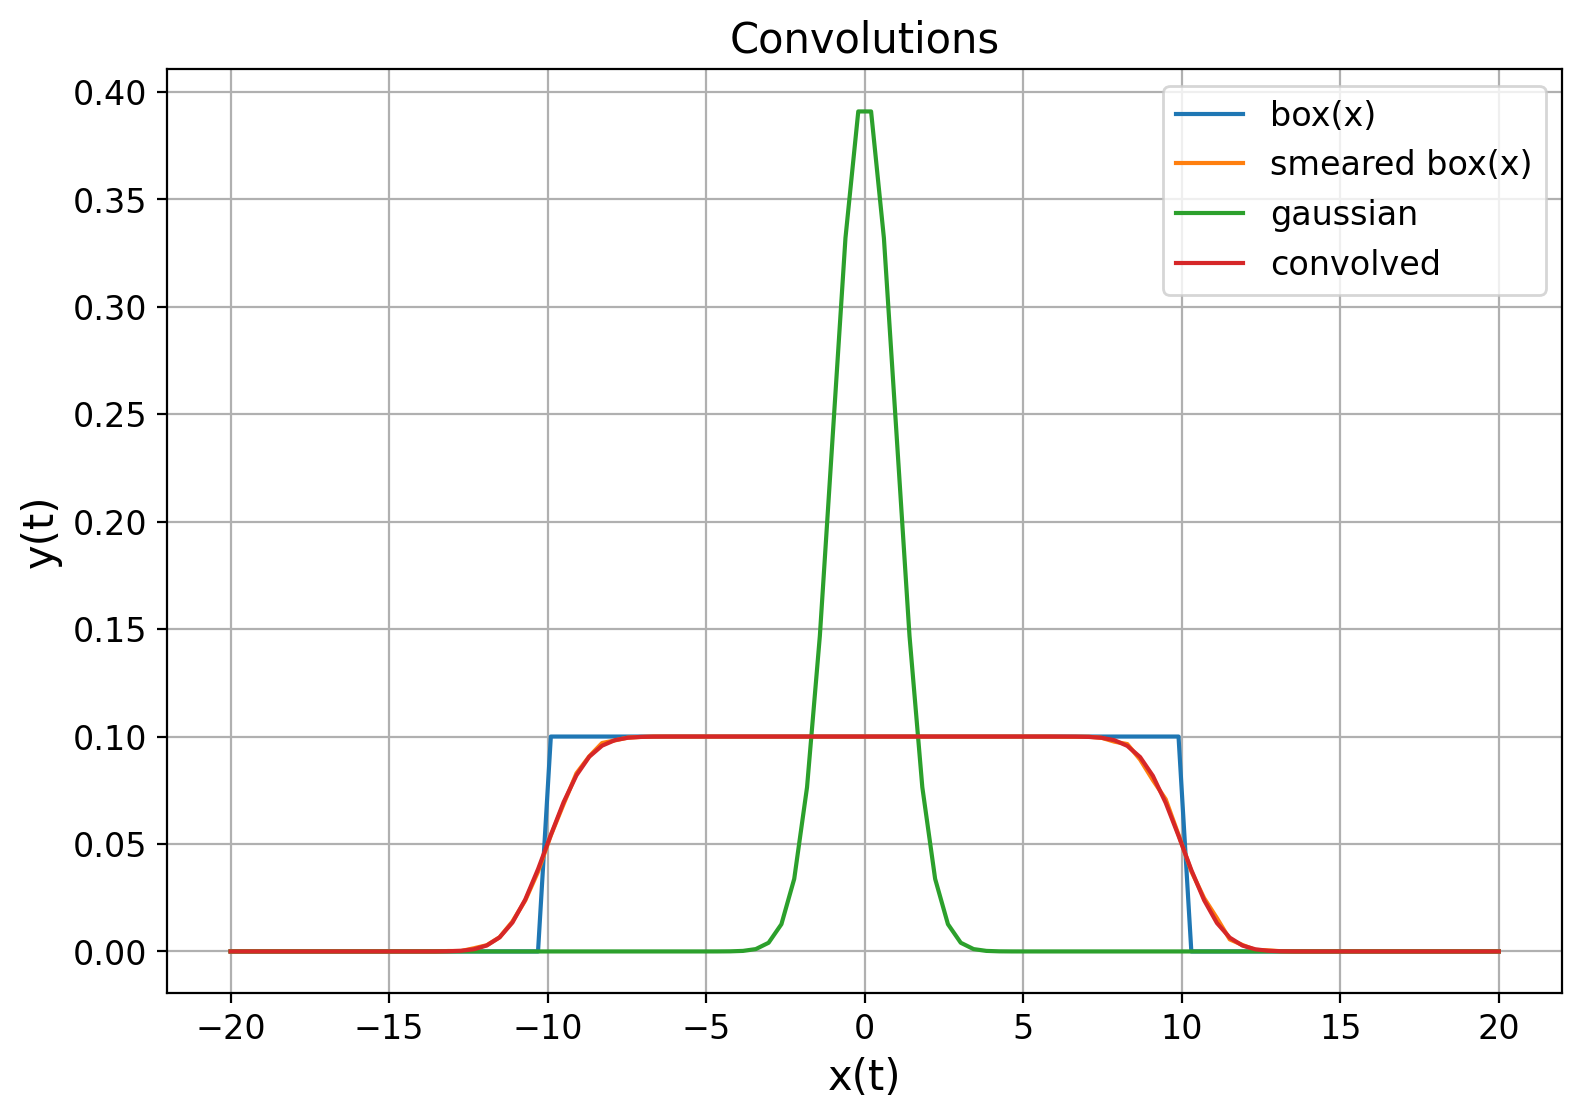

In [66]:
#>>>SOLUTION
#>>>RUN
lNToys=1000
nbins=100
sigma=1
smeared=np.random.normal(0,sigma,(lNToys,nbins))
x_in=np.linspace(-20, 20,(nbins))
smeared_x_in=x_in+smeared

def func(x):
    return 0+0.1*np.where(x < -10,0,1) - 0.1*np.where(x < 10,0,1)

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-20, 20, 100)
box_out=func(x_in)
smeared_box_out=np.mean(func(smeared_x_in),axis=0)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,func,x_in)


ax.plot(x_in,box_out,label='box(x)')
ax.plot(x_in,smeared_box_out,label='smeared box(x)')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
See code above
</pre>
        
**EXPLANATION:**
    
This is a first demonstration of a monte carlo technique to approximate a resolution. In Monte Carlo, we randomly sample distributions and then simulate them to mimic the effect that we would like our output to look like. In this case, we are smearing our inputs and applying a function on our smeared inputs. Knowing when to integrate and when to sample is something that is very powerful as we go forward. 
    
</div>


<a name='section_12_6'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.6 Building Interpolated Distributions</h2>  


To find the right fit function, we used a library of functions to profile and find the minimum. Thanks to the f-statistic, we don't need to just throw one function at the problem, we can throw many. In fact, modern searches aiming for the most sensitivity will send a library of functions to fit a signal and not just one. For a more detailed analysis of how you would do this look at this [paper](https://arxiv.org/pdf/1408.6865.pdf). 

However, what we can also do is actually build functions by just throwing it to the data. To give you two ways to do this, let's first try a spline interpolated function. 

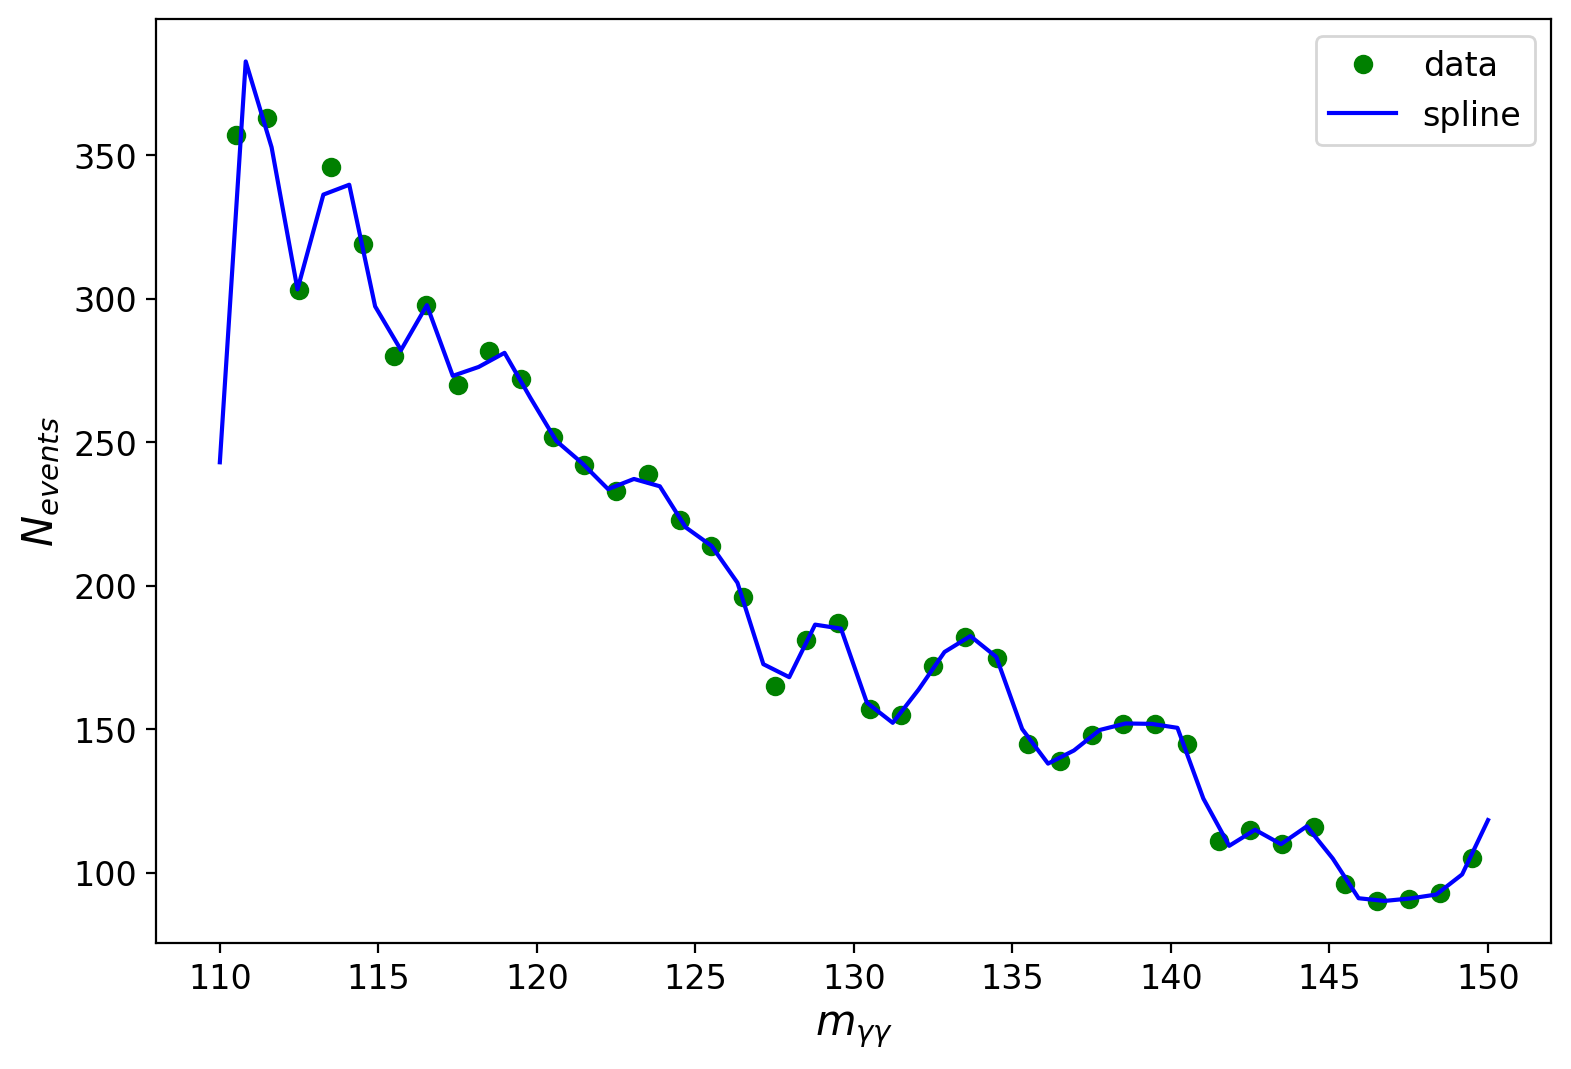

In [67]:
#Now lets load some data and do gaussian kernals with it
x,y,y_err,weights=load("data/out_2011.txt")


from scipy import interpolate
tck = interpolate.splrep(x, y) #setup the spline
x2 = np.linspace(110, 150) #range
y2 = interpolate.splev(x2, tck)#apply the spline

plt.plot(x, y, 'go',label='data')
plt.plot(x2, y2, 'b',label='spline')
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

So what happened is, we just took the data and turned it into a smooth function that we can evaulate anywhere. This is done by chunking up the data into little pieces and fitting higher order polynomials to each. We end up with a function. 

Since its a function, we can do whatever we want with it. Let's smooth this function out by convolving it with a Gaussian distribution. 

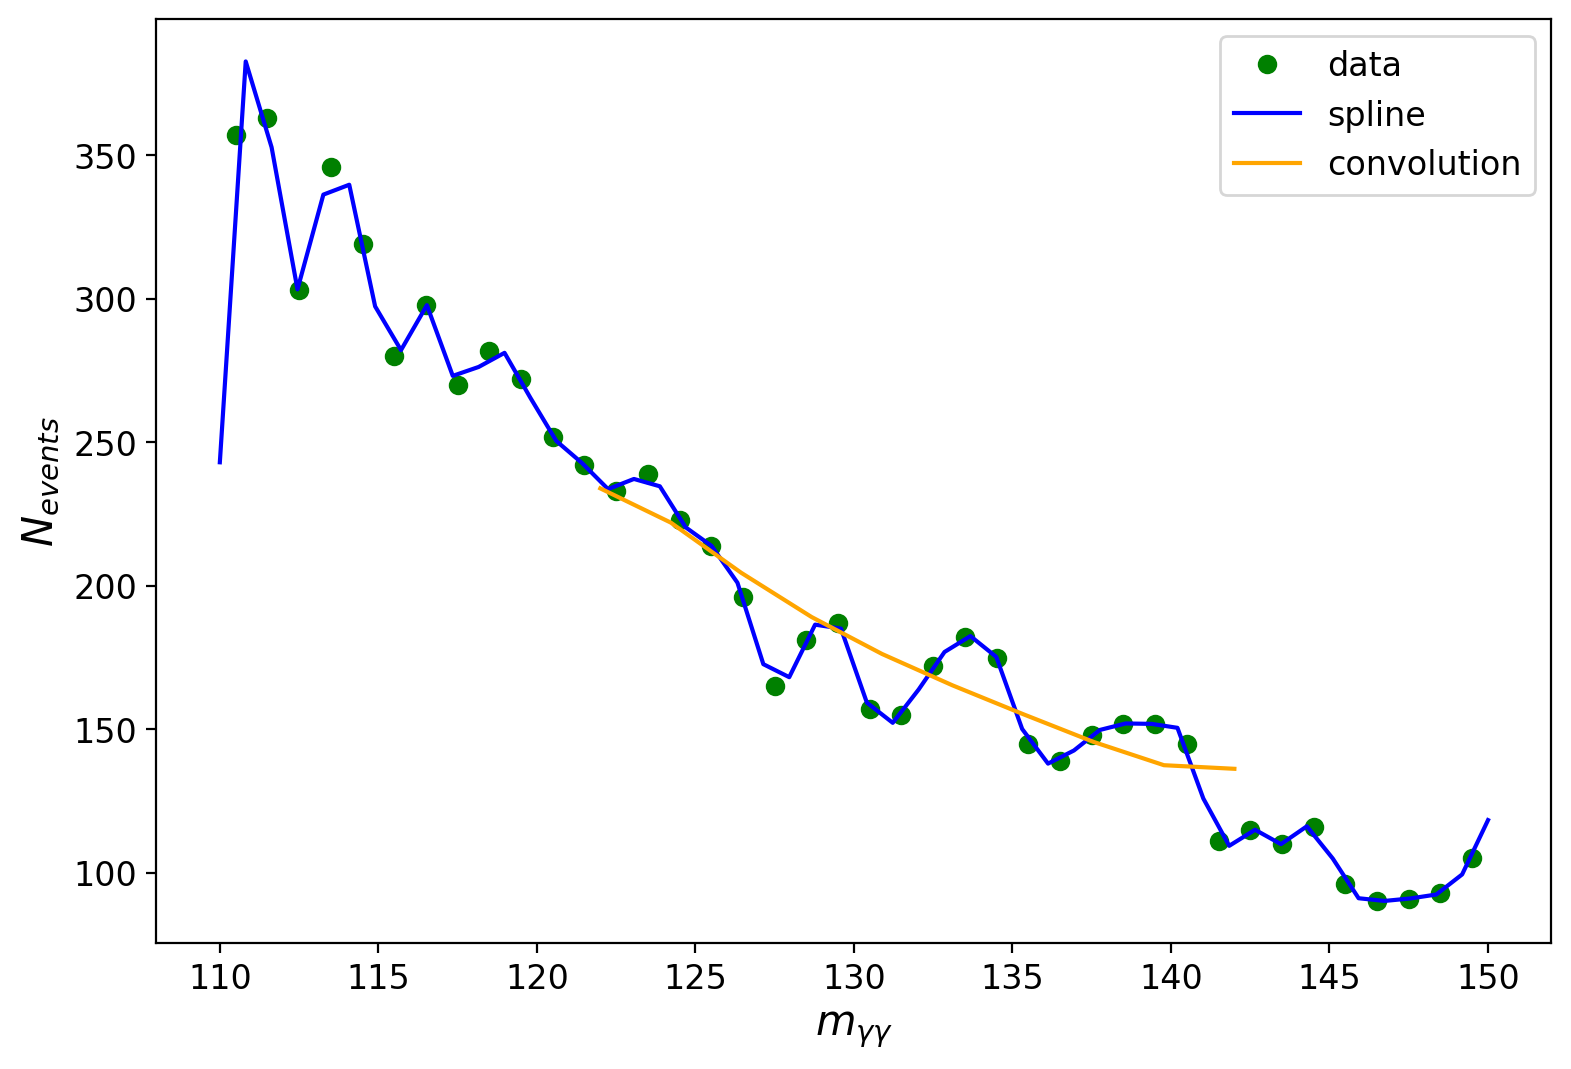

In [68]:
#spline convolve by hand
def splineconvolve(tck,f2,x,iMin=-15,iMax=15,iN=500):
    step=float((iMax-iMin))/float(iN)
    pInt=0
    for i0 in range(iN):
            pX   = i0*step+iMin
            pVal = interpolate.splev(x-pX,tck)*f2(pX)
            pInt += pVal*step
    return pInt

def gaussian(x,mean=0,sigma=5):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 

fig, ax = plt.subplots()
x_in=np.linspace(122, 142, 10)
conv_out=[]
for val in x_in:
    pConv_out=splineconvolve(tck,gaussian,val)
    conv_out.append(pConv_out)

#now we cna plot it
plt.plot(x, y, 'go',label='data')
plt.plot(x2, y2, 'b',label='spline')
plt.plot(x_in,conv_out,c='orange',label='convolution')
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

In fact, in recent times interpolation with all sorts of functions, not just polynomials have become very popular. Just to show you another one that is used often, lets try Gaussian processes. Gaussian processes, aim to fit guassian distributiosn to describe the data. The strategy, conceptually, is like the f-test. Keep adding Gaussian's to fit the data until it is well described. See [here](https://en.wikipedia.org/wiki/Gaussian_process) for a much deeper explanation for how this would work. 

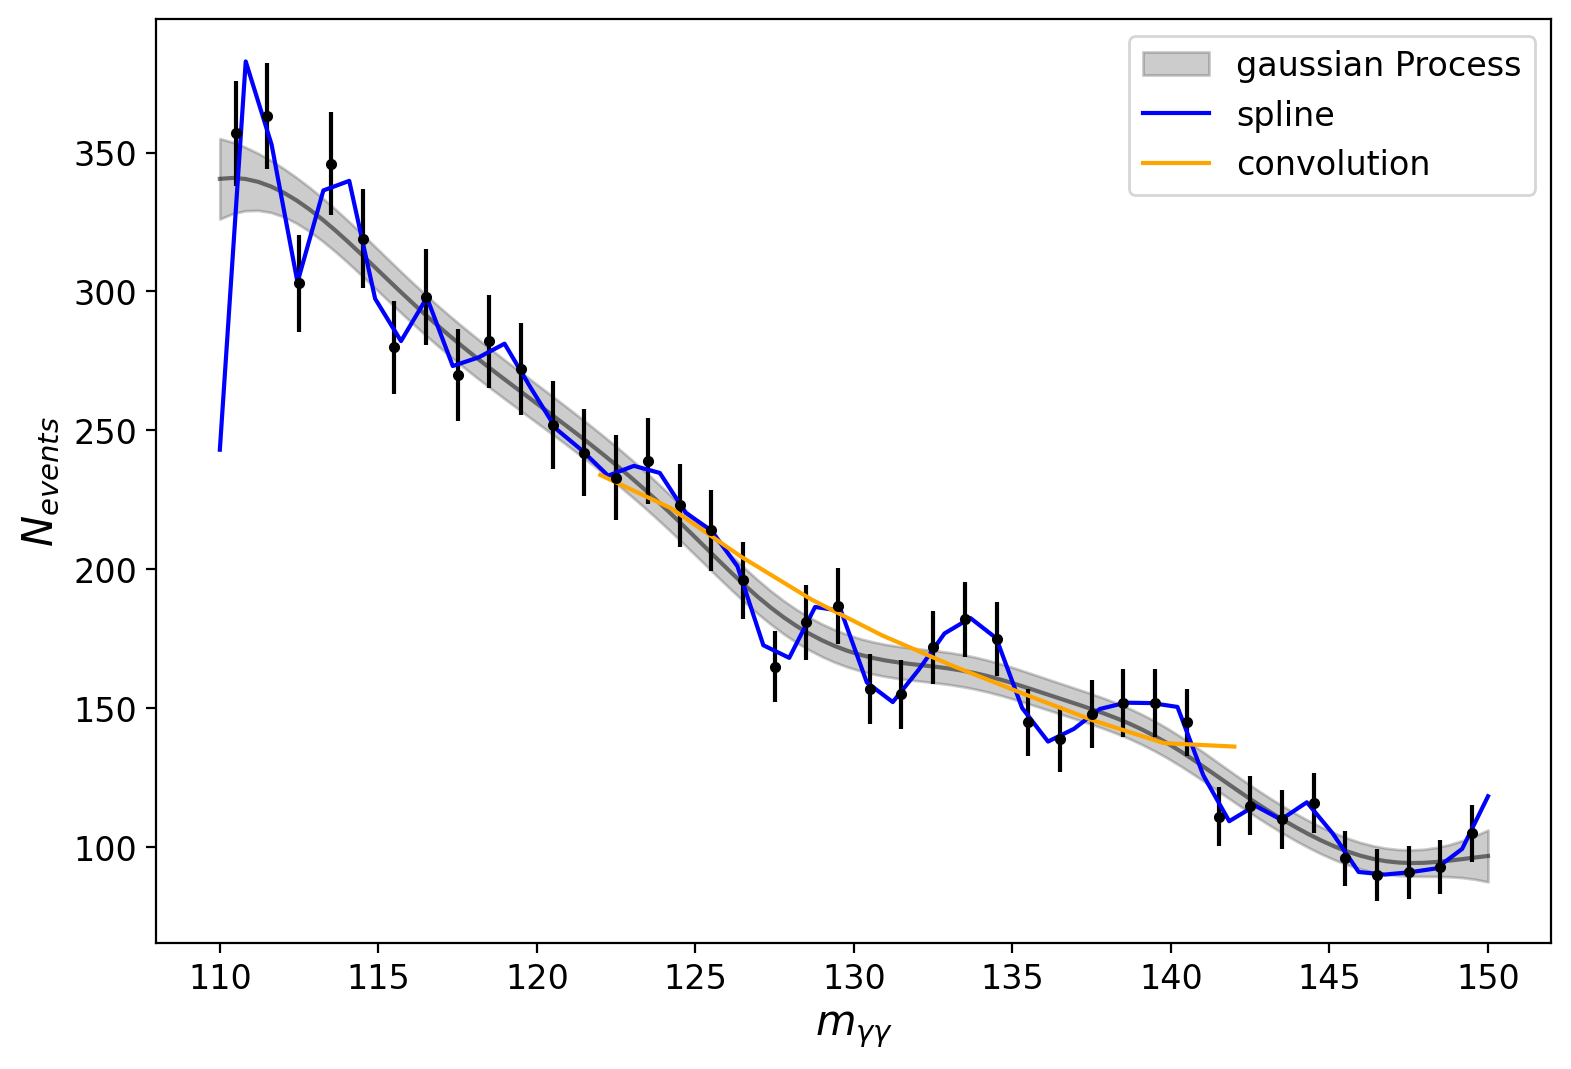

In [69]:
!pip install george
import george
from george import kernels

#kernel = np.var(y) * kernels.Matern52Kernel(5.0)
kernel = np.var(y) * kernels.Matern52Kernel(125.0)
gp = george.GP(kernel)
gp.compute(x, y_err)
x_pred = np.linspace(110, 150, 100)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2,label="gaussian Process")
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=y_err, fmt=".k", capsize=0)
plt.plot(x2, y2, 'b',label='spline')
plt.plot(x_in,conv_out,c='orange',label='convolution')
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

As with the spline, there are parameters for how it averages over the points. Try the kernal 125 above, you will see that this is is effectively changing the size of the window of interpolation. This will allow us to either smooth or unsmooth our distribution.  

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-11.6.1</span>

When we we have a spline function, we can now do coordinate tansforms of whole distributions, take the above spline, shift it by a 5 GeV and plot it again? 

In [ ]:
fig, ax = plt.subplots()

xs  = ###Your code here
ys  = ###Your code here

#now we cna plot it
plt.plot(x, y, 'go',label='data')
plt.plot(x2, y2, 'r',label='spline')
plt.plot(xs, ys, 'b',label='spline shift')
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

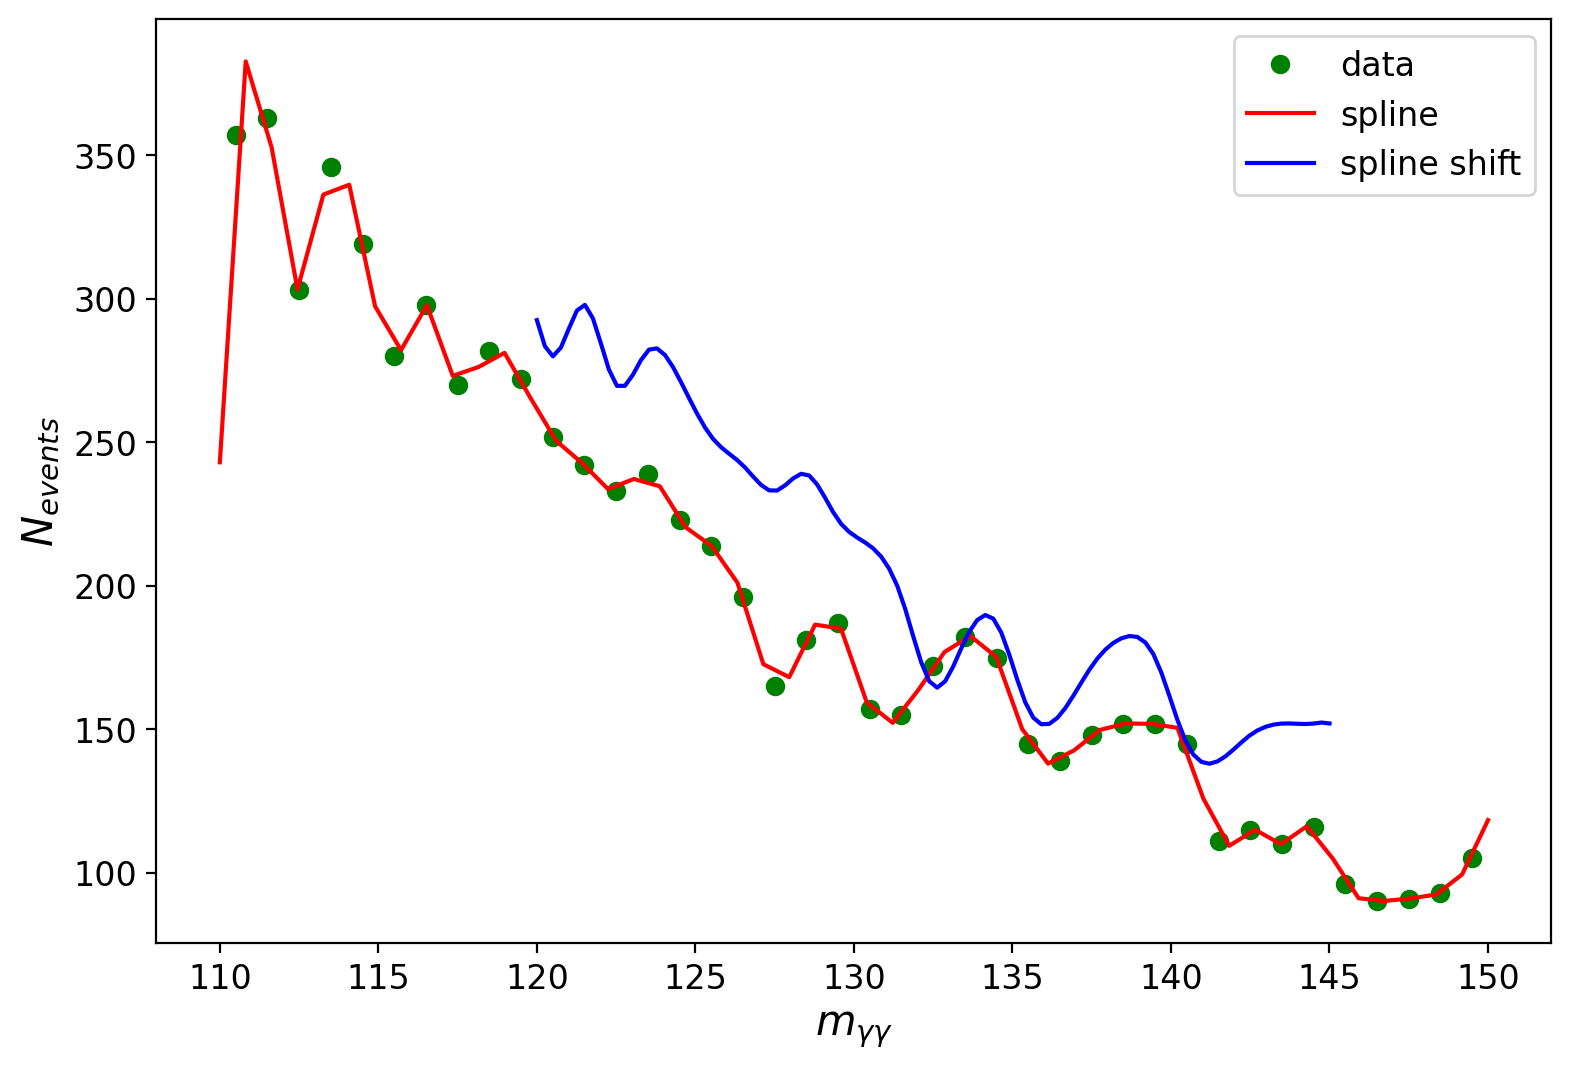

In [70]:
fig, ax = plt.subplots()

xs  = np.linspace(120,145,100)
ys  = interpolate.splev(xs-5, tck)#apply the spline

#now we cna plot it
plt.plot(x, y, 'go',label='data')
plt.plot(x2, y2, 'r',label='spline')
plt.plot(xs, ys, 'b',label='spline shift')
plt.xlabel("$m_{\gamma\gamma}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

<a name='section_12_7'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L12.7 Dealing with non-analytic forms</h2>  



At this point, we have gone a bit away from just fitting functions. Its not always the case that we have a nice function that we can fit to describe our data. It is sometimes the case that we have a simulated shape. For High energy physics, simulated shapes often come from so called "Monte-Carlo" simulation. In this approach, we construct distributions by randomly sampling many millions of events. The resulting simulated events can then be treated like data. The data set below represents another Higgs boson channel, the Higgs decay to 4 leptons. However, in this instance, we want to fit the peak at 90 with a simulation of the peak. 

/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_25448/2179228121.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


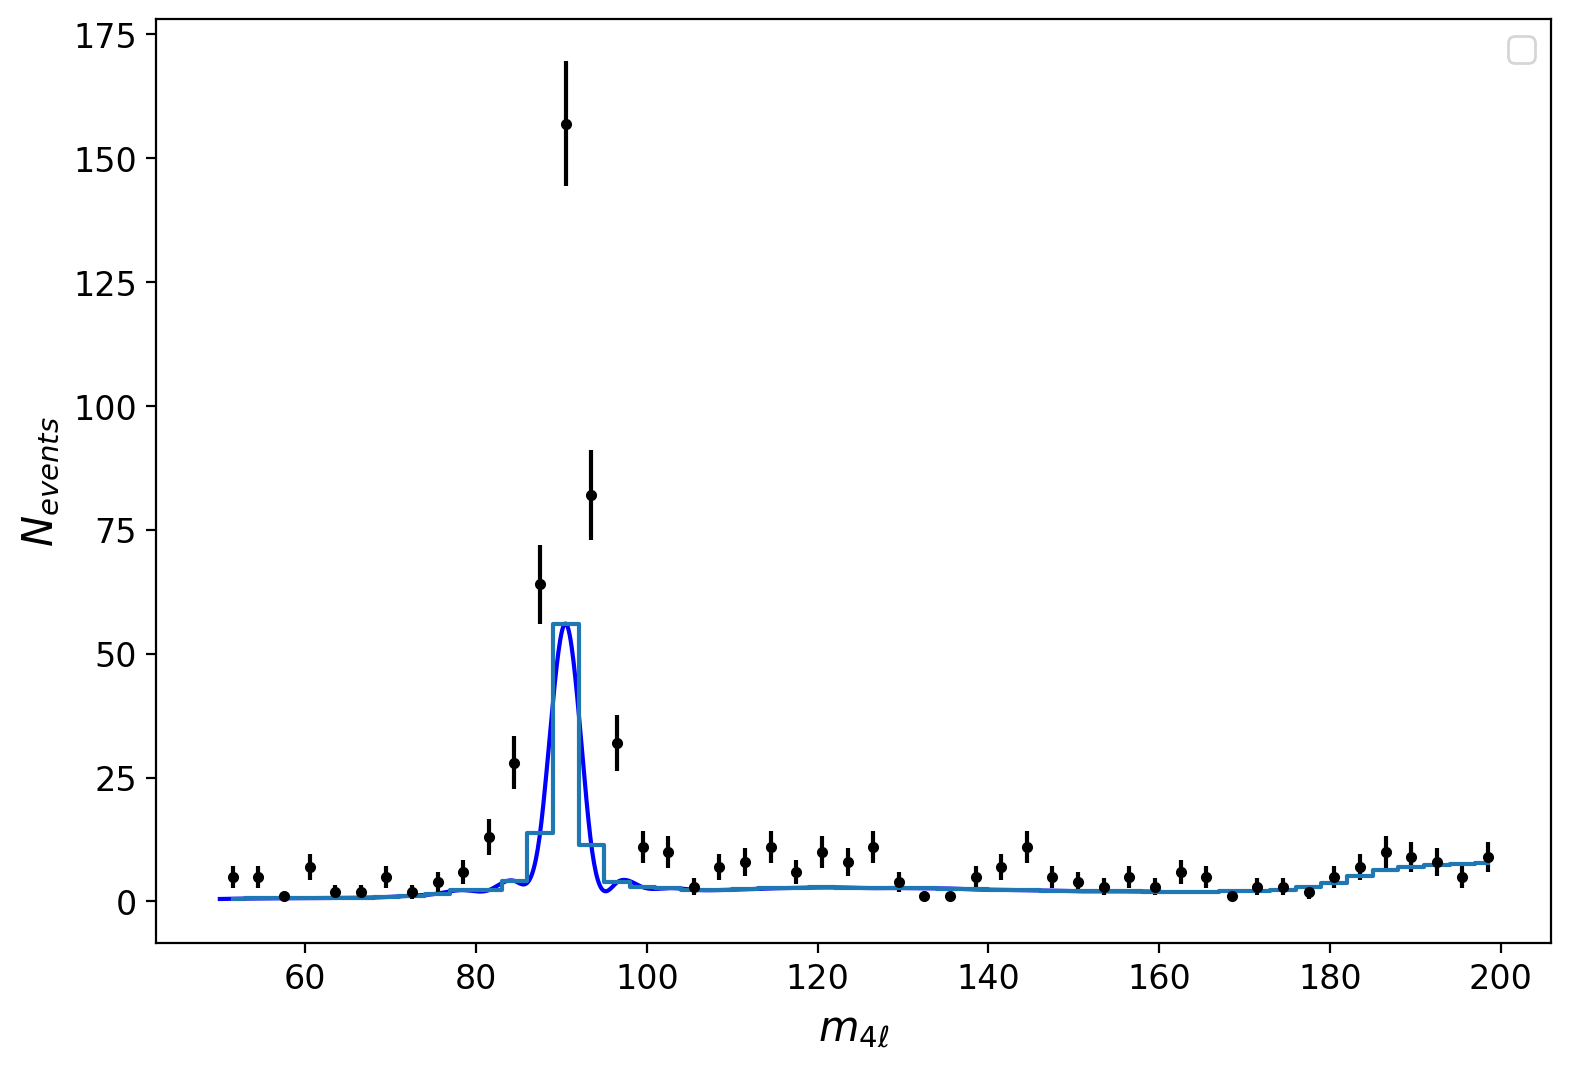

In [72]:
x,y_data,y_err,weights=load("data/data.txt",True)
x,y_mc,y_mc_err,_=load("data/zz_narrow.txt",True)

tck = interpolate.splrep(x, y_mc)
x2 = np.linspace(50, 160,1000)
y2 = interpolate.splev(x2, tck)
plt.errorbar(x,y_data,yerr=y_err,marker='.',linestyle = 'None', color = 'black')
plt.plot(x2, y2, 'b')
plt.plot(x,y_mc,drawstyle = 'steps-mid')
plt.xlabel("$m_{4\ell}$")
plt.ylabel("$N_{events}$")
plt.legend()
plt.show()

There are clearly a few things off. First of all the number of events is off. Secondly, the shapes don't look exactly the same. 

Oftentimes, when we actually want to do a precision fit, we will rely on our simulated samples to extract the signal. What we will do is allow the shape to be modified by a number of different approaches. One appraoch is to apply a numerical convolution of the shape with a gaussian distribution, so that we can smear it out, making it wider. This what we will do here. 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 50
    # variables        = 5
    chi-square         = 145.608969
    reduced chi-square = 3.23575486
    Akaike info crit   = 63.4450864
    Bayesian info crit = 73.0052014
    R-squared          = 0.99537578
[[Variables]]
    mean:   0.48126288 +/- 0.45214491 (93.95%) (init = 0)
    sigma:  2.27955564 +/- 0.52717944 (23.13%) (init = 0.1)
    amp:    3.00075196 +/- 0.32361426 (10.78%) (init = 3)
    a:      4.76537630 +/- 1.50430203 (31.57%) (init = 1)
    b:     -0.06266023 +/- 0.01320916 (21.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)   = -0.837
    C(amp, b) = -0.513


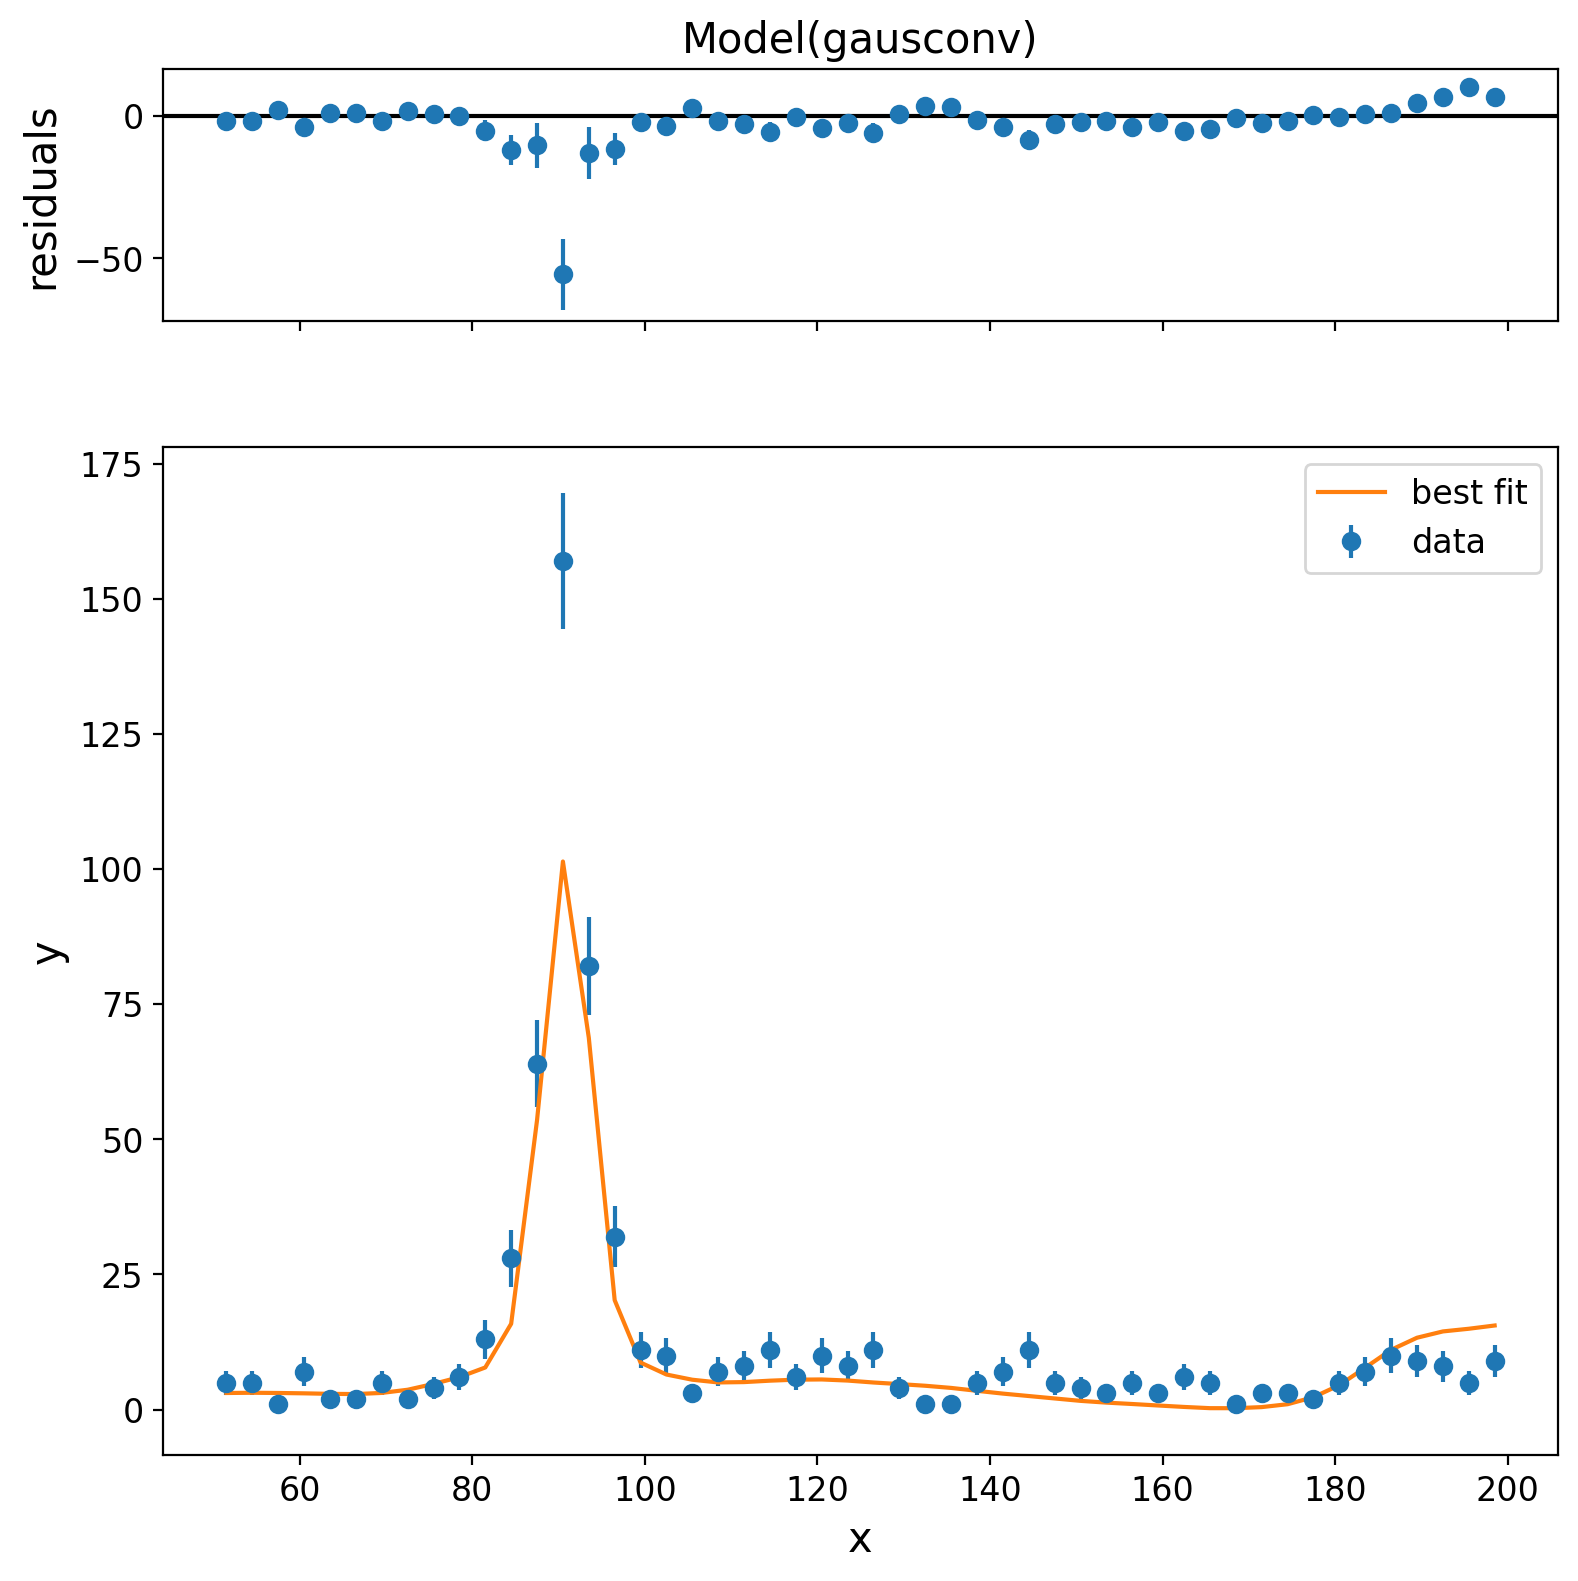

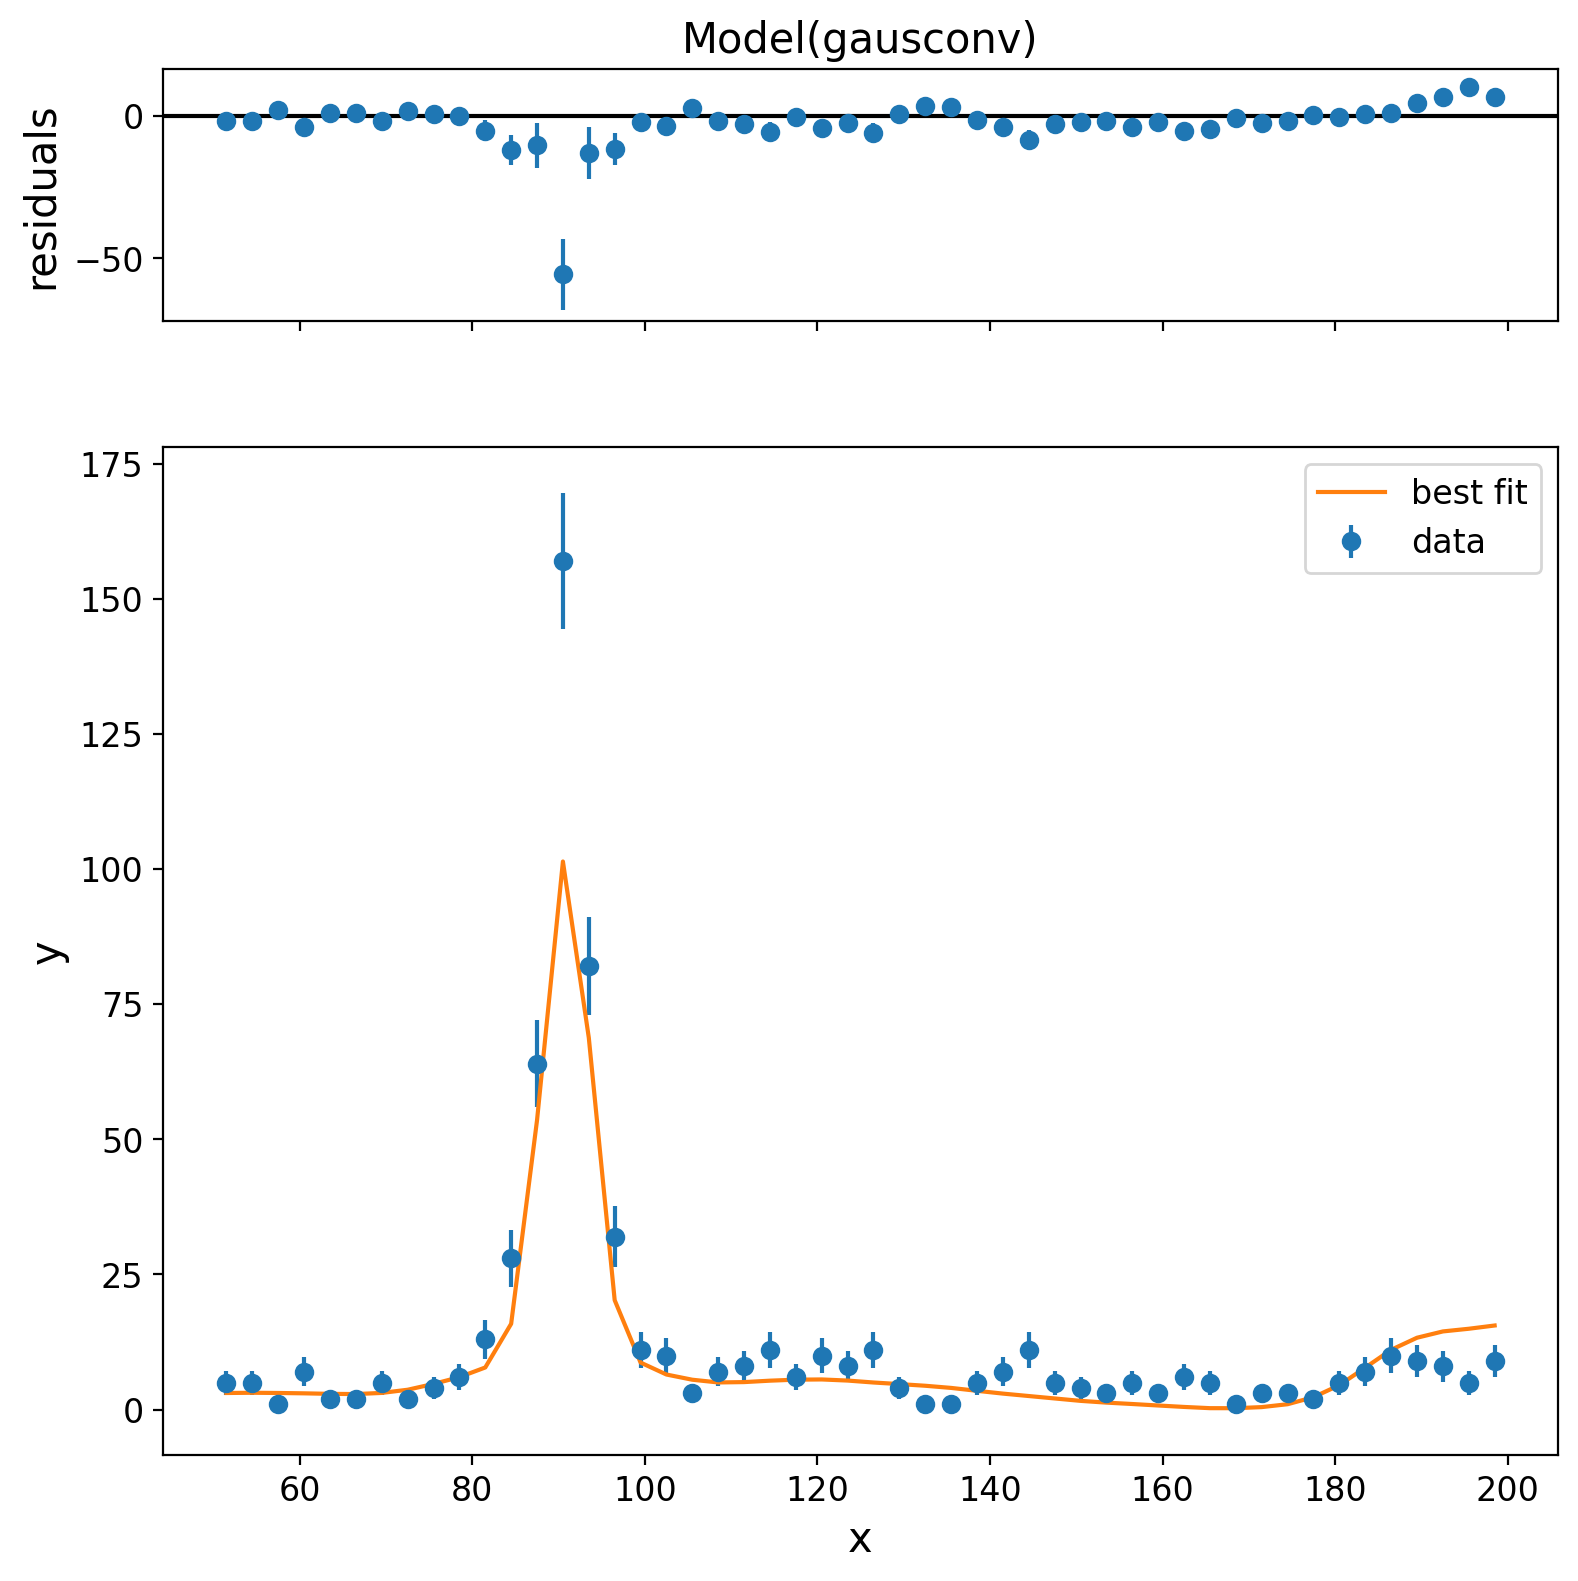

In [76]:
#spline convolve by hand
def splineconvolvegaus(x,mean,sigma,iMin=-15,iMax=15,iN=500):
    step=float((iMax-iMin))/float(iN)
    pInt=0
    for i0 in range(iN):
            pX   = i0*step+iMin
            pVal = interpolate.splev(x-pX,tck)*gaussian(pX,mean,sigma)
            pInt += pVal*step
    return pInt

def gausconv(x,mean,sigma,amp,a,b):
    val=splineconvolvegaus(x,mean,sigma)*amp
    val=a + b*x + val
    return val

model  = lmfit.Model(gausconv)
p = model.make_params(mean=0,sigma=1.0,amp=3.0,a=1,b=0)
p["sigma"].value=0.1
#p["sigma"].vary=False
result = model.fit(data=y_data,params=p,x=x,weights=weights)
lmfit.report_fit(result)
result.plot()

This doesn't fully get the data correct, but its definitely a big step towards getting something much better. You will have to use these distributions in future datasets, so you will see more about how things. Just to get a better idea of what is going in this fit, lets actually look at what happens, if we don't allow the peak to move aroundn, and we also fix the resolution to be narrow. 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 50
    # variables        = 4
    chi-square         = 149.231776
    reduced chi-square = 3.24416905
    Akaike info crit   = 62.6738818
    Bayesian info crit = 70.3219738
    R-squared          = 0.99526073
[[Variables]]
    mean:      0 (fixed)
    sigma:     2.28200208 +/- 0.54357476 (23.82%) (init = 1)
    sig:       2.95560830 +/- 0.32114769 (10.87%) (init = 2)
    baseline:  4.76347171 +/- 1.50632887 (31.62%) (init = 2)
    slope:    -0.06228421 +/- 0.01322182 (21.23%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(baseline, slope) = -0.837
    C(sig, slope)      = -0.515
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 50
    # variables        = 3
    chi-square         = 174.271838
    reduced chi-square = 3.70791146
    Akaike info crit   = 68.4296682
    Bayesian info crit = 74.1657372
    R

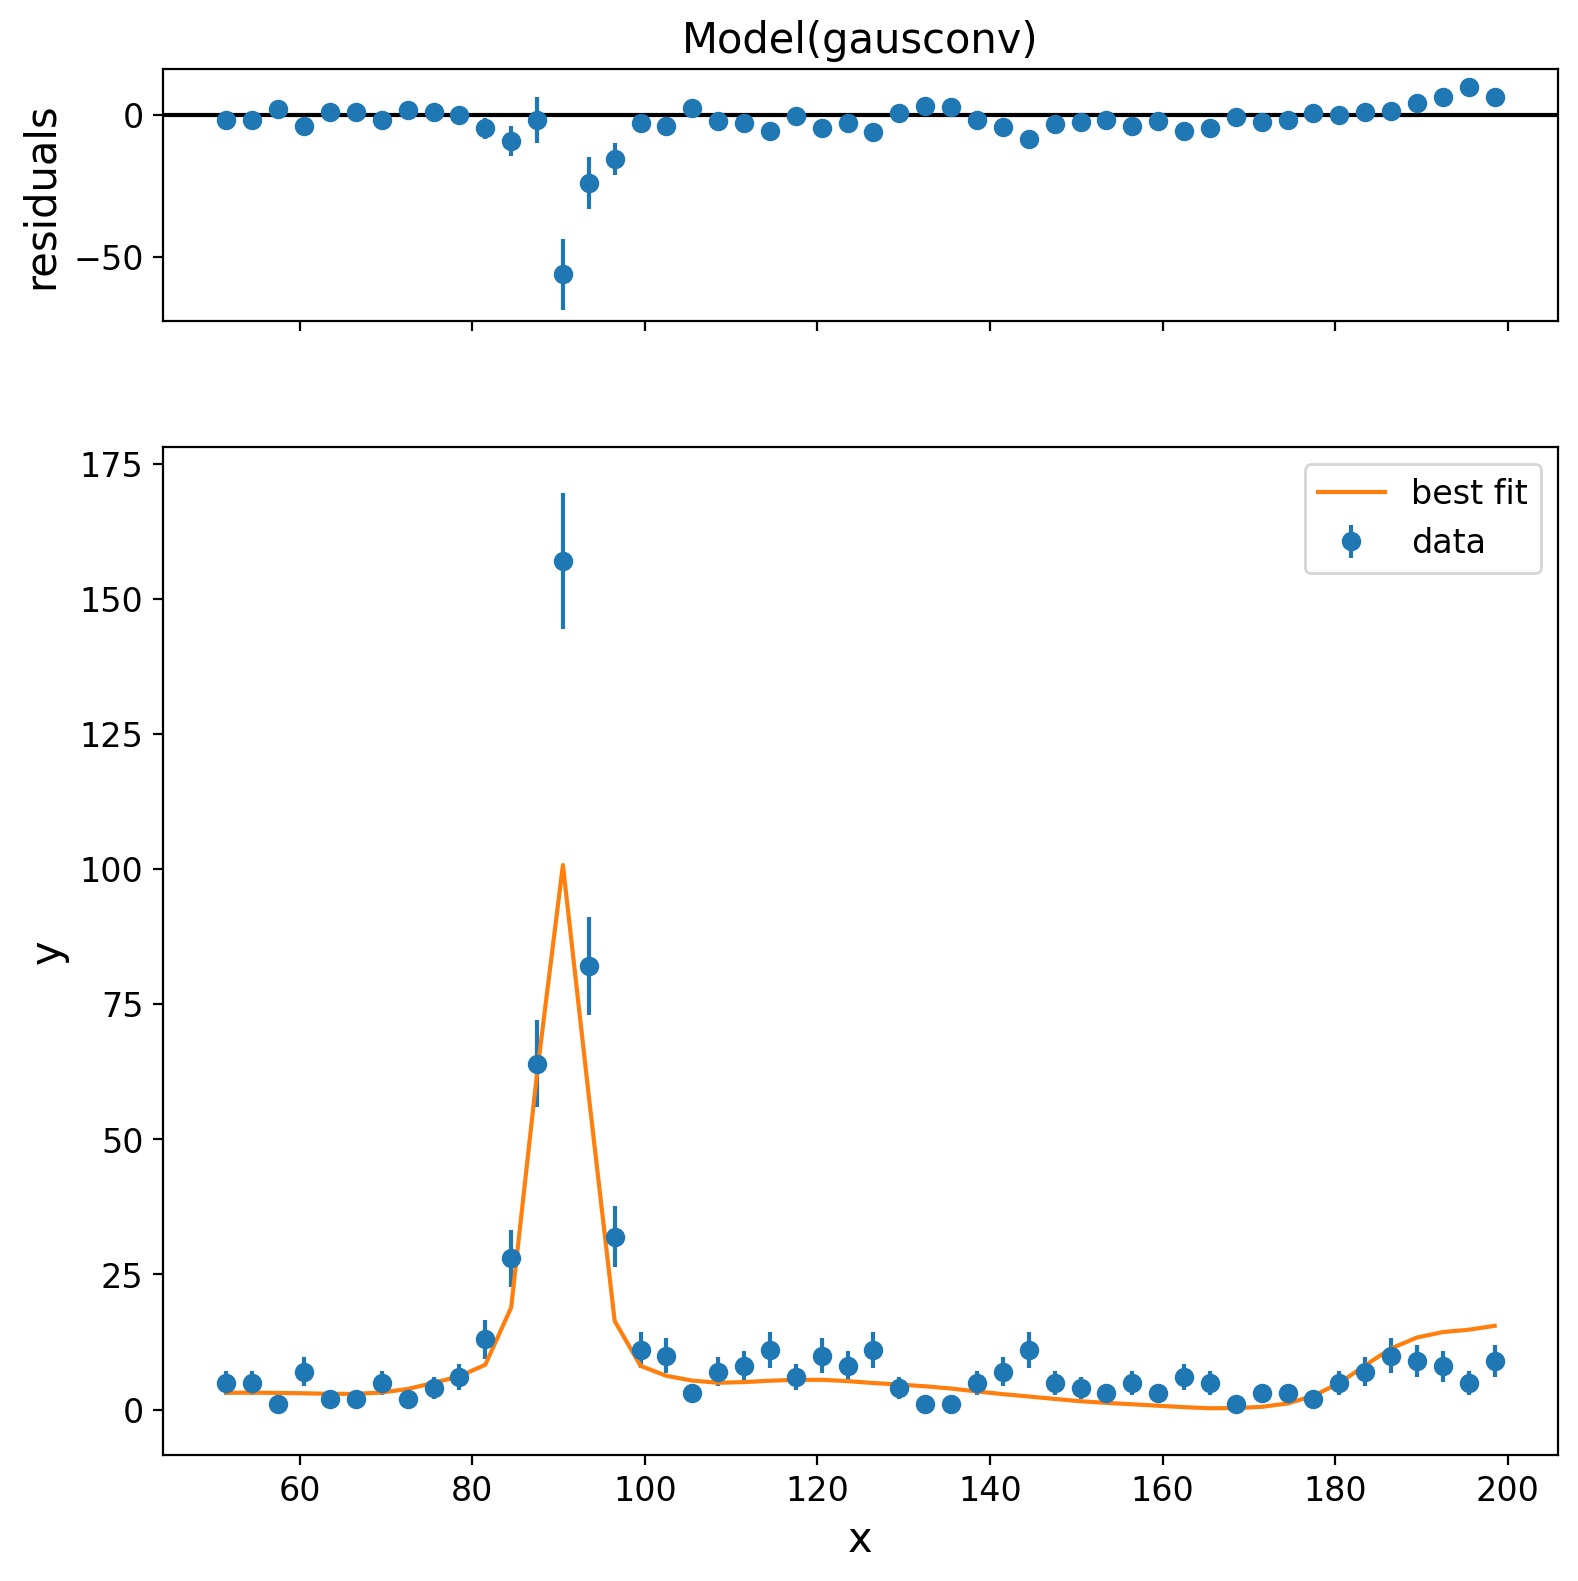

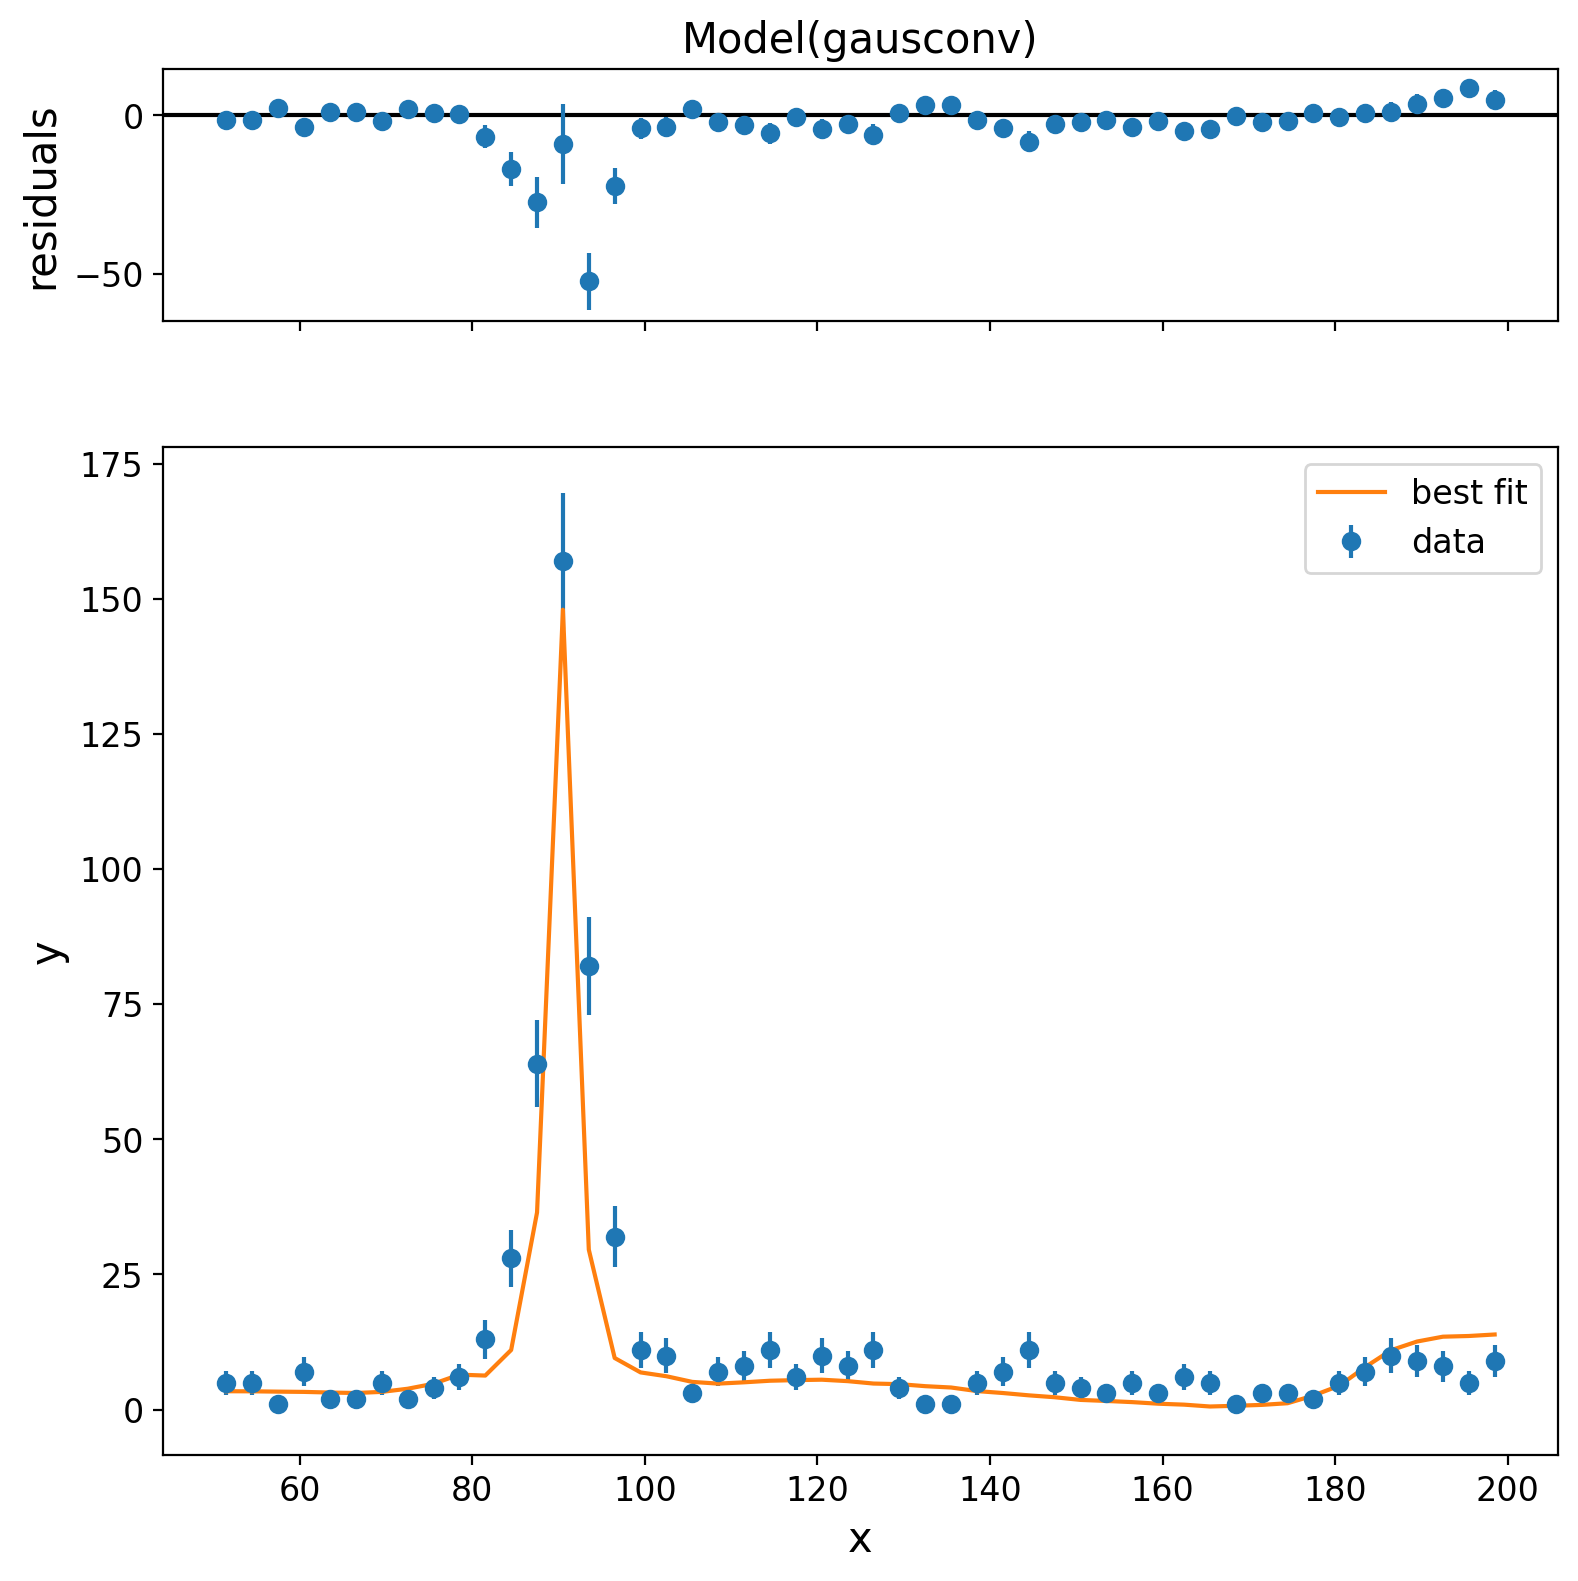

In [77]:
def splineconvolvegaus(tck,f2,x,mean,sigma,iMin=-15,iMax=15,iN=500):
    step=float((iMax-iMin))/float(iN)
    pInt=0
    for i0 in range(iN):
            pX   = i0*step+iMin
            pVal = interpolate.splev(x-pX,tck)*f2(pX,mean,sigma)
            pInt += pVal*step
    return pInt

def gausconv(x,mean,sigma,sig,baseline,slope):
    val=splineconvolvegaus(tck,gaussian,x,mean,sigma)
    output = baseline+sig*val+slope*x
    return output

model  = lmfit.Model(gausconv)
p = model.make_params(mean=0,sigma=1,sig=2,baseline=2,slope=0)
p["mean"].vary = False
p["sigma"].vary = True
result = model.fit(data=y_data, params=p, x=x, weights=weights)
lmfit.report_fit(result)
result.plot()

#Now lets not smear the data
p["sigma"].value = 0.01
p["sigma"].vary = False
result = model.fit(data=y_data, params=p, x=x, weights=weights)
lmfit.report_fit(result)
_=result.plot()

##  Going beyond

This is just the start of construction fit functions. The next set of tools we can explore is how to build deep learning algorithms to model the data. As we have gone through this lecture, and the previous lectures, we have been abstracting and standardizing the tools more and more to get to the point of automating the whole procedure that is the point and this is where we start for the next sections of the course. 